# The weather dataset
This tutorial uses a [weather time series dataset recorded by the Max Planck Institute for Biogeochemistry.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book Deep Learning with Python.

https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
%load_ext tensorboard


In [2]:
import tensorflow as tf
import datetime

from lstm_timeseries import (data_proc, 
                             univariate_data, 
                             show_plot, 
                             baseline, 
                             multivariate_data,
                             single_step_model, 
                             TimeSeriesLSTM, 
                             plot_preds, 
                             train_val_tf)

import matplotlib.pyplot as plt
tf.random.set_seed(13)



In [3]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [4]:
%%time
df = data_proc()

Wall time: 1.17 s


In [5]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [6]:
TRAIN_SPLIT = 300000


# Part 1: Forecast a univariate time series

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

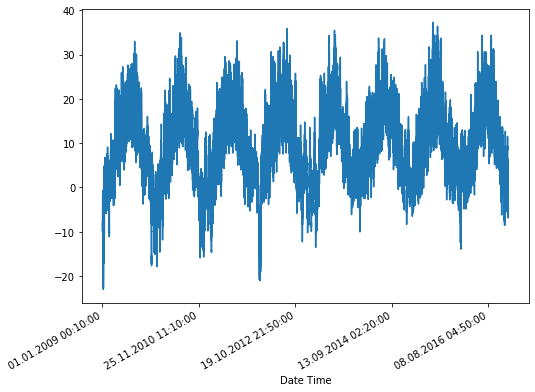

In [8]:
uni_data.plot(subplots=True);

In [9]:
uni_data = uni_data.values

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std


univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)

x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

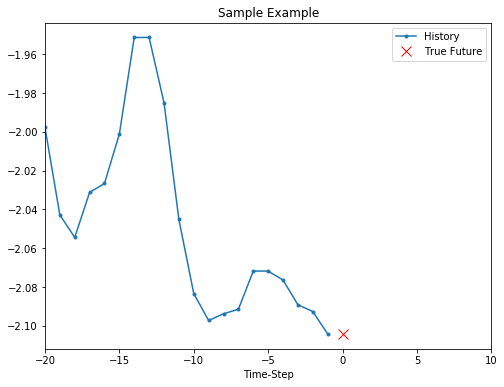

In [10]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

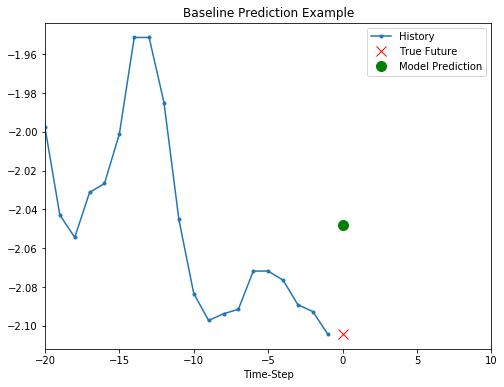

In [11]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example');

# Multivariate forecast with lstm

In [12]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


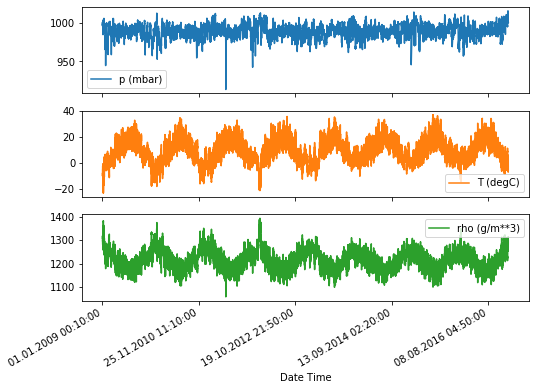

In [13]:
features.plot(subplots=True);

In [14]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean)/data_std

# Single step model
* multivariate features to predict next time step

In [15]:
# data for the last 5 days is used (720 observations) predict 12h ahead
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)

x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)



In [16]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [17]:
%%time
trained_model, single_step_history = single_step_model(x_train_single, 
                                                       y_train_single,
                                                       x_val_single, 
                                                       y_val_single,
                                                       epochs=2)



Train for 200 steps, validate for 50 steps
Epoch 1/2
200/200 [==============================] - ETA: 12:07 - loss: 1.13 - ETA: 1:59 - loss: 0.9627 - ETA: 1:04 - loss: 0.795 - ETA: 43s - loss: 0.663 - ETA: 32s - loss: 0.59 - ETA: 26s - loss: 0.55 - ETA: 21s - loss: 0.52 - ETA: 18s - loss: 0.50 - ETA: 15s - loss: 0.48 - ETA: 13s - loss: 0.46 - ETA: 11s - loss: 0.45 - ETA: 9s - loss: 0.4386 - ETA: 8s - loss: 0.428 - ETA: 7s - loss: 0.417 - ETA: 6s - loss: 0.407 - ETA: 6s - loss: 0.398 - ETA: 5s - loss: 0.389 - ETA: 4s - loss: 0.382 - ETA: 4s - loss: 0.376 - ETA: 4s - loss: 0.370 - ETA: 3s - loss: 0.364 - ETA: 3s - loss: 0.360 - ETA: 2s - loss: 0.357 - ETA: 2s - loss: 0.353 - ETA: 2s - loss: 0.349 - ETA: 1s - loss: 0.345 - ETA: 1s - loss: 0.341 - ETA: 1s - loss: 0.338 - ETA: 1s - loss: 0.336 - ETA: 1s - loss: 0.334 - ETA: 0s - loss: 0.332 - ETA: 0s - loss: 0.330 - ETA: 0s - loss: 0.329 - ETA: 0s - loss: 0.327 - ETA: 0s - loss: 0.325 - 6s 32ms/step - loss: 0.3251 - val_loss: 0.2670
Epoch 2/

# Plot first 3 predictions
Use validation data for predictions

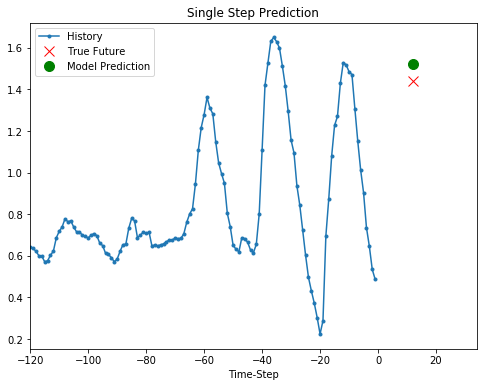

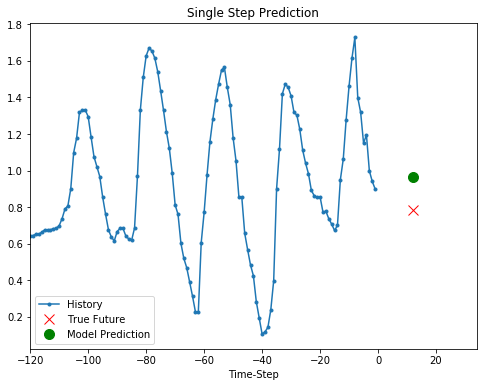

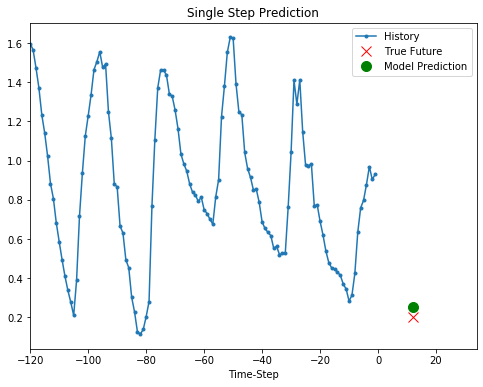

In [18]:

train_data_single, val_data_single = train_val_tf(x_train_single, y_train_single, x_val_single, y_val_single)
plot_preds(trained_model, val_data_single)



In [19]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

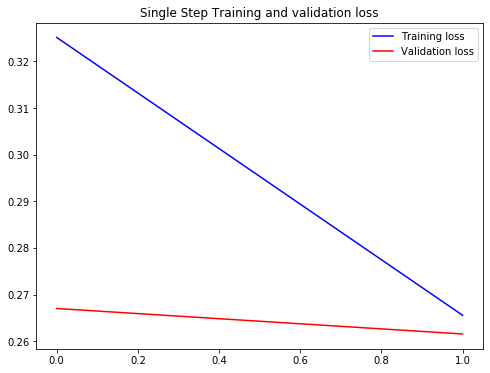

In [20]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

# Hyperparam search
### Hyperband
* Same data as in single step training above

In [ ]:
%%time
from kerastuner.tuners import RandomSearch, Hyperband


log_dir = "logs\hyperband" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print("log_dir", log_dir)



hypermodel = TimeSeriesLSTM(num_outputs=1)
    
tuner = Hyperband(
    hypermodel,
    objective='mae',
    #max_trials=40,
    directory=log_dir,
    project_name='helloworld_hyperband', 
    max_epochs=10
)



tuner.search(x_train_single,
             y_train_single, 
             epochs=10, 
             validation_data=(x_val_single, y_val_single), 
             callbacks=[tensorboard_callback])

log_dir logs\hyperband
Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 33824/299280 [==>...........................] - ETA: 5:10:06 - loss: 0.6057 - mae: 0.60 - ETA: 1:46:39 - loss: 0.5644 - mae: 0.56 - ETA: 54:41 - loss: 0.6656 - mae: 0.6656 - ETA: 30:35 - loss: 0.6648 - mae: 0.66 - ETA: 21:31 - loss: 0.6405 - mae: 0.64 - ETA: 16:46 - loss: 0.6293 - mae: 0.62 - ETA: 13:50 - loss: 0.6138 - mae: 0.61 - ETA: 11:30 - loss: 0.5963 - mae: 0.59 - ETA: 10:09 - loss: 0.5851 - mae: 0.58 - ETA: 9:07 - loss: 0.5750 - mae: 0.5750 - ETA: 8:10 - loss: 0.5577 - mae: 0.557 - ETA: 7:33 - loss: 0.5492 - mae: 0.549 - ETA: 7:02 - loss: 0.5384 - mae: 0.538 - ETA: 6:36 - loss: 0.5281 - mae: 0.528 - ETA: 6:14 - loss: 0.5193 - mae: 0.519 - ETA: 5:55 - loss: 0.5141 - mae: 0.514 - ETA: 5:39 - loss: 0.5066 - mae: 0.506 - ETA: 5:24 - loss: 0.4980 - mae: 0.498 - ETA: 5:08 - loss: 0.4887 - mae: 0.488 - ETA: 4:53 - loss: 0.4806 - mae: 0.480 - ETA: 4:43 - loss: 0.4757 - mae: 0.475 - ETA: 4:34 - loss: 0.4721 - mae: 0.472 - ETA: 4:26 - loss: 0.4672 - mae: 0.467 - ETA: 4:17 - loss: 0.4613

 68352/299280 [=====>........................] - ETA: 1:40 - loss: 0.3221 - mae: 0.322 - ETA: 1:40 - loss: 0.3218 - mae: 0.321 - ETA: 1:40 - loss: 0.3218 - mae: 0.321 - ETA: 1:40 - loss: 0.3216 - mae: 0.321 - ETA: 1:40 - loss: 0.3215 - mae: 0.321 - ETA: 1:40 - loss: 0.3214 - mae: 0.321 - ETA: 1:39 - loss: 0.3213 - mae: 0.321 - ETA: 1:39 - loss: 0.3212 - mae: 0.321 - ETA: 1:39 - loss: 0.3210 - mae: 0.321 - ETA: 1:39 - loss: 0.3209 - mae: 0.320 - ETA: 1:39 - loss: 0.3209 - mae: 0.320 - ETA: 1:39 - loss: 0.3205 - mae: 0.320 - ETA: 1:39 - loss: 0.3203 - mae: 0.320 - ETA: 1:38 - loss: 0.3201 - mae: 0.320 - ETA: 1:38 - loss: 0.3199 - mae: 0.319 - ETA: 1:38 - loss: 0.3198 - mae: 0.319 - ETA: 1:38 - loss: 0.3196 - mae: 0.319 - ETA: 1:38 - loss: 0.3196 - mae: 0.319 - ETA: 1:38 - loss: 0.3195 - mae: 0.319 - ETA: 1:38 - loss: 0.3193 - mae: 0.319 - ETA: 1:38 - loss: 0.3191 - mae: 0.319 - ETA: 1:38 - loss: 0.3189 - mae: 0.318 - ETA: 1:37 - loss: 0.3189 - mae: 0.318 - ETA: 1:37 - loss: 0.3185 - mae:

103136/299280 [=========>....................] - ETA: 1:21 - loss: 0.2987 - mae: 0.298 - ETA: 1:21 - loss: 0.2986 - mae: 0.298 - ETA: 1:20 - loss: 0.2986 - mae: 0.298 - ETA: 1:20 - loss: 0.2985 - mae: 0.298 - ETA: 1:20 - loss: 0.2984 - mae: 0.298 - ETA: 1:20 - loss: 0.2983 - mae: 0.298 - ETA: 1:20 - loss: 0.2982 - mae: 0.298 - ETA: 1:20 - loss: 0.2981 - mae: 0.298 - ETA: 1:20 - loss: 0.2981 - mae: 0.298 - ETA: 1:20 - loss: 0.2980 - mae: 0.298 - ETA: 1:20 - loss: 0.2979 - mae: 0.297 - ETA: 1:20 - loss: 0.2978 - mae: 0.297 - ETA: 1:20 - loss: 0.2977 - mae: 0.297 - ETA: 1:20 - loss: 0.2976 - mae: 0.297 - ETA: 1:20 - loss: 0.2975 - mae: 0.297 - ETA: 1:20 - loss: 0.2974 - mae: 0.297 - ETA: 1:19 - loss: 0.2974 - mae: 0.297 - ETA: 1:19 - loss: 0.2973 - mae: 0.297 - ETA: 1:19 - loss: 0.2973 - mae: 0.297 - ETA: 1:19 - loss: 0.2971 - mae: 0.297 - ETA: 1:19 - loss: 0.2971 - mae: 0.297 - ETA: 1:19 - loss: 0.2971 - mae: 0.297 - ETA: 1:19 - loss: 0.2970 - mae: 0.297 - ETA: 1:19 - loss: 0.2969 - mae:

136960/299280 [============>.................] - ETA: 1:06 - loss: 0.2866 - mae: 0.286 - ETA: 1:06 - loss: 0.2865 - mae: 0.286 - ETA: 1:06 - loss: 0.2864 - mae: 0.286 - ETA: 1:06 - loss: 0.2864 - mae: 0.286 - ETA: 1:06 - loss: 0.2864 - mae: 0.286 - ETA: 1:06 - loss: 0.2864 - mae: 0.286 - ETA: 1:06 - loss: 0.2863 - mae: 0.286 - ETA: 1:06 - loss: 0.2862 - mae: 0.286 - ETA: 1:06 - loss: 0.2862 - mae: 0.286 - ETA: 1:06 - loss: 0.2861 - mae: 0.286 - ETA: 1:05 - loss: 0.2861 - mae: 0.286 - ETA: 1:05 - loss: 0.2860 - mae: 0.286 - ETA: 1:05 - loss: 0.2860 - mae: 0.286 - ETA: 1:05 - loss: 0.2860 - mae: 0.286 - ETA: 1:05 - loss: 0.2860 - mae: 0.286 - ETA: 1:05 - loss: 0.2860 - mae: 0.286 - ETA: 1:05 - loss: 0.2859 - mae: 0.285 - ETA: 1:05 - loss: 0.2858 - mae: 0.285 - ETA: 1:05 - loss: 0.2858 - mae: 0.285 - ETA: 1:05 - loss: 0.2857 - mae: 0.285 - ETA: 1:05 - loss: 0.2857 - mae: 0.285 - ETA: 1:05 - loss: 0.2857 - mae: 0.285 - ETA: 1:05 - loss: 0.2857 - mae: 0.285 - ETA: 1:05 - loss: 0.2857 - mae:

171360/299280 [================>.............] - ETA: 54s - loss: 0.2800 - mae: 0.28 - ETA: 54s - loss: 0.2800 - mae: 0.28 - ETA: 54s - loss: 0.2799 - mae: 0.27 - ETA: 54s - loss: 0.2799 - mae: 0.27 - ETA: 54s - loss: 0.2799 - mae: 0.27 - ETA: 54s - loss: 0.2798 - mae: 0.27 - ETA: 54s - loss: 0.2798 - mae: 0.27 - ETA: 54s - loss: 0.2798 - mae: 0.27 - ETA: 54s - loss: 0.2797 - mae: 0.27 - ETA: 54s - loss: 0.2797 - mae: 0.27 - ETA: 54s - loss: 0.2796 - mae: 0.27 - ETA: 54s - loss: 0.2796 - mae: 0.27 - ETA: 54s - loss: 0.2795 - mae: 0.27 - ETA: 54s - loss: 0.2795 - mae: 0.27 - ETA: 54s - loss: 0.2795 - mae: 0.27 - ETA: 54s - loss: 0.2794 - mae: 0.27 - ETA: 54s - loss: 0.2794 - mae: 0.27 - ETA: 53s - loss: 0.2794 - mae: 0.27 - ETA: 53s - loss: 0.2793 - mae: 0.27 - ETA: 53s - loss: 0.2792 - mae: 0.27 - ETA: 53s - loss: 0.2792 - mae: 0.27 - ETA: 53s - loss: 0.2792 - mae: 0.27 - ETA: 53s - loss: 0.2791 - mae: 0.27 - ETA: 53s - loss: 0.2791 - mae: 0.27 - ETA: 53s - loss: 0.2791 - mae: 0.27 - E

205760/299280 [===================>..........] - ETA: 43s - loss: 0.2745 - mae: 0.27 - ETA: 43s - loss: 0.2745 - mae: 0.27 - ETA: 43s - loss: 0.2745 - mae: 0.27 - ETA: 43s - loss: 0.2745 - mae: 0.27 - ETA: 43s - loss: 0.2744 - mae: 0.27 - ETA: 42s - loss: 0.2744 - mae: 0.27 - ETA: 42s - loss: 0.2744 - mae: 0.27 - ETA: 42s - loss: 0.2744 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2743 - mae: 0.27 - ETA: 42s - loss: 0.2742 - mae: 0.27 - ETA: 42s - loss: 0.2742 - mae: 0.27 - ETA: 42s - loss: 0.2742 - mae: 0.27 - ETA: 42s - loss: 0.2742 - mae: 0.27 - ETA: 42s - loss: 0.2741 - mae: 0.27 - ETA: 42s - loss: 0.2741 - mae: 0.27 - ETA: 42s - loss: 0.2741 - mae: 0.27 - ETA: 42s - loss: 0.2741 - mae: 0.27 - ETA: 42s - loss: 0.2741 - mae: 0.27 - ETA: 41s - loss: 0.2741 - mae: 0.27 - ETA: 41s - loss: 0.2741 - mae: 0.27 - E

240160/299280 [=======================>......] - ETA: 31s - loss: 0.2707 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2706 - mae: 0.27 - ETA: 31s - loss: 0.2705 - mae: 0.27 - ETA: 30s - loss: 0.2705 - mae: 0.27 - ETA: 30s - loss: 0.2705 - mae: 0.27 - ETA: 30s - loss: 0.2705 - mae: 0.27 - ETA: 30s - loss: 0.2705 - mae: 0.27 - ETA: 30s - loss: 0.2704 - mae: 0.27 - ETA: 30s - loss: 0.2704 - mae: 0.27 - ETA: 30s - loss: 0.2704 - mae: 0.27 - ETA: 30s - loss: 0.2704 - mae: 0.27 - ETA: 30s - loss: 0.2704 - mae: 0.27 - ETA: 30s - loss: 0.2703 - mae: 0.27 - ETA: 30s - loss: 0.2703 - mae: 0.27 - ETA: 30s - loss: 0.2703 - mae: 0.27 - ETA: 30s - loss: 0.2703 - mae: 0.27 - ETA: 30s - loss: 0.2703 - mae: 0.27 - E

274144/299280 [==========================>...] - ETA: 19s - loss: 0.2672 - mae: 0.26 - ETA: 19s - loss: 0.2672 - mae: 0.26 - ETA: 19s - loss: 0.2672 - mae: 0.26 - ETA: 19s - loss: 0.2672 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2671 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 19s - loss: 0.2670 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - ETA: 18s - loss: 0.2669 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2650 - mae: 0.265 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 8s - loss: 0.2649 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2648 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - ETA: 7s - loss: 0.2647 - mae: 0.264 - E

 32512/299280 [==>...........................] - ETA: 2:19 - loss: 0.2692 - mae: 0.269 - ETA: 1:48 - loss: 0.2470 - mae: 0.247 - ETA: 1:45 - loss: 0.2437 - mae: 0.243 - ETA: 1:44 - loss: 0.2353 - mae: 0.235 - ETA: 1:44 - loss: 0.2454 - mae: 0.245 - ETA: 1:44 - loss: 0.2457 - mae: 0.245 - ETA: 1:43 - loss: 0.2436 - mae: 0.243 - ETA: 1:44 - loss: 0.2432 - mae: 0.243 - ETA: 1:43 - loss: 0.2417 - mae: 0.241 - ETA: 1:43 - loss: 0.2421 - mae: 0.242 - ETA: 1:43 - loss: 0.2452 - mae: 0.245 - ETA: 1:43 - loss: 0.2428 - mae: 0.242 - ETA: 1:43 - loss: 0.2432 - mae: 0.243 - ETA: 1:43 - loss: 0.2424 - mae: 0.242 - ETA: 1:43 - loss: 0.2420 - mae: 0.242 - ETA: 1:42 - loss: 0.2434 - mae: 0.243 - ETA: 1:42 - loss: 0.2426 - mae: 0.242 - ETA: 1:43 - loss: 0.2432 - mae: 0.243 - ETA: 1:43 - loss: 0.2440 - mae: 0.244 - ETA: 1:43 - loss: 0.2432 - mae: 0.243 - ETA: 1:43 - loss: 0.2426 - mae: 0.242 - ETA: 1:42 - loss: 0.2424 - mae: 0.242 - ETA: 1:42 - loss: 0.2422 - mae: 0.242 - ETA: 1:42 - loss: 0.2421 - mae:

 65120/299280 [=====>........................] - ETA: 1:30 - loss: 0.2460 - mae: 0.246 - ETA: 1:30 - loss: 0.2460 - mae: 0.246 - ETA: 1:30 - loss: 0.2459 - mae: 0.245 - ETA: 1:30 - loss: 0.2459 - mae: 0.245 - ETA: 1:30 - loss: 0.2458 - mae: 0.245 - ETA: 1:30 - loss: 0.2458 - mae: 0.245 - ETA: 1:30 - loss: 0.2457 - mae: 0.245 - ETA: 1:30 - loss: 0.2458 - mae: 0.245 - ETA: 1:29 - loss: 0.2457 - mae: 0.245 - ETA: 1:29 - loss: 0.2458 - mae: 0.245 - ETA: 1:29 - loss: 0.2458 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2458 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2459 - mae: 0.245 - ETA: 1:29 - loss: 0.2457 - mae: 0.245 - ETA: 1:29 - loss: 0.2457 - mae: 0.245 - ETA: 1:29 - loss: 0.2457 - mae: 0.245 - ETA: 1:29 - loss: 0.2457 - mae: 0.245 - ETA: 1:29 - loss: 0.2458 - mae: 0.245 - ETA: 1:29 - loss: 0.2458 - mae:

 97536/299280 [========>.....................] - ETA: 1:19 - loss: 0.2460 - mae: 0.246 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2459 - mae: 0.245 - ETA: 1:19 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2458 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae: 0.245 - ETA: 1:18 - loss: 0.2459 - mae:

130400/299280 [============>.................] - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2455 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:08 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae: 0.245 - ETA: 1:07 - loss: 0.2454 - mae:

164800/299280 [===============>..............] - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 57s - loss: 0.2444 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2444 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - ETA: 56s - loss: 0.2443 - mae: 0.24 - E

199168/299280 [==================>...........] - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 45s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - ETA: 44s - loss: 0.2441 - mae: 0.24 - E

233536/299280 [======================>.......] - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2434 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 33s - loss: 0.2435 - mae: 0.24 - ETA: 32s - loss: 0.2435 - mae: 0.24 - ETA: 32s - loss: 0.2434 - mae: 0.24 - ETA: 32s - loss: 0.2434 - mae: 0.24 - ETA: 32s - loss: 0.2434 - mae: 0.24 - ETA: 32s - loss: 0.2434 - mae: 0.24 - ETA: 32s - loss: 0.2434 - mae: 0.24 - E

268000/299280 [=========================>....] - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 22s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 21s - loss: 0.2432 - mae: 0.24 - ETA: 20s - loss: 0.2432 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 10s - loss: 0.2428 - mae: 0.24 - ETA: 9s - loss: 0.2428 - mae: 0.2428 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - ETA: 9s - loss: 0.2428 - mae: 0.242 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31072/299280 [==>...........................] - ETA: 5:01:52 - loss: 0.5713 - mae: 0.57 - ETA: 2:35:02 - loss: 0.5097 - mae: 0.50 - ETA: 53:06 - loss: 0.5566 - mae: 0.5566 - ETA: 32:40 - loss: 0.5563 - mae: 0.55 - ETA: 23:53 - loss: 0.5208 - mae: 0.52 - ETA: 19:01 - loss: 0.4932 - mae: 0.49 - ETA: 15:56 - loss: 0.4723 - mae: 0.47 - ETA: 13:48 - loss: 0.4537 - mae: 0.45 - ETA: 12:13 - loss: 0.4372 - mae: 0.43 - ETA: 11:00 - loss: 0.4287 - mae: 0.42 - ETA: 10:04 - loss: 0.4209 - mae: 0.42 - ETA: 9:17 - loss: 0.4176 - mae: 0.4176 - ETA: 8:39 - loss: 0.4109 - mae: 0.410 - ETA: 7:59 - loss: 0.4077 - mae: 0.407 - ETA: 7:33 - loss: 0.4032 - mae: 0.403 - ETA: 7:04 - loss: 0.4000 - mae: 0.400 - ETA: 6:45 - loss: 0.3989 - mae: 0.398 - ETA: 6:24 - loss: 0.3966 - mae: 0.396 - ETA: 6:05 - loss: 0.3966 - mae: 0.396 - ETA: 5:49 - loss: 0.3956 - mae: 0.395 - ETA: 5:38 - loss: 0.3921 - mae: 0.392 - ETA: 5:25 - loss: 0.3895 - mae: 0.389 - ETA: 5:13 - loss: 0.3863 - mae: 0.386 - ETA: 5:03 - loss: 0.3858

 62848/299280 [=====>........................] - ETA: 1:57 - loss: 0.2931 - mae: 0.293 - ETA: 1:57 - loss: 0.2929 - mae: 0.292 - ETA: 1:57 - loss: 0.2929 - mae: 0.292 - ETA: 1:56 - loss: 0.2928 - mae: 0.292 - ETA: 1:56 - loss: 0.2926 - mae: 0.292 - ETA: 1:56 - loss: 0.2924 - mae: 0.292 - ETA: 1:56 - loss: 0.2922 - mae: 0.292 - ETA: 1:56 - loss: 0.2921 - mae: 0.292 - ETA: 1:56 - loss: 0.2919 - mae: 0.291 - ETA: 1:55 - loss: 0.2917 - mae: 0.291 - ETA: 1:55 - loss: 0.2916 - mae: 0.291 - ETA: 1:55 - loss: 0.2914 - mae: 0.291 - ETA: 1:55 - loss: 0.2914 - mae: 0.291 - ETA: 1:55 - loss: 0.2912 - mae: 0.291 - ETA: 1:55 - loss: 0.2912 - mae: 0.291 - ETA: 1:55 - loss: 0.2909 - mae: 0.290 - ETA: 1:54 - loss: 0.2907 - mae: 0.290 - ETA: 1:54 - loss: 0.2906 - mae: 0.290 - ETA: 1:54 - loss: 0.2904 - mae: 0.290 - ETA: 1:54 - loss: 0.2904 - mae: 0.290 - ETA: 1:54 - loss: 0.2904 - mae: 0.290 - ETA: 1:54 - loss: 0.2903 - mae: 0.290 - ETA: 1:54 - loss: 0.2903 - mae: 0.290 - ETA: 1:53 - loss: 0.2903 - mae:

 94528/299280 [========>.....................] - ETA: 1:35 - loss: 0.2764 - mae: 0.276 - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:35 - loss: 0.2763 - mae: 0.276 - ETA: 1:35 - loss: 0.2762 - mae: 0.276 - ETA: 1:35 - loss: 0.2761 - mae: 0.276 - ETA: 1:35 - loss: 0.2760 - mae: 0.276 - ETA: 1:35 - loss: 0.2760 - mae: 0.276 - ETA: 1:35 - loss: 0.2760 - mae: 0.276 - ETA: 1:35 - loss: 0.2759 - mae: 0.275 - ETA: 1:35 - loss: 0.2759 - mae: 0.275 - ETA: 1:34 - loss: 0.2758 - mae: 0.275 - ETA: 1:34 - loss: 0.2757 - mae: 0.275 - ETA: 1:34 - loss: 0.2757 - mae: 0.275 - ETA: 1:34 - loss: 0.2756 - mae: 0.275 - ETA: 1:34 - loss: 0.2756 - mae: 0.275 - ETA: 1:34 - loss: 0.2756 - mae: 0.275 - ETA: 1:34 - loss: 0.2756 - mae: 0.275 - ETA: 1:34 - loss: 0.2755 - mae: 0.275 - ETA: 1:34 - loss: 0.2755 - mae: 0.275 - ETA: 1:34 - loss: 0.2754 - mae: 0.275 - ETA: 1:34 - loss: 0.2753 - mae: 0.275 - ETA: 1:34 - loss: 0.2752 - mae: 0.275 - ETA: 1:33 - loss: 0.2751 - mae:

125696/299280 [===========>..................] - ETA: 1:20 - loss: 0.2682 - mae: 0.268 - ETA: 1:20 - loss: 0.2682 - mae: 0.268 - ETA: 1:20 - loss: 0.2683 - mae: 0.268 - ETA: 1:20 - loss: 0.2683 - mae: 0.268 - ETA: 1:20 - loss: 0.2682 - mae: 0.268 - ETA: 1:20 - loss: 0.2682 - mae: 0.268 - ETA: 1:20 - loss: 0.2682 - mae: 0.268 - ETA: 1:20 - loss: 0.2681 - mae: 0.268 - ETA: 1:20 - loss: 0.2681 - mae: 0.268 - ETA: 1:20 - loss: 0.2681 - mae: 0.268 - ETA: 1:20 - loss: 0.2680 - mae: 0.268 - ETA: 1:20 - loss: 0.2680 - mae: 0.268 - ETA: 1:20 - loss: 0.2680 - mae: 0.268 - ETA: 1:20 - loss: 0.2680 - mae: 0.268 - ETA: 1:20 - loss: 0.2680 - mae: 0.268 - ETA: 1:19 - loss: 0.2680 - mae: 0.268 - ETA: 1:19 - loss: 0.2679 - mae: 0.267 - ETA: 1:19 - loss: 0.2679 - mae: 0.267 - ETA: 1:19 - loss: 0.2678 - mae: 0.267 - ETA: 1:19 - loss: 0.2678 - mae: 0.267 - ETA: 1:19 - loss: 0.2677 - mae: 0.267 - ETA: 1:19 - loss: 0.2677 - mae: 0.267 - ETA: 1:19 - loss: 0.2677 - mae: 0.267 - ETA: 1:19 - loss: 0.2676 - mae:

158496/299280 [==============>...............] - ETA: 1:07 - loss: 0.2644 - mae: 0.264 - ETA: 1:07 - loss: 0.2644 - mae: 0.264 - ETA: 1:07 - loss: 0.2643 - mae: 0.264 - ETA: 1:07 - loss: 0.2643 - mae: 0.264 - ETA: 1:07 - loss: 0.2643 - mae: 0.264 - ETA: 1:07 - loss: 0.2643 - mae: 0.264 - ETA: 1:07 - loss: 0.2642 - mae: 0.264 - ETA: 1:07 - loss: 0.2642 - mae: 0.264 - ETA: 1:07 - loss: 0.2642 - mae: 0.264 - ETA: 1:07 - loss: 0.2642 - mae: 0.264 - ETA: 1:07 - loss: 0.2641 - mae: 0.264 - ETA: 1:07 - loss: 0.2641 - mae: 0.264 - ETA: 1:07 - loss: 0.2641 - mae: 0.264 - ETA: 1:07 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2641 - mae: 0.264 - ETA: 1:06 - loss: 0.2640 - mae: 0.264 - ETA: 1:06 - loss: 0.2640 - mae: 0.264 - ETA: 1:06 - loss: 0.2640 - mae: 0.264 - ETA: 1:06 - loss: 0.2639 - mae: 0.263 - ETA: 1:06 - loss: 0.2640 - mae:

191232/299280 [==================>...........] - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2609 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 54s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2608 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - ETA: 53s - loss: 0.2607 - mae: 0.26 - E

224256/299280 [=====================>........] - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 41s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2586 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - ETA: 40s - loss: 0.2585 - mae: 0.25 - E

258176/299280 [========================>.....] - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2566 - mae: 0.25 - ETA: 28s - loss: 0.2565 - mae: 0.25 - ETA: 28s - loss: 0.2565 - mae: 0.25 - ETA: 28s - loss: 0.2565 - mae: 0.25 - ETA: 28s - loss: 0.2565 - mae: 0.25 - ETA: 28s - loss: 0.2565 - mae: 0.25 - ETA: 27s - loss: 0.2565 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - ETA: 27s - loss: 0.2564 - mae: 0.25 - E

291168/299280 [============================>.] - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 15s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2550 - mae: 0.25 - ETA: 14s - loss: 0.2549 - mae: 0.25 - ETA: 14s - loss: 0.2549 - mae: 0.25 - ETA: 14s - loss: 0.2549 - mae: 0.25 - ETA: 14s - loss: 0.2549 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 3s - loss: 0.2540 - mae: 0.254 - ETA: 2s - loss: 0.2540 - mae: 0.254 - ETA: 2s - loss: 0.2540 - mae: 0.254 - ETA: 2s - loss: 0.2540 - mae: 0.254 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2539 - mae: 0.253 - ETA: 2s - loss: 0.2538 - mae: 0.253 - ETA: 2s - loss: 0.2538 - mae: 0.253 - ETA: 2s - loss: 0.2538 - mae: 0.253 - ETA: 2s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - ETA: 1s - loss: 0.2538 - mae: 0.253 - E

 31520/299280 [==>...........................] - ETA: 2:19 - loss: 0.2754 - mae: 0.275 - ETA: 2:12 - loss: 0.2494 - mae: 0.249 - ETA: 2:10 - loss: 0.2433 - mae: 0.243 - ETA: 2:07 - loss: 0.2359 - mae: 0.235 - ETA: 2:05 - loss: 0.2326 - mae: 0.232 - ETA: 2:05 - loss: 0.2435 - mae: 0.243 - ETA: 2:04 - loss: 0.2439 - mae: 0.243 - ETA: 2:02 - loss: 0.2432 - mae: 0.243 - ETA: 2:02 - loss: 0.2435 - mae: 0.243 - ETA: 2:01 - loss: 0.2398 - mae: 0.239 - ETA: 2:00 - loss: 0.2416 - mae: 0.241 - ETA: 2:00 - loss: 0.2412 - mae: 0.241 - ETA: 2:00 - loss: 0.2432 - mae: 0.243 - ETA: 1:59 - loss: 0.2407 - mae: 0.240 - ETA: 1:59 - loss: 0.2405 - mae: 0.240 - ETA: 1:58 - loss: 0.2394 - mae: 0.239 - ETA: 1:58 - loss: 0.2392 - mae: 0.239 - ETA: 1:58 - loss: 0.2403 - mae: 0.240 - ETA: 1:58 - loss: 0.2403 - mae: 0.240 - ETA: 1:57 - loss: 0.2398 - mae: 0.239 - ETA: 1:57 - loss: 0.2397 - mae: 0.239 - ETA: 1:56 - loss: 0.2403 - mae: 0.240 - ETA: 1:56 - loss: 0.2406 - mae: 0.240 - ETA: 1:56 - loss: 0.2404 - mae:

 63136/299280 [=====>........................] - ETA: 1:40 - loss: 0.2422 - mae: 0.242 - ETA: 1:40 - loss: 0.2423 - mae: 0.242 - ETA: 1:40 - loss: 0.2425 - mae: 0.242 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2424 - mae: 0.242 - ETA: 1:40 - loss: 0.2422 - mae: 0.242 - ETA: 1:40 - loss: 0.2422 - mae: 0.242 - ETA: 1:40 - loss: 0.2421 - mae: 0.242 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:40 - loss: 0.2420 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:39 - loss: 0.2421 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:39 - loss: 0.2422 - mae: 0.242 - ETA: 1:39 - loss: 0.2423 - mae:

 93120/299280 [========>.....................] - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2419 - mae: 0.241 - ETA: 1:28 - loss: 0.2420 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2422 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2422 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:28 - loss: 0.2421 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae: 0.242 - ETA: 1:27 - loss: 0.2420 - mae:

123520/299280 [===========>..................] - ETA: 1:18 - loss: 0.2420 - mae: 0.242 - ETA: 1:18 - loss: 0.2420 - mae: 0.242 - ETA: 1:18 - loss: 0.2420 - mae: 0.242 - ETA: 1:18 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2420 - mae: 0.242 - ETA: 1:17 - loss: 0.2420 - mae: 0.242 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2419 - mae: 0.241 - ETA: 1:17 - loss: 0.2418 - mae: 0.241 - ETA: 1:17 - loss: 0.2418 - mae: 0.241 - ETA: 1:17 - loss: 0.2418 - mae: 0.241 - ETA: 1:16 - loss: 0.2418 - mae: 0.241 - ETA: 1:16 - loss: 0.2418 - mae:

155840/299280 [==============>...............] - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2410 - mae: 0.241 - ETA: 1:06 - loss: 0.2410 - mae: 0.241 - ETA: 1:06 - loss: 0.2410 - mae: 0.241 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2410 - mae: 0.241 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:06 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2410 - mae: 0.241 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2409 - mae: 0.240 - ETA: 1:05 - loss: 0.2410 - mae: 0.241 - ETA: 1:05 - loss: 0.2410 - mae: 0.241 - ETA: 1:05 - loss: 0.2410 - mae: 0.241 - ETA: 1:05 - loss: 0.2410 - mae:

188704/299280 [=================>............] - ETA: 54s - loss: 0.2407 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 54s - loss: 0.2407 - mae: 0.24 - ETA: 54s - loss: 0.2407 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 54s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2406 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - ETA: 53s - loss: 0.2405 - mae: 0.24 - E

222048/299280 [=====================>........] - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2402 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 41s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - ETA: 40s - loss: 0.2401 - mae: 0.24 - E

255040/299280 [========================>.....] - ETA: 29s - loss: 0.2396 - mae: 0.23 - ETA: 29s - loss: 0.2396 - mae: 0.23 - ETA: 29s - loss: 0.2396 - mae: 0.23 - ETA: 29s - loss: 0.2396 - mae: 0.23 - ETA: 29s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 28s - loss: 0.2396 - mae: 0.23 - ETA: 27s - loss: 0.2396 - mae: 0.23 - ETA: 27s - loss: 0.2396 - mae: 0.23 - ETA: 27s - loss: 0.2396 - mae: 0.23 - E

287456/299280 [===========================>..] - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 16s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2392 - mae: 0.23 - ETA: 15s - loss: 0.2392 - mae: 0.23 - ETA: 15s - loss: 0.2393 - mae: 0.23 - ETA: 15s - loss: 0.2392 - mae: 0.23 - ETA: 15s - loss: 0.2392 - mae: 0.23 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 4s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2388 - mae: 0.238 - ETA: 3s - loss: 0.2388 - mae: 0.238 - ETA: 3s - loss: 0.2388 - mae: 0.238 - ETA: 3s - loss: 0.2388 - mae: 0.238 - ETA: 3s - loss: 0.2388 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - ETA: 3s - loss: 0.2389 - mae: 0.238 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31648/299280 [==>...........................] - ETA: 4:42:26 - loss: 0.6887 - mae: 0.68 - ETA: 1:37:17 - loss: 0.4378 - mae: 0.43 - ETA: 42:52 - loss: 0.4513 - mae: 0.4513 - ETA: 27:59 - loss: 0.4096 - mae: 0.40 - ETA: 21:03 - loss: 0.3879 - mae: 0.38 - ETA: 16:15 - loss: 0.3795 - mae: 0.37 - ETA: 13:52 - loss: 0.3767 - mae: 0.37 - ETA: 12:10 - loss: 0.3669 - mae: 0.36 - ETA: 10:36 - loss: 0.3619 - mae: 0.36 - ETA: 9:40 - loss: 0.3602 - mae: 0.3602 - ETA: 8:44 - loss: 0.3564 - mae: 0.356 - ETA: 8:00 - loss: 0.3489 - mae: 0.348 - ETA: 7:24 - loss: 0.3457 - mae: 0.345 - ETA: 6:55 - loss: 0.3431 - mae: 0.343 - ETA: 6:30 - loss: 0.3415 - mae: 0.341 - ETA: 6:09 - loss: 0.3376 - mae: 0.337 - ETA: 5:51 - loss: 0.3371 - mae: 0.337 - ETA: 5:35 - loss: 0.3369 - mae: 0.336 - ETA: 5:21 - loss: 0.3348 - mae: 0.334 - ETA: 5:12 - loss: 0.3333 - mae: 0.333 - ETA: 5:03 - loss: 0.3304 - mae: 0.330 - ETA: 4:53 - loss: 0.3299 - mae: 0.329 - ETA: 4:44 - loss: 0.3293 - mae: 0.329 - ETA: 4:35 - loss: 0.3268

 63968/299280 [=====>........................] - ETA: 1:54 - loss: 0.2806 - mae: 0.280 - ETA: 1:54 - loss: 0.2804 - mae: 0.280 - ETA: 1:54 - loss: 0.2802 - mae: 0.280 - ETA: 1:53 - loss: 0.2802 - mae: 0.280 - ETA: 1:53 - loss: 0.2801 - mae: 0.280 - ETA: 1:53 - loss: 0.2800 - mae: 0.280 - ETA: 1:53 - loss: 0.2801 - mae: 0.280 - ETA: 1:53 - loss: 0.2799 - mae: 0.279 - ETA: 1:53 - loss: 0.2798 - mae: 0.279 - ETA: 1:53 - loss: 0.2798 - mae: 0.279 - ETA: 1:52 - loss: 0.2799 - mae: 0.279 - ETA: 1:52 - loss: 0.2797 - mae: 0.279 - ETA: 1:52 - loss: 0.2796 - mae: 0.279 - ETA: 1:52 - loss: 0.2795 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae: 0.279 - ETA: 1:52 - loss: 0.2794 - mae: 0.279 - ETA: 1:51 - loss: 0.2793 - mae: 0.279 - ETA: 1:51 - loss: 0.2795 - mae: 0.279 - ETA: 1:51 - loss: 0.2794 - mae: 0.279 - ETA: 1:51 - loss: 0.2794 - mae: 0.279 - ETA: 1:51 - loss: 0.2793 - mae: 0.279 - ETA: 1:51 - loss: 0.2793 - mae: 0.279 - ETA: 1:51 - loss: 0.2792 - mae:

 95968/299280 [========>.....................] - ETA: 1:33 - loss: 0.2703 - mae: 0.270 - ETA: 1:33 - loss: 0.2702 - mae: 0.270 - ETA: 1:33 - loss: 0.2702 - mae: 0.270 - ETA: 1:33 - loss: 0.2701 - mae: 0.270 - ETA: 1:33 - loss: 0.2701 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae: 0.270 - ETA: 1:33 - loss: 0.2700 - mae: 0.270 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2700 - mae: 0.270 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2699 - mae: 0.269 - ETA: 1:32 - loss: 0.2698 - mae: 0.269 - ETA: 1:32 - loss: 0.2697 - mae: 0.269 - ETA: 1:32 - loss: 0.2696 - mae: 0.269 - ETA: 1:32 - loss: 0.2696 - mae: 0.269 - ETA: 1:32 - loss: 0.2695 - mae: 0.269 - ETA: 1:32 - loss: 0.2694 - mae: 0.269 - ETA: 1:32 - loss: 0.2693 - mae: 0.269 - ETA: 1:31 - loss: 0.2694 - mae: 0.269 - ETA: 1:31 - loss: 0.2694 - mae: 0.269 - ETA: 1:31 - loss: 0.2694 - mae: 0.269 - ETA: 1:31 - loss: 0.2694 - mae:

127616/299280 [===========>..................] - ETA: 1:18 - loss: 0.2643 - mae: 0.264 - ETA: 1:18 - loss: 0.2643 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2642 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2641 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2639 - mae: 0.263 - ETA: 1:18 - loss: 0.2640 - mae: 0.264 - ETA: 1:18 - loss: 0.2639 - mae: 0.263 - ETA: 1:18 - loss: 0.2639 - mae: 0.263 - ETA: 1:18 - loss: 0.2639 - mae: 0.263 - ETA: 1:17 - loss: 0.2639 - mae: 0.263 - ETA: 1:17 - loss: 0.2638 - mae: 0.263 - ETA: 1:17 - loss: 0.2638 - mae: 0.263 - ETA: 1:17 - loss: 0.2638 - mae: 0.263 - ETA: 1:17 - loss: 0.2638 - mae: 0.263 - ETA: 1:17 - loss: 0.2637 - mae: 0.263 - ETA: 1:17 - loss: 0.2637 - mae:

161184/299280 [===============>..............] - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2609 - mae: 0.260 - ETA: 1:05 - loss: 0.2608 - mae: 0.260 - ETA: 1:05 - loss: 0.2608 - mae: 0.260 - ETA: 1:04 - loss: 0.2608 - mae: 0.260 - ETA: 1:04 - loss: 0.2608 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2607 - mae: 0.260 - ETA: 1:04 - loss: 0.2606 - mae: 0.260 - ETA: 1:04 - loss: 0.2606 - mae: 0.260 - ETA: 1:04 - loss: 0.2606 - mae: 0.260 - ETA: 1:04 - loss: 0.2605 - mae:

195392/299280 [==================>...........] - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2573 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2572 - mae: 0.25 - ETA: 51s - loss: 0.2571 - mae: 0.25 - ETA: 51s - loss: 0.2571 - mae: 0.25 - ETA: 51s - loss: 0.2571 - mae: 0.25 - ETA: 50s - loss: 0.2571 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2570 - mae: 0.25 - ETA: 50s - loss: 0.2569 - mae: 0.25 - ETA: 50s - loss: 0.2569 - mae: 0.25 - ETA: 50s - loss: 0.2569 - mae: 0.25 - E

229792/299280 [======================>.......] - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2543 - mae: 0.25 - ETA: 38s - loss: 0.2542 - mae: 0.25 - ETA: 38s - loss: 0.2542 - mae: 0.25 - ETA: 38s - loss: 0.2542 - mae: 0.25 - ETA: 38s - loss: 0.2542 - mae: 0.25 - ETA: 37s - loss: 0.2542 - mae: 0.25 - ETA: 37s - loss: 0.2542 - mae: 0.25 - ETA: 37s - loss: 0.2542 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2541 - mae: 0.25 - ETA: 37s - loss: 0.2540 - mae: 0.25 - ETA: 37s - loss: 0.2540 - mae: 0.25 - ETA: 37s - loss: 0.2540 - mae: 0.25 - ETA: 37s - loss: 0.2540 - mae: 0.25 - ETA: 37s - loss: 0.2540 - mae: 0.25 - E

264192/299280 [=========================>....] - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2514 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 25s - loss: 0.2513 - mae: 0.25 - ETA: 24s - loss: 0.2513 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2512 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - ETA: 24s - loss: 0.2511 - mae: 0.25 - E

297856/299280 [============================>.] - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2490 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - ETA: 0s - loss: 0.2468 - mae: 0.246 - 130s 434us/sample - loss: 0.2468 - mae: 0.2468 - val_loss: 0.2530 - val_mae: 0.2530
Epoch 2/2


 31744/299280 [==>...........................] - ETA: 2:10 - loss: 0.2870 - mae: 0.287 - ETA: 2:03 - loss: 0.2453 - mae: 0.245 - ETA: 2:01 - loss: 0.2321 - mae: 0.232 - ETA: 2:01 - loss: 0.2310 - mae: 0.231 - ETA: 1:58 - loss: 0.2242 - mae: 0.224 - ETA: 1:58 - loss: 0.2337 - mae: 0.233 - ETA: 1:58 - loss: 0.2286 - mae: 0.228 - ETA: 1:57 - loss: 0.2300 - mae: 0.230 - ETA: 1:57 - loss: 0.2289 - mae: 0.228 - ETA: 1:57 - loss: 0.2260 - mae: 0.226 - ETA: 1:57 - loss: 0.2269 - mae: 0.226 - ETA: 1:57 - loss: 0.2286 - mae: 0.228 - ETA: 1:57 - loss: 0.2280 - mae: 0.228 - ETA: 1:57 - loss: 0.2257 - mae: 0.225 - ETA: 1:56 - loss: 0.2256 - mae: 0.225 - ETA: 1:56 - loss: 0.2233 - mae: 0.223 - ETA: 1:56 - loss: 0.2233 - mae: 0.223 - ETA: 1:56 - loss: 0.2242 - mae: 0.224 - ETA: 1:56 - loss: 0.2237 - mae: 0.223 - ETA: 1:56 - loss: 0.2238 - mae: 0.223 - ETA: 1:57 - loss: 0.2232 - mae: 0.223 - ETA: 1:56 - loss: 0.2233 - mae: 0.223 - ETA: 1:56 - loss: 0.2238 - mae: 0.223 - ETA: 1:55 - loss: 0.2245 - mae:

 64192/299280 [=====>........................] - ETA: 1:39 - loss: 0.2249 - mae: 0.224 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2251 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:38 - loss: 0.2248 - mae: 0.224 - ETA: 1:38 - loss: 0.2248 - mae: 0.224 - ETA: 1:38 - loss: 0.2248 - mae: 0.224 - ETA: 1:38 - loss: 0.2248 - mae: 0.224 - ETA: 1:38 - loss: 0.2248 - mae: 0.224 - ETA: 1:38 - loss: 0.2249 - mae: 0.224 - ETA: 1:38 - loss: 0.2250 - mae: 0.225 - ETA: 1:37 - loss: 0.2250 - mae: 0.225 - ETA: 1:37 - loss: 0.2250 - mae: 0.225 - ETA: 1:37 - loss: 0.2250 - mae: 0.225 - ETA: 1:37 - loss: 0.2251 - mae: 0.225 - ETA: 1:37 - loss: 0.2251 - mae: 0.225 - ETA: 1:37 - loss: 0.2252 - mae: 0.225 - ETA: 1:37 - loss: 0.2251 - mae: 0.225 - ETA: 1:37 - loss: 0.2251 - mae:

 96480/299280 [========>.....................] - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2230 - mae: 0.223 - ETA: 1:26 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2229 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2228 - mae: 0.222 - ETA: 1:25 - loss: 0.2227 - mae:

128256/299280 [===========>..................] - ETA: 1:14 - loss: 0.2213 - mae: 0.221 - ETA: 1:14 - loss: 0.2213 - mae: 0.221 - ETA: 1:14 - loss: 0.2213 - mae: 0.221 - ETA: 1:14 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2213 - mae: 0.221 - ETA: 1:13 - loss: 0.2213 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2212 - mae: 0.221 - ETA: 1:13 - loss: 0.2211 - mae: 0.221 - ETA: 1:13 - loss: 0.2211 - mae: 0.221 - ETA: 1:13 - loss: 0.2211 - mae: 0.221 - ETA: 1:12 - loss: 0.2211 - mae: 0.221 - ETA: 1:12 - loss: 0.2211 - mae: 0.221 - ETA: 1:12 - loss: 0.2211 - mae: 0.221 - ETA: 1:12 - loss: 0.2211 - mae:

162304/299280 [===============>..............] - ETA: 1:02 - loss: 0.2195 - mae: 0.219 - ETA: 1:02 - loss: 0.2195 - mae: 0.219 - ETA: 1:02 - loss: 0.2195 - mae: 0.219 - ETA: 1:02 - loss: 0.2194 - mae: 0.219 - ETA: 1:02 - loss: 0.2194 - mae: 0.219 - ETA: 1:02 - loss: 0.2194 - mae: 0.219 - ETA: 1:02 - loss: 0.2194 - mae: 0.219 - ETA: 1:01 - loss: 0.2194 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2194 - mae: 0.219 - ETA: 1:01 - loss: 0.2194 - mae: 0.219 - ETA: 1:01 - loss: 0.2194 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2193 - mae: 0.219 - ETA: 1:01 - loss: 0.2192 - mae: 0.219 - ETA: 1:01 - loss: 0.2192 - mae: 0.219 - ETA: 1:01 - loss: 0.2192 - mae: 0.219 - ETA: 1:01 - loss: 0.2192 - mae:

196576/299280 [==================>...........] - ETA: 49s - loss: 0.2176 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 49s - loss: 0.2175 - mae: 0.21 - ETA: 48s - loss: 0.2175 - mae: 0.21 - ETA: 48s - loss: 0.2175 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2174 - mae: 0.21 - ETA: 48s - loss: 0.2173 - mae: 0.21 - ETA: 48s - loss: 0.2173 - mae: 0.21 - E

230944/299280 [======================>.......] - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 37s - loss: 0.2157 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2156 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 36s - loss: 0.2155 - mae: 0.21 - ETA: 35s - loss: 0.2155 - mae: 0.21 - ETA: 35s - loss: 0.2154 - mae: 0.21 - ETA: 35s - loss: 0.2154 - mae: 0.21 - ETA: 35s - loss: 0.2154 - mae: 0.21 - E

265120/299280 [=========================>....] - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2138 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 24s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2137 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - ETA: 23s - loss: 0.2136 - mae: 0.21 - E

298656/299280 [============================>.] - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2118 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 12s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2117 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2116 - mae: 0.21 - ETA: 11s - loss: 0.2115 - mae: 0.21 - ETA: 11s - loss: 0.2115 - mae: 0.21 - ETA: 11s - loss: 0.2115 - mae: 0.21 - ETA: 11s - loss: 0.2115 - mae: 0.21 - ETA: 10s - loss: 0.2115 - mae: 0.21 - ETA: 10s - loss: 0.2115 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - ETA: 0s - loss: 0.2097 - mae: 0.209 - 128s 428us/sample - loss: 0.2097 - mae: 0.2097 - val_loss: 0.2726 - val_mae: 0.2726


Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32064/299280 [==>...........................] - ETA: 4:49:16 - loss: 0.5263 - mae: 0.52 - ETA: 1:39:15 - loss: 0.9215 - mae: 0.92 - ETA: 38:17 - loss: 0.6765 - mae: 0.6765 - ETA: 24:12 - loss: 0.5815 - mae: 0.58 - ETA: 17:57 - loss: 0.5470 - mae: 0.54 - ETA: 14:24 - loss: 0.5178 - mae: 0.51 - ETA: 12:09 - loss: 0.4928 - mae: 0.49 - ETA: 10:33 - loss: 0.4799 - mae: 0.47 - ETA: 9:23 - loss: 0.4727 - mae: 0.4727 - ETA: 8:29 - loss: 0.4620 - mae: 0.462 - ETA: 7:46 - loss: 0.4588 - mae: 0.458 - ETA: 7:11 - loss: 0.4560 - mae: 0.456 - ETA: 6:43 - loss: 0.4524 - mae: 0.452 - ETA: 6:19 - loss: 0.4483 - mae: 0.448 - ETA: 5:59 - loss: 0.4429 - mae: 0.442 - ETA: 5:41 - loss: 0.4391 - mae: 0.439 - ETA: 5:25 - loss: 0.4375 - mae: 0.437 - ETA: 5:12 - loss: 0.4366 - mae: 0.436 - ETA: 5:00 - loss: 0.4540 - mae: 0.454 - ETA: 4:49 - loss: 0.4611 - mae: 0.461 - ETA: 4:40 - loss: 0.4649 - mae: 0.464 - ETA: 4:31 - loss: 0.4655 - mae: 0.465 - ETA: 4:23 - loss: 0.4648 - mae: 0.464 - ETA: 4:15 - loss: 0.4638

 64672/299280 [=====>........................] - ETA: 1:46 - loss: 0.3479 - mae: 0.347 - ETA: 1:46 - loss: 0.3476 - mae: 0.347 - ETA: 1:46 - loss: 0.3473 - mae: 0.347 - ETA: 1:46 - loss: 0.3471 - mae: 0.347 - ETA: 1:46 - loss: 0.3467 - mae: 0.346 - ETA: 1:46 - loss: 0.3465 - mae: 0.346 - ETA: 1:45 - loss: 0.3461 - mae: 0.346 - ETA: 1:45 - loss: 0.3459 - mae: 0.345 - ETA: 1:45 - loss: 0.3456 - mae: 0.345 - ETA: 1:45 - loss: 0.3452 - mae: 0.345 - ETA: 1:45 - loss: 0.3449 - mae: 0.344 - ETA: 1:45 - loss: 0.3446 - mae: 0.344 - ETA: 1:45 - loss: 0.3442 - mae: 0.344 - ETA: 1:45 - loss: 0.3441 - mae: 0.344 - ETA: 1:44 - loss: 0.3438 - mae: 0.343 - ETA: 1:44 - loss: 0.3437 - mae: 0.343 - ETA: 1:44 - loss: 0.3435 - mae: 0.343 - ETA: 1:44 - loss: 0.3433 - mae: 0.343 - ETA: 1:44 - loss: 0.3430 - mae: 0.343 - ETA: 1:44 - loss: 0.3427 - mae: 0.342 - ETA: 1:44 - loss: 0.3425 - mae: 0.342 - ETA: 1:44 - loss: 0.3423 - mae: 0.342 - ETA: 1:43 - loss: 0.3420 - mae: 0.342 - ETA: 1:43 - loss: 0.3415 - mae:

 97248/299280 [========>.....................] - ETA: 1:26 - loss: 0.3100 - mae: 0.310 - ETA: 1:26 - loss: 0.3098 - mae: 0.309 - ETA: 1:26 - loss: 0.3097 - mae: 0.309 - ETA: 1:26 - loss: 0.3096 - mae: 0.309 - ETA: 1:26 - loss: 0.3096 - mae: 0.309 - ETA: 1:26 - loss: 0.3096 - mae: 0.309 - ETA: 1:26 - loss: 0.3094 - mae: 0.309 - ETA: 1:26 - loss: 0.3094 - mae: 0.309 - ETA: 1:26 - loss: 0.3093 - mae: 0.309 - ETA: 1:26 - loss: 0.3091 - mae: 0.309 - ETA: 1:26 - loss: 0.3089 - mae: 0.308 - ETA: 1:25 - loss: 0.3088 - mae: 0.308 - ETA: 1:25 - loss: 0.3088 - mae: 0.308 - ETA: 1:25 - loss: 0.3087 - mae: 0.308 - ETA: 1:25 - loss: 0.3085 - mae: 0.308 - ETA: 1:25 - loss: 0.3084 - mae: 0.308 - ETA: 1:25 - loss: 0.3084 - mae: 0.308 - ETA: 1:25 - loss: 0.3083 - mae: 0.308 - ETA: 1:25 - loss: 0.3082 - mae: 0.308 - ETA: 1:25 - loss: 0.3081 - mae: 0.308 - ETA: 1:25 - loss: 0.3079 - mae: 0.307 - ETA: 1:25 - loss: 0.3078 - mae: 0.307 - ETA: 1:25 - loss: 0.3077 - mae: 0.307 - ETA: 1:25 - loss: 0.3077 - mae:

129632/299280 [===========>..................] - ETA: 1:12 - loss: 0.2934 - mae: 0.293 - ETA: 1:12 - loss: 0.2933 - mae: 0.293 - ETA: 1:12 - loss: 0.2933 - mae: 0.293 - ETA: 1:12 - loss: 0.2932 - mae: 0.293 - ETA: 1:12 - loss: 0.2931 - mae: 0.293 - ETA: 1:12 - loss: 0.2931 - mae: 0.293 - ETA: 1:12 - loss: 0.2930 - mae: 0.293 - ETA: 1:12 - loss: 0.2929 - mae: 0.292 - ETA: 1:12 - loss: 0.2929 - mae: 0.292 - ETA: 1:12 - loss: 0.2928 - mae: 0.292 - ETA: 1:12 - loss: 0.2927 - mae: 0.292 - ETA: 1:11 - loss: 0.2927 - mae: 0.292 - ETA: 1:11 - loss: 0.2927 - mae: 0.292 - ETA: 1:11 - loss: 0.2926 - mae: 0.292 - ETA: 1:11 - loss: 0.2925 - mae: 0.292 - ETA: 1:11 - loss: 0.2925 - mae: 0.292 - ETA: 1:11 - loss: 0.2924 - mae: 0.292 - ETA: 1:11 - loss: 0.2924 - mae: 0.292 - ETA: 1:11 - loss: 0.2923 - mae: 0.292 - ETA: 1:11 - loss: 0.2923 - mae: 0.292 - ETA: 1:11 - loss: 0.2922 - mae: 0.292 - ETA: 1:11 - loss: 0.2922 - mae: 0.292 - ETA: 1:11 - loss: 0.2921 - mae: 0.292 - ETA: 1:11 - loss: 0.2921 - mae:

163872/299280 [===============>..............] - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2848 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 1:00 - loss: 0.2847 - mae: 0.284 - ETA: 59s - loss: 0.2846 - mae: 0.284 - ETA: 59s - loss: 0.2846 - mae: 0.28 - ETA: 59s - loss: 0.2845 - mae: 0.28 - ETA: 59s - loss: 0.2845 - mae: 0.28 - ETA: 59s - loss: 0.2844 - mae: 0.28 - ETA: 59s - loss: 0.2844 - mae: 0.28 - ETA: 59s - loss: 0.2844 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s - loss: 0.2843 - mae: 0.28 - ETA: 59s - loss: 0.2842 - mae: 0.28 - ETA: 59s - loss: 0.2842 - mae: 0.28 - ETA: 59s - loss: 0.2842 - mae: 0.28 - ETA: 59s - loss: 0.2842 - mae: 0.28 - ETA: 59s - loss: 0.2841 - mae: 0.28 - ETA: 59s - loss: 0.2841 - mae: 0.28 - ETA: 59s - loss: 0.2841 - mae: 0.28 - ETA: 59s - loss: 0.2840 - mae: 0.28 - ETA: 58s - loss: 0.2840 

198048/299280 [==================>...........] - ETA: 47s - loss: 0.2779 - mae: 0.27 - ETA: 47s - loss: 0.2779 - mae: 0.27 - ETA: 47s - loss: 0.2778 - mae: 0.27 - ETA: 47s - loss: 0.2778 - mae: 0.27 - ETA: 47s - loss: 0.2778 - mae: 0.27 - ETA: 47s - loss: 0.2778 - mae: 0.27 - ETA: 47s - loss: 0.2777 - mae: 0.27 - ETA: 47s - loss: 0.2777 - mae: 0.27 - ETA: 47s - loss: 0.2777 - mae: 0.27 - ETA: 47s - loss: 0.2776 - mae: 0.27 - ETA: 47s - loss: 0.2776 - mae: 0.27 - ETA: 47s - loss: 0.2776 - mae: 0.27 - ETA: 47s - loss: 0.2776 - mae: 0.27 - ETA: 46s - loss: 0.2776 - mae: 0.27 - ETA: 46s - loss: 0.2776 - mae: 0.27 - ETA: 46s - loss: 0.2775 - mae: 0.27 - ETA: 46s - loss: 0.2775 - mae: 0.27 - ETA: 46s - loss: 0.2775 - mae: 0.27 - ETA: 46s - loss: 0.2774 - mae: 0.27 - ETA: 46s - loss: 0.2774 - mae: 0.27 - ETA: 46s - loss: 0.2774 - mae: 0.27 - ETA: 46s - loss: 0.2774 - mae: 0.27 - ETA: 46s - loss: 0.2773 - mae: 0.27 - ETA: 46s - loss: 0.2773 - mae: 0.27 - ETA: 46s - loss: 0.2773 - mae: 0.27 - E

232416/299280 [======================>.......] - ETA: 35s - loss: 0.2729 - mae: 0.27 - ETA: 35s - loss: 0.2729 - mae: 0.27 - ETA: 35s - loss: 0.2729 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 35s - loss: 0.2728 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2728 - mae: 0.27 - ETA: 34s - loss: 0.2728 - mae: 0.27 - ETA: 34s - loss: 0.2728 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - ETA: 34s - loss: 0.2727 - mae: 0.27 - E

266784/299280 [=========================>....] - ETA: 23s - loss: 0.2691 - mae: 0.26 - ETA: 23s - loss: 0.2691 - mae: 0.26 - ETA: 23s - loss: 0.2691 - mae: 0.26 - ETA: 23s - loss: 0.2691 - mae: 0.26 - ETA: 23s - loss: 0.2690 - mae: 0.26 - ETA: 23s - loss: 0.2690 - mae: 0.26 - ETA: 23s - loss: 0.2690 - mae: 0.26 - ETA: 22s - loss: 0.2690 - mae: 0.26 - ETA: 22s - loss: 0.2690 - mae: 0.26 - ETA: 22s - loss: 0.2690 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2689 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2688 - mae: 0.26 - ETA: 22s - loss: 0.2687 - mae: 0.26 - ETA: 22s - loss: 0.2687 - mae: 0.26 - ETA: 22s - loss: 0.2687 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2674 - mae: 0.26 - ETA: 11s - loss: 0.2674 - mae: 0.26 - ETA: 11s - loss: 0.2674 - mae: 0.26 - ETA: 11s - loss: 0.2673 - mae: 0.26 - ETA: 11s - loss: 0.2673 - mae: 0.26 - ETA: 11s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2673 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2672 - mae: 0.26 - ETA: 10s - loss: 0.2671 - mae: 0.26 - ETA: 9s - loss: 0.2671 - mae: 0.2671 - 

 32416/299280 [==>...........................] - ETA: 2:10 - loss: 0.2735 - mae: 0.273 - ETA: 1:50 - loss: 0.2538 - mae: 0.253 - ETA: 1:47 - loss: 0.2455 - mae: 0.245 - ETA: 1:45 - loss: 0.2435 - mae: 0.243 - ETA: 1:43 - loss: 0.2486 - mae: 0.248 - ETA: 1:43 - loss: 0.2424 - mae: 0.242 - ETA: 1:43 - loss: 0.2430 - mae: 0.243 - ETA: 1:42 - loss: 0.2421 - mae: 0.242 - ETA: 1:41 - loss: 0.2409 - mae: 0.240 - ETA: 1:42 - loss: 0.2402 - mae: 0.240 - ETA: 1:41 - loss: 0.2427 - mae: 0.242 - ETA: 1:42 - loss: 0.2397 - mae: 0.239 - ETA: 1:41 - loss: 0.2391 - mae: 0.239 - ETA: 1:41 - loss: 0.2382 - mae: 0.238 - ETA: 1:41 - loss: 0.2363 - mae: 0.236 - ETA: 1:41 - loss: 0.2379 - mae: 0.237 - ETA: 1:41 - loss: 0.2374 - mae: 0.237 - ETA: 1:41 - loss: 0.2380 - mae: 0.238 - ETA: 1:41 - loss: 0.2398 - mae: 0.239 - ETA: 1:42 - loss: 0.2392 - mae: 0.239 - ETA: 1:41 - loss: 0.2395 - mae: 0.239 - ETA: 1:41 - loss: 0.2402 - mae: 0.240 - ETA: 1:41 - loss: 0.2400 - mae: 0.240 - ETA: 1:41 - loss: 0.2402 - mae:

 65024/299280 [=====>........................] - ETA: 1:31 - loss: 0.2985 - mae: 0.298 - ETA: 1:30 - loss: 0.2987 - mae: 0.298 - ETA: 1:30 - loss: 0.2990 - mae: 0.299 - ETA: 1:30 - loss: 0.2993 - mae: 0.299 - ETA: 1:30 - loss: 0.2997 - mae: 0.299 - ETA: 1:30 - loss: 0.2998 - mae: 0.299 - ETA: 1:30 - loss: 0.3000 - mae: 0.300 - ETA: 1:30 - loss: 0.3001 - mae: 0.300 - ETA: 1:30 - loss: 0.3003 - mae: 0.300 - ETA: 1:30 - loss: 0.3007 - mae: 0.300 - ETA: 1:30 - loss: 0.3011 - mae: 0.301 - ETA: 1:30 - loss: 0.3015 - mae: 0.301 - ETA: 1:30 - loss: 0.3020 - mae: 0.302 - ETA: 1:30 - loss: 0.3023 - mae: 0.302 - ETA: 1:30 - loss: 0.3029 - mae: 0.302 - ETA: 1:30 - loss: 0.3033 - mae: 0.303 - ETA: 1:30 - loss: 0.3041 - mae: 0.304 - ETA: 1:29 - loss: 0.3046 - mae: 0.304 - ETA: 1:29 - loss: 0.3053 - mae: 0.305 - ETA: 1:29 - loss: 0.3060 - mae: 0.306 - ETA: 1:29 - loss: 0.3067 - mae: 0.306 - ETA: 1:29 - loss: 0.3072 - mae: 0.307 - ETA: 1:29 - loss: 0.3075 - mae: 0.307 - ETA: 1:29 - loss: 0.3083 - mae:

 97664/299280 [========>.....................] - ETA: 1:19 - loss: 0.3629 - mae: 0.362 - ETA: 1:19 - loss: 0.3629 - mae: 0.362 - ETA: 1:19 - loss: 0.3631 - mae: 0.363 - ETA: 1:19 - loss: 0.3634 - mae: 0.363 - ETA: 1:19 - loss: 0.3637 - mae: 0.363 - ETA: 1:19 - loss: 0.3639 - mae: 0.363 - ETA: 1:19 - loss: 0.3640 - mae: 0.364 - ETA: 1:19 - loss: 0.3642 - mae: 0.364 - ETA: 1:19 - loss: 0.3643 - mae: 0.364 - ETA: 1:19 - loss: 0.3645 - mae: 0.364 - ETA: 1:19 - loss: 0.3645 - mae: 0.364 - ETA: 1:19 - loss: 0.3647 - mae: 0.364 - ETA: 1:19 - loss: 0.3648 - mae: 0.364 - ETA: 1:19 - loss: 0.3650 - mae: 0.365 - ETA: 1:19 - loss: 0.3651 - mae: 0.365 - ETA: 1:18 - loss: 0.3652 - mae: 0.365 - ETA: 1:18 - loss: 0.3655 - mae: 0.365 - ETA: 1:18 - loss: 0.3657 - mae: 0.365 - ETA: 1:18 - loss: 0.3659 - mae: 0.365 - ETA: 1:18 - loss: 0.3661 - mae: 0.366 - ETA: 1:18 - loss: 0.3664 - mae: 0.366 - ETA: 1:18 - loss: 0.3665 - mae: 0.366 - ETA: 1:18 - loss: 0.3667 - mae: 0.366 - ETA: 1:18 - loss: 0.3668 - mae:

130624/299280 [============>.................] - ETA: 1:08 - loss: 0.3884 - mae: 0.388 - ETA: 1:08 - loss: 0.3885 - mae: 0.388 - ETA: 1:08 - loss: 0.3885 - mae: 0.388 - ETA: 1:08 - loss: 0.3887 - mae: 0.388 - ETA: 1:08 - loss: 0.3887 - mae: 0.388 - ETA: 1:08 - loss: 0.3889 - mae: 0.388 - ETA: 1:08 - loss: 0.3890 - mae: 0.389 - ETA: 1:08 - loss: 0.3891 - mae: 0.389 - ETA: 1:08 - loss: 0.3892 - mae: 0.389 - ETA: 1:08 - loss: 0.3893 - mae: 0.389 - ETA: 1:08 - loss: 0.3894 - mae: 0.389 - ETA: 1:08 - loss: 0.3895 - mae: 0.389 - ETA: 1:07 - loss: 0.3895 - mae: 0.389 - ETA: 1:07 - loss: 0.3897 - mae: 0.389 - ETA: 1:07 - loss: 0.3898 - mae: 0.389 - ETA: 1:07 - loss: 0.3899 - mae: 0.389 - ETA: 1:07 - loss: 0.3901 - mae: 0.390 - ETA: 1:07 - loss: 0.3902 - mae: 0.390 - ETA: 1:07 - loss: 0.3904 - mae: 0.390 - ETA: 1:07 - loss: 0.3905 - mae: 0.390 - ETA: 1:07 - loss: 0.3907 - mae: 0.390 - ETA: 1:07 - loss: 0.3908 - mae: 0.390 - ETA: 1:07 - loss: 0.3908 - mae: 0.390 - ETA: 1:07 - loss: 0.3910 - mae:

164960/299280 [===============>..............] - ETA: 57s - loss: 0.4084 - mae: 0.40 - ETA: 57s - loss: 0.4084 - mae: 0.40 - ETA: 57s - loss: 0.4085 - mae: 0.40 - ETA: 57s - loss: 0.4086 - mae: 0.40 - ETA: 57s - loss: 0.4086 - mae: 0.40 - ETA: 57s - loss: 0.4086 - mae: 0.40 - ETA: 57s - loss: 0.4086 - mae: 0.40 - ETA: 57s - loss: 0.4086 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4087 - mae: 0.40 - ETA: 56s - loss: 0.4088 - mae: 0.40 - ETA: 56s - loss: 0.4088 - mae: 0.40 - ETA: 56s - loss: 0.4088 - mae: 0.40 - ETA: 56s - loss: 0.4089 - mae: 0.40 - ETA: 56s - loss: 0.4089 - mae: 0.40 - ETA: 56s - loss: 0.4089 - mae: 0.40 - ETA: 56s - loss: 0.4090 - mae: 0.40 - ETA: 56s - loss: 0.4090 - mae: 0.40 - ETA: 56s - loss: 0.4091 - mae: 0.40 - ETA: 56s - loss: 0.4090 - mae: 0.40 - ETA: 56s - loss: 0.4090 - mae: 0.40 - E

199328/299280 [==================>...........] - ETA: 45s - loss: 0.4106 - mae: 0.41 - ETA: 45s - loss: 0.4105 - mae: 0.41 - ETA: 45s - loss: 0.4105 - mae: 0.41 - ETA: 45s - loss: 0.4105 - mae: 0.41 - ETA: 45s - loss: 0.4105 - mae: 0.41 - ETA: 45s - loss: 0.4105 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4103 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4104 - mae: 0.41 - ETA: 45s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4103 - mae: 0.41 - ETA: 44s - loss: 0.4102 - mae: 0.41 - ETA: 44s - loss: 0.4102 - mae: 0.41 - ETA: 44s - loss: 0.4102 - mae: 0.41 - ETA: 44s - loss: 0.4102 - mae: 0.41 - ETA: 44s - loss: 0.4102 - mae: 0.41 - E

233728/299280 [======================>.......] - ETA: 34s - loss: 0.4028 - mae: 0.40 - ETA: 33s - loss: 0.4027 - mae: 0.40 - ETA: 33s - loss: 0.4027 - mae: 0.40 - ETA: 33s - loss: 0.4026 - mae: 0.40 - ETA: 33s - loss: 0.4026 - mae: 0.40 - ETA: 33s - loss: 0.4025 - mae: 0.40 - ETA: 33s - loss: 0.4024 - mae: 0.40 - ETA: 33s - loss: 0.4024 - mae: 0.40 - ETA: 33s - loss: 0.4024 - mae: 0.40 - ETA: 33s - loss: 0.4023 - mae: 0.40 - ETA: 33s - loss: 0.4023 - mae: 0.40 - ETA: 33s - loss: 0.4022 - mae: 0.40 - ETA: 33s - loss: 0.4022 - mae: 0.40 - ETA: 33s - loss: 0.4021 - mae: 0.40 - ETA: 33s - loss: 0.4020 - mae: 0.40 - ETA: 33s - loss: 0.4020 - mae: 0.40 - ETA: 33s - loss: 0.4020 - mae: 0.40 - ETA: 33s - loss: 0.4019 - mae: 0.40 - ETA: 33s - loss: 0.4018 - mae: 0.40 - ETA: 33s - loss: 0.4017 - mae: 0.40 - ETA: 32s - loss: 0.4016 - mae: 0.40 - ETA: 32s - loss: 0.4016 - mae: 0.40 - ETA: 32s - loss: 0.4015 - mae: 0.40 - ETA: 32s - loss: 0.4015 - mae: 0.40 - ETA: 32s - loss: 0.4014 - mae: 0.40 - E

268000/299280 [=========================>....] - ETA: 22s - loss: 0.3955 - mae: 0.39 - ETA: 22s - loss: 0.3954 - mae: 0.39 - ETA: 22s - loss: 0.3955 - mae: 0.39 - ETA: 22s - loss: 0.3954 - mae: 0.39 - ETA: 22s - loss: 0.3954 - mae: 0.39 - ETA: 22s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3954 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - ETA: 21s - loss: 0.3953 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - ETA: 21s - loss: 0.3952 - mae: 0.39 - E

299280/299280 [==============================] - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3926 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3927 - mae: 0.39 - ETA: 10s - loss: 0.3926 - mae: 0.39 - ETA: 10s - loss: 0.3926 - mae: 0.39 - ETA: 10s - loss: 0.3926 - mae: 0.39 - ETA: 10s - loss: 0.3926 - mae: 0.39 - ETA: 9s - loss: 0.3927 - mae: 0.3927 - ETA: 9s - loss: 0.3927 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3926 - mae: 0.392 - ETA: 9s - loss: 0.3927 - mae: 0.392 - ETA: 9s - loss: 0.3927 - mae: 0.392 - ETA: 9s - loss: 0.3927 - mae: 0.392 - ETA: 9s - loss: 0.3927 - mae: 0.392 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 29600/299280 [=>............................] - ETA: 5:00:28 - loss: 0.6224 - mae: 0.62 - ETA: 1:43:11 - loss: 1.9971 - mae: 1.99 - ETA: 45:24 - loss: 2.0499 - mae: 2.0499 - ETA: 29:39 - loss: 1.5869 - mae: 1.58 - ETA: 22:19 - loss: 1.3522 - mae: 1.35 - ETA: 18:03 - loss: 1.2087 - mae: 1.20 - ETA: 15:16 - loss: 1.1168 - mae: 1.11 - ETA: 13:19 - loss: 1.0736 - mae: 1.07 - ETA: 11:52 - loss: 1.0180 - mae: 1.01 - ETA: 10:44 - loss: 0.9785 - mae: 0.97 - ETA: 9:51 - loss: 0.9491 - mae: 0.9491 - ETA: 9:08 - loss: 0.9220 - mae: 0.922 - ETA: 8:31 - loss: 0.9000 - mae: 0.900 - ETA: 8:01 - loss: 0.8822 - mae: 0.882 - ETA: 7:35 - loss: 0.8700 - mae: 0.870 - ETA: 7:12 - loss: 0.8547 - mae: 0.854 - ETA: 6:52 - loss: 0.8393 - mae: 0.839 - ETA: 6:35 - loss: 0.8231 - mae: 0.823 - ETA: 6:19 - loss: 0.8272 - mae: 0.827 - ETA: 6:05 - loss: 0.8187 - mae: 0.818 - ETA: 5:53 - loss: 0.8060 - mae: 0.806 - ETA: 5:38 - loss: 0.7856 - mae: 0.785 - ETA: 5:28 - loss: 0.7804 - mae: 0.780 - ETA: 5:16 - loss: 0.7655

 60128/299280 [=====>........................] - ETA: 2:01 - loss: 0.3830 - mae: 0.383 - ETA: 2:01 - loss: 0.3826 - mae: 0.382 - ETA: 2:01 - loss: 0.3821 - mae: 0.382 - ETA: 2:01 - loss: 0.3817 - mae: 0.381 - ETA: 2:01 - loss: 0.3812 - mae: 0.381 - ETA: 2:01 - loss: 0.3806 - mae: 0.380 - ETA: 2:01 - loss: 0.3802 - mae: 0.380 - ETA: 2:00 - loss: 0.3798 - mae: 0.379 - ETA: 2:00 - loss: 0.3792 - mae: 0.379 - ETA: 2:00 - loss: 0.3787 - mae: 0.378 - ETA: 2:00 - loss: 0.3782 - mae: 0.378 - ETA: 2:00 - loss: 0.3777 - mae: 0.377 - ETA: 2:00 - loss: 0.3774 - mae: 0.377 - ETA: 1:59 - loss: 0.3769 - mae: 0.376 - ETA: 1:59 - loss: 0.3764 - mae: 0.376 - ETA: 1:59 - loss: 0.3760 - mae: 0.376 - ETA: 1:59 - loss: 0.3755 - mae: 0.375 - ETA: 1:59 - loss: 0.3752 - mae: 0.375 - ETA: 1:59 - loss: 0.3746 - mae: 0.374 - ETA: 1:59 - loss: 0.3743 - mae: 0.374 - ETA: 1:58 - loss: 0.3739 - mae: 0.373 - ETA: 1:58 - loss: 0.3733 - mae: 0.373 - ETA: 1:58 - loss: 0.3730 - mae: 0.373 - ETA: 1:58 - loss: 0.3726 - mae:

 91808/299280 [========>.....................] - ETA: 1:39 - loss: 0.3350 - mae: 0.335 - ETA: 1:39 - loss: 0.3348 - mae: 0.334 - ETA: 1:39 - loss: 0.3345 - mae: 0.334 - ETA: 1:39 - loss: 0.3344 - mae: 0.334 - ETA: 1:39 - loss: 0.3342 - mae: 0.334 - ETA: 1:39 - loss: 0.3340 - mae: 0.334 - ETA: 1:39 - loss: 0.3338 - mae: 0.333 - ETA: 1:39 - loss: 0.3337 - mae: 0.333 - ETA: 1:39 - loss: 0.3335 - mae: 0.333 - ETA: 1:38 - loss: 0.3333 - mae: 0.333 - ETA: 1:38 - loss: 0.3331 - mae: 0.333 - ETA: 1:38 - loss: 0.3330 - mae: 0.333 - ETA: 1:38 - loss: 0.3328 - mae: 0.332 - ETA: 1:38 - loss: 0.3327 - mae: 0.332 - ETA: 1:38 - loss: 0.3325 - mae: 0.332 - ETA: 1:38 - loss: 0.3324 - mae: 0.332 - ETA: 1:38 - loss: 0.3323 - mae: 0.332 - ETA: 1:38 - loss: 0.3321 - mae: 0.332 - ETA: 1:38 - loss: 0.3319 - mae: 0.331 - ETA: 1:38 - loss: 0.3317 - mae: 0.331 - ETA: 1:37 - loss: 0.3315 - mae: 0.331 - ETA: 1:37 - loss: 0.3314 - mae: 0.331 - ETA: 1:37 - loss: 0.3313 - mae: 0.331 - ETA: 1:37 - loss: 0.3311 - mae:

123456/299280 [===========>..................] - ETA: 1:23 - loss: 0.3096 - mae: 0.309 - ETA: 1:23 - loss: 0.3096 - mae: 0.309 - ETA: 1:23 - loss: 0.3095 - mae: 0.309 - ETA: 1:23 - loss: 0.3094 - mae: 0.309 - ETA: 1:23 - loss: 0.3093 - mae: 0.309 - ETA: 1:23 - loss: 0.3092 - mae: 0.309 - ETA: 1:23 - loss: 0.3092 - mae: 0.309 - ETA: 1:23 - loss: 0.3091 - mae: 0.309 - ETA: 1:22 - loss: 0.3090 - mae: 0.309 - ETA: 1:22 - loss: 0.3090 - mae: 0.309 - ETA: 1:22 - loss: 0.3089 - mae: 0.308 - ETA: 1:22 - loss: 0.3088 - mae: 0.308 - ETA: 1:22 - loss: 0.3087 - mae: 0.308 - ETA: 1:22 - loss: 0.3086 - mae: 0.308 - ETA: 1:22 - loss: 0.3085 - mae: 0.308 - ETA: 1:22 - loss: 0.3084 - mae: 0.308 - ETA: 1:22 - loss: 0.3083 - mae: 0.308 - ETA: 1:22 - loss: 0.3082 - mae: 0.308 - ETA: 1:22 - loss: 0.3081 - mae: 0.308 - ETA: 1:22 - loss: 0.3080 - mae: 0.308 - ETA: 1:22 - loss: 0.3079 - mae: 0.307 - ETA: 1:22 - loss: 0.3079 - mae: 0.307 - ETA: 1:21 - loss: 0.3077 - mae: 0.307 - ETA: 1:21 - loss: 0.3077 - mae:

154976/299280 [==============>...............] - ETA: 1:09 - loss: 0.2960 - mae: 0.296 - ETA: 1:09 - loss: 0.2959 - mae: 0.295 - ETA: 1:09 - loss: 0.2959 - mae: 0.295 - ETA: 1:09 - loss: 0.2958 - mae: 0.295 - ETA: 1:09 - loss: 0.2958 - mae: 0.295 - ETA: 1:09 - loss: 0.2957 - mae: 0.295 - ETA: 1:09 - loss: 0.2957 - mae: 0.295 - ETA: 1:09 - loss: 0.2956 - mae: 0.295 - ETA: 1:09 - loss: 0.2955 - mae: 0.295 - ETA: 1:08 - loss: 0.2954 - mae: 0.295 - ETA: 1:08 - loss: 0.2953 - mae: 0.295 - ETA: 1:08 - loss: 0.2953 - mae: 0.295 - ETA: 1:08 - loss: 0.2952 - mae: 0.295 - ETA: 1:08 - loss: 0.2952 - mae: 0.295 - ETA: 1:08 - loss: 0.2951 - mae: 0.295 - ETA: 1:08 - loss: 0.2951 - mae: 0.295 - ETA: 1:08 - loss: 0.2950 - mae: 0.295 - ETA: 1:08 - loss: 0.2950 - mae: 0.295 - ETA: 1:08 - loss: 0.2949 - mae: 0.294 - ETA: 1:08 - loss: 0.2949 - mae: 0.294 - ETA: 1:08 - loss: 0.2948 - mae: 0.294 - ETA: 1:08 - loss: 0.2947 - mae: 0.294 - ETA: 1:08 - loss: 0.2946 - mae: 0.294 - ETA: 1:08 - loss: 0.2946 - mae:

188512/299280 [=================>............] - ETA: 56s - loss: 0.2870 - mae: 0.28 - ETA: 56s - loss: 0.2869 - mae: 0.28 - ETA: 56s - loss: 0.2869 - mae: 0.28 - ETA: 56s - loss: 0.2868 - mae: 0.28 - ETA: 56s - loss: 0.2868 - mae: 0.28 - ETA: 56s - loss: 0.2867 - mae: 0.28 - ETA: 56s - loss: 0.2867 - mae: 0.28 - ETA: 56s - loss: 0.2867 - mae: 0.28 - ETA: 56s - loss: 0.2866 - mae: 0.28 - ETA: 56s - loss: 0.2866 - mae: 0.28 - ETA: 56s - loss: 0.2865 - mae: 0.28 - ETA: 55s - loss: 0.2865 - mae: 0.28 - ETA: 55s - loss: 0.2864 - mae: 0.28 - ETA: 55s - loss: 0.2864 - mae: 0.28 - ETA: 55s - loss: 0.2864 - mae: 0.28 - ETA: 55s - loss: 0.2863 - mae: 0.28 - ETA: 55s - loss: 0.2863 - mae: 0.28 - ETA: 55s - loss: 0.2862 - mae: 0.28 - ETA: 55s - loss: 0.2862 - mae: 0.28 - ETA: 55s - loss: 0.2862 - mae: 0.28 - ETA: 55s - loss: 0.2861 - mae: 0.28 - ETA: 55s - loss: 0.2861 - mae: 0.28 - ETA: 55s - loss: 0.2861 - mae: 0.28 - ETA: 55s - loss: 0.2860 - mae: 0.28 - ETA: 55s - loss: 0.2860 - mae: 0.28 - E

222016/299280 [=====================>........] - ETA: 43s - loss: 0.2798 - mae: 0.27 - ETA: 43s - loss: 0.2797 - mae: 0.27 - ETA: 42s - loss: 0.2797 - mae: 0.27 - ETA: 42s - loss: 0.2796 - mae: 0.27 - ETA: 42s - loss: 0.2796 - mae: 0.27 - ETA: 42s - loss: 0.2795 - mae: 0.27 - ETA: 42s - loss: 0.2795 - mae: 0.27 - ETA: 42s - loss: 0.2795 - mae: 0.27 - ETA: 42s - loss: 0.2795 - mae: 0.27 - ETA: 42s - loss: 0.2794 - mae: 0.27 - ETA: 42s - loss: 0.2794 - mae: 0.27 - ETA: 42s - loss: 0.2794 - mae: 0.27 - ETA: 42s - loss: 0.2793 - mae: 0.27 - ETA: 42s - loss: 0.2793 - mae: 0.27 - ETA: 42s - loss: 0.2793 - mae: 0.27 - ETA: 42s - loss: 0.2792 - mae: 0.27 - ETA: 42s - loss: 0.2792 - mae: 0.27 - ETA: 42s - loss: 0.2792 - mae: 0.27 - ETA: 41s - loss: 0.2792 - mae: 0.27 - ETA: 41s - loss: 0.2792 - mae: 0.27 - ETA: 41s - loss: 0.2792 - mae: 0.27 - ETA: 41s - loss: 0.2792 - mae: 0.27 - ETA: 41s - loss: 0.2791 - mae: 0.27 - ETA: 41s - loss: 0.2791 - mae: 0.27 - ETA: 41s - loss: 0.2791 - mae: 0.27 - E

255296/299280 [========================>.....] - ETA: 29s - loss: 0.2739 - mae: 0.27 - ETA: 29s - loss: 0.2739 - mae: 0.27 - ETA: 29s - loss: 0.2739 - mae: 0.27 - ETA: 29s - loss: 0.2738 - mae: 0.27 - ETA: 29s - loss: 0.2738 - mae: 0.27 - ETA: 29s - loss: 0.2738 - mae: 0.27 - ETA: 29s - loss: 0.2738 - mae: 0.27 - ETA: 29s - loss: 0.2737 - mae: 0.27 - ETA: 29s - loss: 0.2737 - mae: 0.27 - ETA: 29s - loss: 0.2737 - mae: 0.27 - ETA: 29s - loss: 0.2737 - mae: 0.27 - ETA: 29s - loss: 0.2737 - mae: 0.27 - ETA: 29s - loss: 0.2736 - mae: 0.27 - ETA: 29s - loss: 0.2736 - mae: 0.27 - ETA: 29s - loss: 0.2736 - mae: 0.27 - ETA: 28s - loss: 0.2735 - mae: 0.27 - ETA: 28s - loss: 0.2735 - mae: 0.27 - ETA: 28s - loss: 0.2735 - mae: 0.27 - ETA: 28s - loss: 0.2735 - mae: 0.27 - ETA: 28s - loss: 0.2734 - mae: 0.27 - ETA: 28s - loss: 0.2734 - mae: 0.27 - ETA: 28s - loss: 0.2734 - mae: 0.27 - ETA: 28s - loss: 0.2734 - mae: 0.27 - ETA: 28s - loss: 0.2733 - mae: 0.27 - ETA: 28s - loss: 0.2733 - mae: 0.27 - E

288608/299280 [===========================>..] - ETA: 16s - loss: 0.2691 - mae: 0.26 - ETA: 16s - loss: 0.2691 - mae: 0.26 - ETA: 16s - loss: 0.2691 - mae: 0.26 - ETA: 16s - loss: 0.2690 - mae: 0.26 - ETA: 16s - loss: 0.2690 - mae: 0.26 - ETA: 16s - loss: 0.2690 - mae: 0.26 - ETA: 16s - loss: 0.2690 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2689 - mae: 0.26 - ETA: 16s - loss: 0.2688 - mae: 0.26 - ETA: 16s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2688 - mae: 0.26 - ETA: 15s - loss: 0.2687 - mae: 0.26 - ETA: 15s - loss: 0.2687 - mae: 0.26 - ETA: 15s - loss: 0.2687 - mae: 0.26 - ETA: 15s - loss: 0.2687 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 4s - loss: 0.2651 - mae: 0.265 - ETA: 3s - loss: 0.2651 - mae: 0.265 - ETA: 3s - loss: 0.2651 - mae: 0.265 - ETA: 3s - loss: 0.2651 - mae: 0.265 - ETA: 3s - loss: 0.2651 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2650 - mae: 0.265 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2649 - mae: 0.264 - ETA: 3s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2648 - mae: 0.264 - ETA: 2s - loss: 0.2647 - mae: 0.264 - ETA: 2s - loss: 0.2647 - mae: 0.264 - E

 31328/299280 [==>...........................] - ETA: 2:29 - loss: 0.2351 - mae: 0.235 - ETA: 2:08 - loss: 0.2449 - mae: 0.244 - ETA: 2:11 - loss: 0.2339 - mae: 0.233 - ETA: 2:10 - loss: 0.2249 - mae: 0.224 - ETA: 2:09 - loss: 0.2166 - mae: 0.216 - ETA: 2:12 - loss: 0.2256 - mae: 0.225 - ETA: 2:11 - loss: 0.2249 - mae: 0.224 - ETA: 2:10 - loss: 0.2281 - mae: 0.228 - ETA: 2:09 - loss: 0.2258 - mae: 0.225 - ETA: 2:08 - loss: 0.2246 - mae: 0.224 - ETA: 2:06 - loss: 0.2240 - mae: 0.224 - ETA: 2:05 - loss: 0.2242 - mae: 0.224 - ETA: 2:03 - loss: 0.2268 - mae: 0.226 - ETA: 2:01 - loss: 0.2241 - mae: 0.224 - ETA: 2:01 - loss: 0.2235 - mae: 0.223 - ETA: 2:00 - loss: 0.2236 - mae: 0.223 - ETA: 1:59 - loss: 0.2228 - mae: 0.222 - ETA: 1:58 - loss: 0.2247 - mae: 0.224 - ETA: 1:58 - loss: 0.2228 - mae: 0.222 - ETA: 1:57 - loss: 0.2239 - mae: 0.223 - ETA: 1:57 - loss: 0.2242 - mae: 0.224 - ETA: 1:56 - loss: 0.2242 - mae: 0.224 - ETA: 1:56 - loss: 0.2239 - mae: 0.223 - ETA: 1:56 - loss: 0.2241 - mae:

 63072/299280 [=====>........................] - ETA: 1:41 - loss: 0.2269 - mae: 0.226 - ETA: 1:41 - loss: 0.2269 - mae: 0.226 - ETA: 1:41 - loss: 0.2268 - mae: 0.226 - ETA: 1:41 - loss: 0.2269 - mae: 0.226 - ETA: 1:41 - loss: 0.2270 - mae: 0.227 - ETA: 1:41 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2269 - mae: 0.226 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2271 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2269 - mae: 0.226 - ETA: 1:40 - loss: 0.2269 - mae: 0.226 - ETA: 1:40 - loss: 0.2270 - mae: 0.227 - ETA: 1:40 - loss: 0.2269 - mae: 0.226 - ETA: 1:40 - loss: 0.2269 - mae: 0.226 - ETA: 1:39 - loss: 0.2269 - mae: 0.226 - ETA: 1:39 - loss: 0.2269 - mae:

 94464/299280 [========>.....................] - ETA: 1:29 - loss: 0.2250 - mae: 0.225 - ETA: 1:28 - loss: 0.2250 - mae: 0.225 - ETA: 1:28 - loss: 0.2250 - mae: 0.225 - ETA: 1:28 - loss: 0.2250 - mae: 0.225 - ETA: 1:28 - loss: 0.2250 - mae: 0.225 - ETA: 1:28 - loss: 0.2251 - mae: 0.225 - ETA: 1:28 - loss: 0.2252 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2253 - mae: 0.225 - ETA: 1:28 - loss: 0.2252 - mae: 0.225 - ETA: 1:28 - loss: 0.2252 - mae: 0.225 - ETA: 1:27 - loss: 0.2251 - mae: 0.225 - ETA: 1:27 - loss: 0.2251 - mae: 0.225 - ETA: 1:27 - loss: 0.2252 - mae: 0.225 - ETA: 1:27 - loss: 0.2252 - mae: 0.225 - ETA: 1:27 - loss: 0.2252 - mae: 0.225 - ETA: 1:27 - loss: 0.2252 - mae: 0.225 - ETA: 1:27 - loss: 0.2252 - mae:

125696/299280 [===========>..................] - ETA: 1:17 - loss: 0.2300 - mae: 0.230 - ETA: 1:17 - loss: 0.2301 - mae: 0.230 - ETA: 1:17 - loss: 0.2300 - mae: 0.230 - ETA: 1:17 - loss: 0.2300 - mae: 0.230 - ETA: 1:17 - loss: 0.2300 - mae: 0.230 - ETA: 1:17 - loss: 0.2300 - mae: 0.230 - ETA: 1:16 - loss: 0.2300 - mae: 0.230 - ETA: 1:16 - loss: 0.2300 - mae: 0.230 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2299 - mae: 0.229 - ETA: 1:16 - loss: 0.2298 - mae: 0.229 - ETA: 1:16 - loss: 0.2298 - mae: 0.229 - ETA: 1:16 - loss: 0.2297 - mae: 0.229 - ETA: 1:15 - loss: 0.2298 - mae:

155808/299280 [==============>...............] - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2285 - mae: 0.228 - ETA: 1:05 - loss: 0.2284 - mae: 0.228 - ETA: 1:05 - loss: 0.2284 - mae: 0.228 - ETA: 1:04 - loss: 0.2284 - mae: 0.228 - ETA: 1:04 - loss: 0.2284 - mae: 0.228 - ETA: 1:04 - loss: 0.2284 - mae: 0.228 - ETA: 1:04 - loss: 0.2284 - mae: 0.228 - ETA: 1:04 - loss: 0.2283 - mae: 0.228 - ETA: 1:04 - loss: 0.2283 - mae: 0.228 - ETA: 1:04 - loss: 0.2283 - mae: 0.228 - ETA: 1:04 - loss: 0.2282 - mae: 0.228 - ETA: 1:04 - loss: 0.2282 - mae: 0.228 - ETA: 1:04 - loss: 0.2282 - mae:

186592/299280 [=================>............] - ETA: 54s - loss: 0.2277 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 54s - loss: 0.2276 - mae: 0.22 - ETA: 53s - loss: 0.2276 - mae: 0.22 - ETA: 53s - loss: 0.2276 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - ETA: 53s - loss: 0.2275 - mae: 0.22 - E

218592/299280 [====================>.........] - ETA: 43s - loss: 0.2261 - mae: 0.22 - ETA: 43s - loss: 0.2261 - mae: 0.22 - ETA: 43s - loss: 0.2260 - mae: 0.22 - ETA: 43s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2260 - mae: 0.22 - ETA: 42s - loss: 0.2259 - mae: 0.22 - ETA: 42s - loss: 0.2259 - mae: 0.22 - ETA: 42s - loss: 0.2259 - mae: 0.22 - ETA: 42s - loss: 0.2259 - mae: 0.22 - ETA: 42s - loss: 0.2259 - mae: 0.22 - ETA: 41s - loss: 0.2259 - mae: 0.22 - ETA: 41s - loss: 0.2259 - mae: 0.22 - E

250176/299280 [========================>.....] - ETA: 30s - loss: 0.2243 - mae: 0.22 - ETA: 30s - loss: 0.2243 - mae: 0.22 - ETA: 30s - loss: 0.2243 - mae: 0.22 - ETA: 30s - loss: 0.2243 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 30s - loss: 0.2242 - mae: 0.22 - ETA: 29s - loss: 0.2242 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - ETA: 29s - loss: 0.2241 - mae: 0.22 - E

281888/299280 [===========================>..] - ETA: 18s - loss: 0.2279 - mae: 0.22 - ETA: 18s - loss: 0.2279 - mae: 0.22 - ETA: 18s - loss: 0.2279 - mae: 0.22 - ETA: 18s - loss: 0.2279 - mae: 0.22 - ETA: 18s - loss: 0.2279 - mae: 0.22 - ETA: 18s - loss: 0.2280 - mae: 0.22 - ETA: 18s - loss: 0.2280 - mae: 0.22 - ETA: 18s - loss: 0.2280 - mae: 0.22 - ETA: 18s - loss: 0.2280 - mae: 0.22 - ETA: 18s - loss: 0.2281 - mae: 0.22 - ETA: 18s - loss: 0.2281 - mae: 0.22 - ETA: 18s - loss: 0.2282 - mae: 0.22 - ETA: 18s - loss: 0.2282 - mae: 0.22 - ETA: 18s - loss: 0.2282 - mae: 0.22 - ETA: 18s - loss: 0.2283 - mae: 0.22 - ETA: 17s - loss: 0.2283 - mae: 0.22 - ETA: 17s - loss: 0.2283 - mae: 0.22 - ETA: 17s - loss: 0.2284 - mae: 0.22 - ETA: 17s - loss: 0.2284 - mae: 0.22 - ETA: 17s - loss: 0.2285 - mae: 0.22 - ETA: 17s - loss: 0.2285 - mae: 0.22 - ETA: 17s - loss: 0.2285 - mae: 0.22 - ETA: 17s - loss: 0.2285 - mae: 0.22 - ETA: 17s - loss: 0.2286 - mae: 0.22 - ETA: 17s - loss: 0.2286 - mae: 0.22 - E

299280/299280 [==============================] - ETA: 6s - loss: 0.2353 - mae: 0.235 - ETA: 6s - loss: 0.2354 - mae: 0.235 - ETA: 6s - loss: 0.2354 - mae: 0.235 - ETA: 6s - loss: 0.2355 - mae: 0.235 - ETA: 6s - loss: 0.2355 - mae: 0.235 - ETA: 6s - loss: 0.2356 - mae: 0.235 - ETA: 6s - loss: 0.2356 - mae: 0.235 - ETA: 6s - loss: 0.2356 - mae: 0.235 - ETA: 6s - loss: 0.2356 - mae: 0.235 - ETA: 6s - loss: 0.2357 - mae: 0.235 - ETA: 6s - loss: 0.2357 - mae: 0.235 - ETA: 5s - loss: 0.2357 - mae: 0.235 - ETA: 5s - loss: 0.2357 - mae: 0.235 - ETA: 5s - loss: 0.2358 - mae: 0.235 - ETA: 5s - loss: 0.2358 - mae: 0.235 - ETA: 5s - loss: 0.2358 - mae: 0.235 - ETA: 5s - loss: 0.2359 - mae: 0.235 - ETA: 5s - loss: 0.2359 - mae: 0.235 - ETA: 5s - loss: 0.2359 - mae: 0.235 - ETA: 5s - loss: 0.2360 - mae: 0.236 - ETA: 5s - loss: 0.2360 - mae: 0.236 - ETA: 5s - loss: 0.2361 - mae: 0.236 - ETA: 5s - loss: 0.2361 - mae: 0.236 - ETA: 5s - loss: 0.2361 - mae: 0.236 - ETA: 5s - loss: 0.2361 - mae: 0.236 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31712/299280 [==>...........................] - ETA: 4:45:42 - loss: 0.6682 - mae: 0.66 - ETA: 1:38:16 - loss: 1.0732 - mae: 1.07 - ETA: 37:57 - loss: 0.7845 - mae: 0.7845 - ETA: 24:03 - loss: 0.6689 - mae: 0.66 - ETA: 17:54 - loss: 0.5991 - mae: 0.59 - ETA: 15:00 - loss: 0.5911 - mae: 0.59 - ETA: 12:33 - loss: 0.5643 - mae: 0.56 - ETA: 10:51 - loss: 0.5391 - mae: 0.53 - ETA: 9:37 - loss: 0.5271 - mae: 0.5271 - ETA: 8:41 - loss: 0.5203 - mae: 0.520 - ETA: 7:56 - loss: 0.5227 - mae: 0.522 - ETA: 7:20 - loss: 0.5122 - mae: 0.512 - ETA: 6:51 - loss: 0.5178 - mae: 0.517 - ETA: 6:26 - loss: 0.5134 - mae: 0.513 - ETA: 6:05 - loss: 0.5085 - mae: 0.508 - ETA: 5:47 - loss: 0.5035 - mae: 0.503 - ETA: 5:35 - loss: 0.4991 - mae: 0.499 - ETA: 5:20 - loss: 0.4968 - mae: 0.496 - ETA: 5:08 - loss: 0.4889 - mae: 0.488 - ETA: 4:56 - loss: 0.4822 - mae: 0.482 - ETA: 4:47 - loss: 0.4794 - mae: 0.479 - ETA: 4:37 - loss: 0.4793 - mae: 0.479 - ETA: 4:29 - loss: 0.4793 - mae: 0.479 - ETA: 4:22 - loss: 0.4794

 63968/299280 [=====>........................] - ETA: 1:52 - loss: 0.3242 - mae: 0.324 - ETA: 1:52 - loss: 0.3239 - mae: 0.323 - ETA: 1:52 - loss: 0.3237 - mae: 0.323 - ETA: 1:51 - loss: 0.3234 - mae: 0.323 - ETA: 1:51 - loss: 0.3232 - mae: 0.323 - ETA: 1:51 - loss: 0.3230 - mae: 0.323 - ETA: 1:51 - loss: 0.3229 - mae: 0.322 - ETA: 1:51 - loss: 0.3226 - mae: 0.322 - ETA: 1:51 - loss: 0.3225 - mae: 0.322 - ETA: 1:51 - loss: 0.3223 - mae: 0.322 - ETA: 1:50 - loss: 0.3222 - mae: 0.322 - ETA: 1:50 - loss: 0.3218 - mae: 0.321 - ETA: 1:50 - loss: 0.3215 - mae: 0.321 - ETA: 1:50 - loss: 0.3213 - mae: 0.321 - ETA: 1:50 - loss: 0.3210 - mae: 0.321 - ETA: 1:50 - loss: 0.3209 - mae: 0.320 - ETA: 1:50 - loss: 0.3209 - mae: 0.320 - ETA: 1:50 - loss: 0.3207 - mae: 0.320 - ETA: 1:50 - loss: 0.3206 - mae: 0.320 - ETA: 1:49 - loss: 0.3205 - mae: 0.320 - ETA: 1:49 - loss: 0.3204 - mae: 0.320 - ETA: 1:49 - loss: 0.3202 - mae: 0.320 - ETA: 1:49 - loss: 0.3201 - mae: 0.320 - ETA: 1:49 - loss: 0.3199 - mae:

 96480/299280 [========>.....................] - ETA: 1:31 - loss: 0.2970 - mae: 0.297 - ETA: 1:31 - loss: 0.2969 - mae: 0.296 - ETA: 1:31 - loss: 0.2969 - mae: 0.296 - ETA: 1:31 - loss: 0.2968 - mae: 0.296 - ETA: 1:31 - loss: 0.2968 - mae: 0.296 - ETA: 1:31 - loss: 0.2966 - mae: 0.296 - ETA: 1:31 - loss: 0.2965 - mae: 0.296 - ETA: 1:31 - loss: 0.2964 - mae: 0.296 - ETA: 1:31 - loss: 0.2964 - mae: 0.296 - ETA: 1:31 - loss: 0.2964 - mae: 0.296 - ETA: 1:30 - loss: 0.2963 - mae: 0.296 - ETA: 1:30 - loss: 0.2963 - mae: 0.296 - ETA: 1:30 - loss: 0.2962 - mae: 0.296 - ETA: 1:30 - loss: 0.2961 - mae: 0.296 - ETA: 1:30 - loss: 0.2959 - mae: 0.295 - ETA: 1:30 - loss: 0.2958 - mae: 0.295 - ETA: 1:30 - loss: 0.2957 - mae: 0.295 - ETA: 1:30 - loss: 0.2956 - mae: 0.295 - ETA: 1:30 - loss: 0.2955 - mae: 0.295 - ETA: 1:30 - loss: 0.2954 - mae: 0.295 - ETA: 1:30 - loss: 0.2954 - mae: 0.295 - ETA: 1:30 - loss: 0.2953 - mae: 0.295 - ETA: 1:29 - loss: 0.2952 - mae: 0.295 - ETA: 1:29 - loss: 0.2951 - mae:

128416/299280 [===========>..................] - ETA: 1:16 - loss: 0.2843 - mae: 0.284 - ETA: 1:16 - loss: 0.2843 - mae: 0.284 - ETA: 1:16 - loss: 0.2843 - mae: 0.284 - ETA: 1:16 - loss: 0.2842 - mae: 0.284 - ETA: 1:16 - loss: 0.2841 - mae: 0.284 - ETA: 1:16 - loss: 0.2841 - mae: 0.284 - ETA: 1:16 - loss: 0.2840 - mae: 0.284 - ETA: 1:16 - loss: 0.2840 - mae: 0.284 - ETA: 1:16 - loss: 0.2839 - mae: 0.283 - ETA: 1:16 - loss: 0.2838 - mae: 0.283 - ETA: 1:16 - loss: 0.2838 - mae: 0.283 - ETA: 1:16 - loss: 0.2837 - mae: 0.283 - ETA: 1:16 - loss: 0.2836 - mae: 0.283 - ETA: 1:16 - loss: 0.2836 - mae: 0.283 - ETA: 1:15 - loss: 0.2835 - mae: 0.283 - ETA: 1:15 - loss: 0.2835 - mae: 0.283 - ETA: 1:15 - loss: 0.2835 - mae: 0.283 - ETA: 1:15 - loss: 0.2835 - mae: 0.283 - ETA: 1:15 - loss: 0.2835 - mae: 0.283 - ETA: 1:15 - loss: 0.2834 - mae: 0.283 - ETA: 1:15 - loss: 0.2834 - mae: 0.283 - ETA: 1:15 - loss: 0.2833 - mae: 0.283 - ETA: 1:15 - loss: 0.2834 - mae: 0.283 - ETA: 1:15 - loss: 0.2833 - mae:

161600/299280 [===============>..............] - ETA: 1:04 - loss: 0.2776 - mae: 0.277 - ETA: 1:04 - loss: 0.2776 - mae: 0.277 - ETA: 1:03 - loss: 0.2775 - mae: 0.277 - ETA: 1:03 - loss: 0.2775 - mae: 0.277 - ETA: 1:03 - loss: 0.2775 - mae: 0.277 - ETA: 1:03 - loss: 0.2774 - mae: 0.277 - ETA: 1:03 - loss: 0.2774 - mae: 0.277 - ETA: 1:03 - loss: 0.2774 - mae: 0.277 - ETA: 1:03 - loss: 0.2773 - mae: 0.277 - ETA: 1:03 - loss: 0.2773 - mae: 0.277 - ETA: 1:03 - loss: 0.2773 - mae: 0.277 - ETA: 1:03 - loss: 0.2773 - mae: 0.277 - ETA: 1:03 - loss: 0.2773 - mae: 0.277 - ETA: 1:03 - loss: 0.2772 - mae: 0.277 - ETA: 1:03 - loss: 0.2772 - mae: 0.277 - ETA: 1:03 - loss: 0.2772 - mae: 0.277 - ETA: 1:03 - loss: 0.2771 - mae: 0.277 - ETA: 1:03 - loss: 0.2771 - mae: 0.277 - ETA: 1:02 - loss: 0.2771 - mae: 0.277 - ETA: 1:02 - loss: 0.2770 - mae: 0.277 - ETA: 1:02 - loss: 0.2770 - mae: 0.277 - ETA: 1:02 - loss: 0.2769 - mae: 0.276 - ETA: 1:02 - loss: 0.2769 - mae: 0.276 - ETA: 1:02 - loss: 0.2769 - mae:

195936/299280 [==================>...........] - ETA: 50s - loss: 0.2718 - mae: 0.27 - ETA: 50s - loss: 0.2718 - mae: 0.27 - ETA: 50s - loss: 0.2717 - mae: 0.27 - ETA: 50s - loss: 0.2717 - mae: 0.27 - ETA: 50s - loss: 0.2717 - mae: 0.27 - ETA: 50s - loss: 0.2717 - mae: 0.27 - ETA: 50s - loss: 0.2716 - mae: 0.27 - ETA: 50s - loss: 0.2716 - mae: 0.27 - ETA: 50s - loss: 0.2716 - mae: 0.27 - ETA: 50s - loss: 0.2716 - mae: 0.27 - ETA: 50s - loss: 0.2715 - mae: 0.27 - ETA: 50s - loss: 0.2715 - mae: 0.27 - ETA: 50s - loss: 0.2715 - mae: 0.27 - ETA: 50s - loss: 0.2715 - mae: 0.27 - ETA: 50s - loss: 0.2714 - mae: 0.27 - ETA: 50s - loss: 0.2714 - mae: 0.27 - ETA: 50s - loss: 0.2714 - mae: 0.27 - ETA: 49s - loss: 0.2713 - mae: 0.27 - ETA: 49s - loss: 0.2713 - mae: 0.27 - ETA: 49s - loss: 0.2713 - mae: 0.27 - ETA: 49s - loss: 0.2713 - mae: 0.27 - ETA: 49s - loss: 0.2713 - mae: 0.27 - ETA: 49s - loss: 0.2712 - mae: 0.27 - ETA: 49s - loss: 0.2712 - mae: 0.27 - ETA: 49s - loss: 0.2712 - mae: 0.27 - E

229728/299280 [======================>.......] - ETA: 37s - loss: 0.2679 - mae: 0.26 - ETA: 37s - loss: 0.2679 - mae: 0.26 - ETA: 37s - loss: 0.2679 - mae: 0.26 - ETA: 37s - loss: 0.2679 - mae: 0.26 - ETA: 37s - loss: 0.2679 - mae: 0.26 - ETA: 37s - loss: 0.2678 - mae: 0.26 - ETA: 37s - loss: 0.2678 - mae: 0.26 - ETA: 37s - loss: 0.2678 - mae: 0.26 - ETA: 37s - loss: 0.2678 - mae: 0.26 - ETA: 37s - loss: 0.2678 - mae: 0.26 - ETA: 37s - loss: 0.2677 - mae: 0.26 - ETA: 37s - loss: 0.2677 - mae: 0.26 - ETA: 37s - loss: 0.2677 - mae: 0.26 - ETA: 37s - loss: 0.2677 - mae: 0.26 - ETA: 37s - loss: 0.2677 - mae: 0.26 - ETA: 36s - loss: 0.2676 - mae: 0.26 - ETA: 36s - loss: 0.2676 - mae: 0.26 - ETA: 36s - loss: 0.2676 - mae: 0.26 - ETA: 36s - loss: 0.2676 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - ETA: 36s - loss: 0.2675 - mae: 0.26 - E

264128/299280 [=========================>....] - ETA: 25s - loss: 0.2642 - mae: 0.26 - ETA: 25s - loss: 0.2642 - mae: 0.26 - ETA: 25s - loss: 0.2642 - mae: 0.26 - ETA: 25s - loss: 0.2641 - mae: 0.26 - ETA: 25s - loss: 0.2641 - mae: 0.26 - ETA: 25s - loss: 0.2641 - mae: 0.26 - ETA: 24s - loss: 0.2641 - mae: 0.26 - ETA: 24s - loss: 0.2640 - mae: 0.26 - ETA: 24s - loss: 0.2640 - mae: 0.26 - ETA: 24s - loss: 0.2640 - mae: 0.26 - ETA: 24s - loss: 0.2640 - mae: 0.26 - ETA: 24s - loss: 0.2640 - mae: 0.26 - ETA: 24s - loss: 0.2639 - mae: 0.26 - ETA: 24s - loss: 0.2639 - mae: 0.26 - ETA: 24s - loss: 0.2639 - mae: 0.26 - ETA: 24s - loss: 0.2639 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 24s - loss: 0.2638 - mae: 0.26 - ETA: 23s - loss: 0.2637 - mae: 0.26 - E

298432/299280 [============================>.] - ETA: 12s - loss: 0.2620 - mae: 0.26 - ETA: 12s - loss: 0.2620 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2619 - mae: 0.26 - ETA: 12s - loss: 0.2618 - mae: 0.26 - ETA: 12s - loss: 0.2618 - mae: 0.26 - ETA: 12s - loss: 0.2618 - mae: 0.26 - ETA: 11s - loss: 0.2618 - mae: 0.26 - ETA: 11s - loss: 0.2618 - mae: 0.26 - ETA: 11s - loss: 0.2618 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2617 - mae: 0.26 - ETA: 11s - loss: 0.2616 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2605 - mae: 0.260 - ETA: 0s - loss: 0.2605 - mae: 0.260 - ETA: 0s - loss: 0.2605 - mae: 0.260 - ETA: 0s - loss: 0.2605 - mae: 0.260 - ETA: 0s - loss: 0.2605 - mae: 0.260 - 127s 425us/sample - loss: 0.2605 - mae: 0.2605 - val_loss: 0.2600 - val_mae: 0.2600
Epoch 2/2


 31904/299280 [==>...........................] - ETA: 2:10 - loss: 0.2512 - mae: 0.251 - ETA: 1:53 - loss: 0.2456 - mae: 0.245 - ETA: 1:52 - loss: 0.2411 - mae: 0.241 - ETA: 1:54 - loss: 0.2321 - mae: 0.232 - ETA: 1:53 - loss: 0.2388 - mae: 0.238 - ETA: 1:52 - loss: 0.2422 - mae: 0.242 - ETA: 1:52 - loss: 0.2447 - mae: 0.244 - ETA: 1:53 - loss: 0.2424 - mae: 0.242 - ETA: 1:52 - loss: 0.2382 - mae: 0.238 - ETA: 1:51 - loss: 0.2379 - mae: 0.237 - ETA: 1:51 - loss: 0.2396 - mae: 0.239 - ETA: 1:51 - loss: 0.2378 - mae: 0.237 - ETA: 1:50 - loss: 0.2361 - mae: 0.236 - ETA: 1:50 - loss: 0.2364 - mae: 0.236 - ETA: 1:49 - loss: 0.2360 - mae: 0.236 - ETA: 1:49 - loss: 0.2362 - mae: 0.236 - ETA: 1:49 - loss: 0.2352 - mae: 0.235 - ETA: 1:49 - loss: 0.2347 - mae: 0.234 - ETA: 1:48 - loss: 0.2356 - mae: 0.235 - ETA: 1:48 - loss: 0.2364 - mae: 0.236 - ETA: 1:48 - loss: 0.2372 - mae: 0.237 - ETA: 1:48 - loss: 0.2372 - mae: 0.237 - ETA: 1:48 - loss: 0.2370 - mae: 0.237 - ETA: 1:47 - loss: 0.2375 - mae:

 63808/299280 [=====>........................] - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2450 - mae: 0.245 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2451 - mae: 0.245 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:35 - loss: 0.2448 - mae: 0.244 - ETA: 1:35 - loss: 0.2448 - mae: 0.244 - ETA: 1:35 - loss: 0.2448 - mae: 0.244 - ETA: 1:35 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2450 - mae: 0.245 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2449 - mae: 0.244 - ETA: 1:34 - loss: 0.2448 - mae:

 96320/299280 [========>.....................] - ETA: 1:24 - loss: 0.2415 - mae: 0.241 - ETA: 1:24 - loss: 0.2416 - mae: 0.241 - ETA: 1:24 - loss: 0.2417 - mae: 0.241 - ETA: 1:24 - loss: 0.2417 - mae: 0.241 - ETA: 1:24 - loss: 0.2416 - mae: 0.241 - ETA: 1:24 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2417 - mae: 0.241 - ETA: 1:23 - loss: 0.2417 - mae: 0.241 - ETA: 1:23 - loss: 0.2417 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2417 - mae: 0.241 - ETA: 1:23 - loss: 0.2415 - mae: 0.241 - ETA: 1:23 - loss: 0.2415 - mae: 0.241 - ETA: 1:23 - loss: 0.2415 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:23 - loss: 0.2416 - mae: 0.241 - ETA: 1:22 - loss: 0.2416 - mae: 0.241 - ETA: 1:22 - loss: 0.2416 - mae: 0.241 - ETA: 1:22 - loss: 0.2416 - mae: 0.241 - ETA: 1:22 - loss: 0.2415 - mae:

128640/299280 [===========>..................] - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2399 - mae: 0.239 - ETA: 1:11 - loss: 0.2398 - mae: 0.239 - ETA: 1:11 - loss: 0.2398 - mae: 0.239 - ETA: 1:11 - loss: 0.2397 - mae: 0.239 - ETA: 1:11 - loss: 0.2397 - mae: 0.239 - ETA: 1:11 - loss: 0.2397 - mae: 0.239 - ETA: 1:10 - loss: 0.2397 - mae: 0.239 - ETA: 1:10 - loss: 0.2397 - mae: 0.239 - ETA: 1:10 - loss: 0.2397 - mae: 0.239 - ETA: 1:10 - loss: 0.2397 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2395 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae: 0.239 - ETA: 1:10 - loss: 0.2396 - mae:

162336/299280 [===============>..............] - ETA: 1:00 - loss: 0.2420 - mae: 0.242 - ETA: 1:00 - loss: 0.2421 - mae: 0.242 - ETA: 59s - loss: 0.2421 - mae: 0.242 - ETA: 59s - loss: 0.2421 - mae: 0.24 - ETA: 59s - loss: 0.2422 - mae: 0.24 - ETA: 59s - loss: 0.2423 - mae: 0.24 - ETA: 59s - loss: 0.2423 - mae: 0.24 - ETA: 59s - loss: 0.2424 - mae: 0.24 - ETA: 59s - loss: 0.2425 - mae: 0.24 - ETA: 59s - loss: 0.2426 - mae: 0.24 - ETA: 59s - loss: 0.2426 - mae: 0.24 - ETA: 59s - loss: 0.2427 - mae: 0.24 - ETA: 59s - loss: 0.2428 - mae: 0.24 - ETA: 59s - loss: 0.2428 - mae: 0.24 - ETA: 59s - loss: 0.2429 - mae: 0.24 - ETA: 59s - loss: 0.2429 - mae: 0.24 - ETA: 59s - loss: 0.2430 - mae: 0.24 - ETA: 59s - loss: 0.2430 - mae: 0.24 - ETA: 59s - loss: 0.2430 - mae: 0.24 - ETA: 59s - loss: 0.2431 - mae: 0.24 - ETA: 58s - loss: 0.2431 - mae: 0.24 - ETA: 58s - loss: 0.2432 - mae: 0.24 - ETA: 58s - loss: 0.2432 - mae: 0.24 - ETA: 58s - loss: 0.2432 - mae: 0.24 - ETA: 58s - loss: 0.2432 - mae: 0.2

196576/299280 [==================>...........] - ETA: 48s - loss: 0.2477 - mae: 0.24 - ETA: 48s - loss: 0.2477 - mae: 0.24 - ETA: 48s - loss: 0.2477 - mae: 0.24 - ETA: 48s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2477 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 47s - loss: 0.2476 - mae: 0.24 - ETA: 46s - loss: 0.2476 - mae: 0.24 - ETA: 46s - loss: 0.2476 - mae: 0.24 - ETA: 46s - loss: 0.2475 - mae: 0.24 - ETA: 46s - loss: 0.2475 - mae: 0.24 - E

230848/299280 [======================>.......] - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2471 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 35s - loss: 0.2471 - mae: 0.24 - ETA: 35s - loss: 0.2471 - mae: 0.24 - ETA: 35s - loss: 0.2472 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - ETA: 34s - loss: 0.2471 - mae: 0.24 - E

265184/299280 [=========================>....] - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2466 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 23s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2465 - mae: 0.24 - ETA: 22s - loss: 0.2464 - mae: 0.24 - ETA: 22s - loss: 0.2464 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2448 - mae: 0.24 - ETA: 11s - loss: 0.2447 - mae: 0.24 - ETA: 11s - loss: 0.2447 - mae: 0.24 - ETA: 11s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2447 - mae: 0.24 - ETA: 10s - loss: 0.2448 - mae: 0.24 - ETA: 10s - loss: 0.2448 - mae: 0.24 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31200/299280 [==>...........................] - ETA: 4:56:25 - loss: 0.7106 - mae: 0.71 - ETA: 2:32:23 - loss: 0.5912 - mae: 0.59 - ETA: 52:07 - loss: 0.4621 - mae: 0.4621 - ETA: 32:03 - loss: 0.4266 - mae: 0.42 - ETA: 21:59 - loss: 0.3984 - mae: 0.39 - ETA: 16:57 - loss: 0.3893 - mae: 0.38 - ETA: 14:27 - loss: 0.3797 - mae: 0.37 - ETA: 12:16 - loss: 0.3683 - mae: 0.36 - ETA: 10:43 - loss: 0.3637 - mae: 0.36 - ETA: 9:34 - loss: 0.3586 - mae: 0.3586 - ETA: 8:42 - loss: 0.3539 - mae: 0.353 - ETA: 7:59 - loss: 0.3481 - mae: 0.348 - ETA: 7:25 - loss: 0.3437 - mae: 0.343 - ETA: 6:56 - loss: 0.3407 - mae: 0.340 - ETA: 6:31 - loss: 0.3389 - mae: 0.338 - ETA: 6:11 - loss: 0.3361 - mae: 0.336 - ETA: 5:53 - loss: 0.3354 - mae: 0.335 - ETA: 5:38 - loss: 0.3354 - mae: 0.335 - ETA: 5:24 - loss: 0.3321 - mae: 0.332 - ETA: 5:15 - loss: 0.3289 - mae: 0.328 - ETA: 5:04 - loss: 0.3275 - mae: 0.327 - ETA: 4:54 - loss: 0.3270 - mae: 0.327 - ETA: 4:44 - loss: 0.3255 - mae: 0.325 - ETA: 4:36 - loss: 0.3229

 63520/299280 [=====>........................] - ETA: 1:54 - loss: 0.2768 - mae: 0.276 - ETA: 1:54 - loss: 0.2769 - mae: 0.276 - ETA: 1:54 - loss: 0.2769 - mae: 0.276 - ETA: 1:54 - loss: 0.2768 - mae: 0.276 - ETA: 1:53 - loss: 0.2767 - mae: 0.276 - ETA: 1:53 - loss: 0.2766 - mae: 0.276 - ETA: 1:53 - loss: 0.2766 - mae: 0.276 - ETA: 1:53 - loss: 0.2765 - mae: 0.276 - ETA: 1:53 - loss: 0.2764 - mae: 0.276 - ETA: 1:53 - loss: 0.2765 - mae: 0.276 - ETA: 1:53 - loss: 0.2763 - mae: 0.276 - ETA: 1:52 - loss: 0.2763 - mae: 0.276 - ETA: 1:52 - loss: 0.2762 - mae: 0.276 - ETA: 1:52 - loss: 0.2763 - mae: 0.276 - ETA: 1:52 - loss: 0.2762 - mae: 0.276 - ETA: 1:52 - loss: 0.2760 - mae: 0.276 - ETA: 1:52 - loss: 0.2759 - mae: 0.275 - ETA: 1:51 - loss: 0.2758 - mae: 0.275 - ETA: 1:51 - loss: 0.2759 - mae: 0.275 - ETA: 1:51 - loss: 0.2759 - mae: 0.275 - ETA: 1:51 - loss: 0.2758 - mae: 0.275 - ETA: 1:51 - loss: 0.2760 - mae: 0.276 - ETA: 1:51 - loss: 0.2760 - mae: 0.276 - ETA: 1:51 - loss: 0.2759 - mae:

 95840/299280 [========>.....................] - ETA: 1:32 - loss: 0.2679 - mae: 0.267 - ETA: 1:32 - loss: 0.2679 - mae: 0.267 - ETA: 1:32 - loss: 0.2678 - mae: 0.267 - ETA: 1:32 - loss: 0.2678 - mae: 0.267 - ETA: 1:32 - loss: 0.2677 - mae: 0.267 - ETA: 1:32 - loss: 0.2678 - mae: 0.267 - ETA: 1:32 - loss: 0.2677 - mae: 0.267 - ETA: 1:32 - loss: 0.2677 - mae: 0.267 - ETA: 1:31 - loss: 0.2676 - mae: 0.267 - ETA: 1:31 - loss: 0.2676 - mae: 0.267 - ETA: 1:31 - loss: 0.2675 - mae: 0.267 - ETA: 1:31 - loss: 0.2675 - mae: 0.267 - ETA: 1:31 - loss: 0.2676 - mae: 0.267 - ETA: 1:31 - loss: 0.2676 - mae: 0.267 - ETA: 1:31 - loss: 0.2675 - mae: 0.267 - ETA: 1:31 - loss: 0.2675 - mae: 0.267 - ETA: 1:31 - loss: 0.2674 - mae: 0.267 - ETA: 1:31 - loss: 0.2673 - mae: 0.267 - ETA: 1:31 - loss: 0.2672 - mae: 0.267 - ETA: 1:31 - loss: 0.2672 - mae: 0.267 - ETA: 1:30 - loss: 0.2672 - mae: 0.267 - ETA: 1:30 - loss: 0.2671 - mae: 0.267 - ETA: 1:30 - loss: 0.2671 - mae: 0.267 - ETA: 1:30 - loss: 0.2671 - mae:

128288/299280 [===========>..................] - ETA: 1:17 - loss: 0.2626 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2625 - mae: 0.262 - ETA: 1:17 - loss: 0.2624 - mae: 0.262 - ETA: 1:16 - loss: 0.2623 - mae: 0.262 - ETA: 1:16 - loss: 0.2623 - mae: 0.262 - ETA: 1:16 - loss: 0.2623 - mae: 0.262 - ETA: 1:16 - loss: 0.2623 - mae: 0.262 - ETA: 1:16 - loss: 0.2623 - mae: 0.262 - ETA: 1:16 - loss: 0.2622 - mae: 0.262 - ETA: 1:16 - loss: 0.2622 - mae: 0.262 - ETA: 1:16 - loss: 0.2622 - mae: 0.262 - ETA: 1:16 - loss: 0.2621 - mae: 0.262 - ETA: 1:16 - loss: 0.2621 - mae: 0.262 - ETA: 1:16 - loss: 0.2621 - mae: 0.262 - ETA: 1:16 - loss: 0.2621 - mae: 0.262 - ETA: 1:16 - loss: 0.2621 - mae: 0.262 - ETA: 1:16 - loss: 0.2620 - mae: 0.262 - ETA: 1:16 - loss: 0.2620 - mae:

161824/299280 [===============>..............] - ETA: 1:04 - loss: 0.2595 - mae: 0.259 - ETA: 1:04 - loss: 0.2595 - mae: 0.259 - ETA: 1:04 - loss: 0.2595 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2594 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2593 - mae: 0.259 - ETA: 1:03 - loss: 0.2592 - mae: 0.259 - ETA: 1:02 - loss: 0.2592 - mae: 0.259 - ETA: 1:02 - loss: 0.2592 - mae: 0.259 - ETA: 1:02 - loss: 0.2591 - mae: 0.259 - ETA: 1:02 - loss: 0.2591 - mae: 0.259 - ETA: 1:02 - loss: 0.2591 - mae: 0.259 - ETA: 1:02 - loss: 0.2591 - mae:

195808/299280 [==================>...........] - ETA: 50s - loss: 0.2562 - mae: 0.25 - ETA: 50s - loss: 0.2562 - mae: 0.25 - ETA: 50s - loss: 0.2562 - mae: 0.25 - ETA: 50s - loss: 0.2561 - mae: 0.25 - ETA: 50s - loss: 0.2561 - mae: 0.25 - ETA: 50s - loss: 0.2561 - mae: 0.25 - ETA: 50s - loss: 0.2561 - mae: 0.25 - ETA: 50s - loss: 0.2561 - mae: 0.25 - ETA: 50s - loss: 0.2560 - mae: 0.25 - ETA: 50s - loss: 0.2560 - mae: 0.25 - ETA: 50s - loss: 0.2560 - mae: 0.25 - ETA: 50s - loss: 0.2560 - mae: 0.25 - ETA: 50s - loss: 0.2560 - mae: 0.25 - ETA: 50s - loss: 0.2559 - mae: 0.25 - ETA: 50s - loss: 0.2559 - mae: 0.25 - ETA: 50s - loss: 0.2559 - mae: 0.25 - ETA: 49s - loss: 0.2559 - mae: 0.25 - ETA: 49s - loss: 0.2559 - mae: 0.25 - ETA: 49s - loss: 0.2559 - mae: 0.25 - ETA: 49s - loss: 0.2559 - mae: 0.25 - ETA: 49s - loss: 0.2558 - mae: 0.25 - ETA: 49s - loss: 0.2558 - mae: 0.25 - ETA: 49s - loss: 0.2558 - mae: 0.25 - ETA: 49s - loss: 0.2558 - mae: 0.25 - ETA: 49s - loss: 0.2558 - mae: 0.25 - E

230176/299280 [======================>.......] - ETA: 38s - loss: 0.2536 - mae: 0.25 - ETA: 37s - loss: 0.2536 - mae: 0.25 - ETA: 37s - loss: 0.2536 - mae: 0.25 - ETA: 37s - loss: 0.2536 - mae: 0.25 - ETA: 37s - loss: 0.2536 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2535 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 37s - loss: 0.2534 - mae: 0.25 - ETA: 36s - loss: 0.2534 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - ETA: 36s - loss: 0.2533 - mae: 0.25 - E

264352/299280 [=========================>....] - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 25s - loss: 0.2510 - mae: 0.25 - ETA: 24s - loss: 0.2510 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2509 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 24s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2507 - mae: 0.25 - E

298720/299280 [============================>.] - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2489 - mae: 0.24 - ETA: 12s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2488 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - ETA: 11s - loss: 0.2487 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - ETA: 0s - loss: 0.2470 - mae: 0.247 - 129s 432us/sample - loss: 0.2470 - mae: 0.2470 - val_loss: 0.2542 - val_mae: 0.2542
Epoch 2/2


 31936/299280 [==>...........................] - ETA: 2:10 - loss: 0.2519 - mae: 0.251 - ETA: 2:01 - loss: 0.2391 - mae: 0.239 - ETA: 1:52 - loss: 0.2314 - mae: 0.231 - ETA: 1:51 - loss: 0.2187 - mae: 0.218 - ETA: 1:49 - loss: 0.2248 - mae: 0.224 - ETA: 1:49 - loss: 0.2290 - mae: 0.229 - ETA: 1:50 - loss: 0.2310 - mae: 0.231 - ETA: 1:50 - loss: 0.2313 - mae: 0.231 - ETA: 1:51 - loss: 0.2285 - mae: 0.228 - ETA: 1:53 - loss: 0.2286 - mae: 0.228 - ETA: 1:52 - loss: 0.2275 - mae: 0.227 - ETA: 1:51 - loss: 0.2294 - mae: 0.229 - ETA: 1:51 - loss: 0.2257 - mae: 0.225 - ETA: 1:52 - loss: 0.2250 - mae: 0.225 - ETA: 1:51 - loss: 0.2240 - mae: 0.224 - ETA: 1:50 - loss: 0.2233 - mae: 0.223 - ETA: 1:50 - loss: 0.2246 - mae: 0.224 - ETA: 1:50 - loss: 0.2241 - mae: 0.224 - ETA: 1:50 - loss: 0.2246 - mae: 0.224 - ETA: 1:50 - loss: 0.2250 - mae: 0.225 - ETA: 1:49 - loss: 0.2251 - mae: 0.225 - ETA: 1:49 - loss: 0.2254 - mae: 0.225 - ETA: 1:49 - loss: 0.2253 - mae: 0.225 - ETA: 1:49 - loss: 0.2254 - mae:

 64128/299280 [=====>........................] - ETA: 1:38 - loss: 0.2279 - mae: 0.227 - ETA: 1:37 - loss: 0.2279 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:37 - loss: 0.2277 - mae: 0.227 - ETA: 1:37 - loss: 0.2276 - mae: 0.227 - ETA: 1:37 - loss: 0.2275 - mae: 0.227 - ETA: 1:37 - loss: 0.2276 - mae: 0.227 - ETA: 1:37 - loss: 0.2276 - mae: 0.227 - ETA: 1:37 - loss: 0.2275 - mae: 0.227 - ETA: 1:37 - loss: 0.2276 - mae: 0.227 - ETA: 1:37 - loss: 0.2277 - mae: 0.227 - ETA: 1:37 - loss: 0.2277 - mae: 0.227 - ETA: 1:37 - loss: 0.2276 - mae: 0.227 - ETA: 1:37 - loss: 0.2277 - mae: 0.227 - ETA: 1:37 - loss: 0.2278 - mae: 0.227 - ETA: 1:36 - loss: 0.2276 - mae: 0.227 - ETA: 1:36 - loss: 0.2277 - mae: 0.227 - ETA: 1:36 - loss: 0.2277 - mae: 0.227 - ETA: 1:36 - loss: 0.2277 - mae: 0.227 - ETA: 1:36 - loss: 0.2275 - mae:

 96448/299280 [========>.....................] - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:26 - loss: 0.2255 - mae: 0.225 - ETA: 1:25 - loss: 0.2256 - mae: 0.225 - ETA: 1:25 - loss: 0.2255 - mae: 0.225 - ETA: 1:25 - loss: 0.2255 - mae: 0.225 - ETA: 1:25 - loss: 0.2255 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae: 0.225 - ETA: 1:25 - loss: 0.2254 - mae:

128736/299280 [===========>..................] - ETA: 1:14 - loss: 0.2242 - mae: 0.224 - ETA: 1:14 - loss: 0.2242 - mae: 0.224 - ETA: 1:14 - loss: 0.2242 - mae: 0.224 - ETA: 1:14 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2242 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:13 - loss: 0.2241 - mae: 0.224 - ETA: 1:12 - loss: 0.2241 - mae: 0.224 - ETA: 1:12 - loss: 0.2241 - mae: 0.224 - ETA: 1:12 - loss: 0.2241 - mae:

162560/299280 [===============>..............] - ETA: 1:02 - loss: 0.2226 - mae: 0.222 - ETA: 1:02 - loss: 0.2225 - mae: 0.222 - ETA: 1:02 - loss: 0.2225 - mae: 0.222 - ETA: 1:02 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2225 - mae: 0.222 - ETA: 1:01 - loss: 0.2224 - mae: 0.222 - ETA: 1:01 - loss: 0.2224 - mae: 0.222 - ETA: 1:01 - loss: 0.2224 - mae: 0.222 - ETA: 1:00 - loss: 0.2224 - mae: 0.222 - ETA: 1:00 - loss: 0.2224 - mae: 0.222 - ETA: 1:00 - loss: 0.2224 - mae: 0.222 - ETA: 1:00 - loss: 0.2223 - mae:

196384/299280 [==================>...........] - ETA: 49s - loss: 0.2209 - mae: 0.22 - ETA: 49s - loss: 0.2209 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 49s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2208 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - ETA: 48s - loss: 0.2206 - mae: 0.22 - ETA: 48s - loss: 0.2206 - mae: 0.22 - ETA: 48s - loss: 0.2207 - mae: 0.22 - E

230720/299280 [======================>.......] - ETA: 37s - loss: 0.2192 - mae: 0.21 - ETA: 37s - loss: 0.2192 - mae: 0.21 - ETA: 36s - loss: 0.2192 - mae: 0.21 - ETA: 36s - loss: 0.2192 - mae: 0.21 - ETA: 36s - loss: 0.2192 - mae: 0.21 - ETA: 36s - loss: 0.2192 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 36s - loss: 0.2191 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - ETA: 35s - loss: 0.2190 - mae: 0.21 - E

265056/299280 [=========================>....] - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2175 - mae: 0.21 - ETA: 24s - loss: 0.2174 - mae: 0.21 - ETA: 24s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2174 - mae: 0.21 - ETA: 23s - loss: 0.2173 - mae: 0.21 - ETA: 23s - loss: 0.2173 - mae: 0.21 - ETA: 23s - loss: 0.2173 - mae: 0.21 - E

299280/299280 [==============================] - ETA: 12s - loss: 0.2158 - mae: 0.21 - ETA: 12s - loss: 0.2158 - mae: 0.21 - ETA: 12s - loss: 0.2157 - mae: 0.21 - ETA: 12s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2157 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 11s - loss: 0.2156 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - ETA: 10s - loss: 0.2155 - mae: 0.21 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 36096/299280 [==>...........................] - ETA: 5:07:27 - loss: 0.7226 - mae: 0.72 - ETA: 1:45:31 - loss: 0.6915 - mae: 0.69 - ETA: 40:34 - loss: 0.8664 - mae: 0.8664 - ETA: 27:42 - loss: 0.8057 - mae: 0.80 - ETA: 20:05 - loss: 0.7818 - mae: 0.78 - ETA: 15:53 - loss: 0.7615 - mae: 0.76 - ETA: 12:47 - loss: 0.7306 - mae: 0.73 - ETA: 10:47 - loss: 0.7106 - mae: 0.71 - ETA: 9:23 - loss: 0.6911 - mae: 0.6911 - ETA: 8:30 - loss: 0.6810 - mae: 0.681 - ETA: 7:40 - loss: 0.6613 - mae: 0.661 - ETA: 7:08 - loss: 0.6508 - mae: 0.650 - ETA: 6:42 - loss: 0.6382 - mae: 0.638 - ETA: 6:19 - loss: 0.6285 - mae: 0.628 - ETA: 5:59 - loss: 0.6228 - mae: 0.622 - ETA: 5:38 - loss: 0.6099 - mae: 0.609 - ETA: 5:20 - loss: 0.5993 - mae: 0.599 - ETA: 5:04 - loss: 0.5878 - mae: 0.587 - ETA: 4:53 - loss: 0.5765 - mae: 0.576 - ETA: 4:43 - loss: 0.5696 - mae: 0.569 - ETA: 4:34 - loss: 0.5653 - mae: 0.565 - ETA: 4:26 - loss: 0.5585 - mae: 0.558 - ETA: 4:19 - loss: 0.5534 - mae: 0.553 - ETA: 4:12 - loss: 0.5479

 72928/299280 [======>.......................] - ETA: 1:36 - loss: 0.3358 - mae: 0.335 - ETA: 1:36 - loss: 0.3355 - mae: 0.335 - ETA: 1:36 - loss: 0.3352 - mae: 0.335 - ETA: 1:35 - loss: 0.3349 - mae: 0.334 - ETA: 1:35 - loss: 0.3348 - mae: 0.334 - ETA: 1:35 - loss: 0.3345 - mae: 0.334 - ETA: 1:35 - loss: 0.3342 - mae: 0.334 - ETA: 1:35 - loss: 0.3338 - mae: 0.333 - ETA: 1:35 - loss: 0.3337 - mae: 0.333 - ETA: 1:35 - loss: 0.3331 - mae: 0.333 - ETA: 1:34 - loss: 0.3329 - mae: 0.332 - ETA: 1:34 - loss: 0.3324 - mae: 0.332 - ETA: 1:34 - loss: 0.3321 - mae: 0.332 - ETA: 1:34 - loss: 0.3319 - mae: 0.331 - ETA: 1:34 - loss: 0.3317 - mae: 0.331 - ETA: 1:34 - loss: 0.3314 - mae: 0.331 - ETA: 1:34 - loss: 0.3311 - mae: 0.331 - ETA: 1:33 - loss: 0.3309 - mae: 0.330 - ETA: 1:33 - loss: 0.3306 - mae: 0.330 - ETA: 1:33 - loss: 0.3303 - mae: 0.330 - ETA: 1:33 - loss: 0.3301 - mae: 0.330 - ETA: 1:33 - loss: 0.3297 - mae: 0.329 - ETA: 1:33 - loss: 0.3294 - mae: 0.329 - ETA: 1:33 - loss: 0.3291 - mae:

109184/299280 [=========>....................] - ETA: 1:16 - loss: 0.3006 - mae: 0.300 - ETA: 1:16 - loss: 0.3005 - mae: 0.300 - ETA: 1:16 - loss: 0.3004 - mae: 0.300 - ETA: 1:15 - loss: 0.3004 - mae: 0.300 - ETA: 1:15 - loss: 0.3003 - mae: 0.300 - ETA: 1:15 - loss: 0.3003 - mae: 0.300 - ETA: 1:15 - loss: 0.3002 - mae: 0.300 - ETA: 1:15 - loss: 0.3001 - mae: 0.300 - ETA: 1:15 - loss: 0.3001 - mae: 0.300 - ETA: 1:15 - loss: 0.3001 - mae: 0.300 - ETA: 1:15 - loss: 0.3000 - mae: 0.300 - ETA: 1:15 - loss: 0.2999 - mae: 0.299 - ETA: 1:15 - loss: 0.2998 - mae: 0.299 - ETA: 1:15 - loss: 0.2997 - mae: 0.299 - ETA: 1:15 - loss: 0.2996 - mae: 0.299 - ETA: 1:15 - loss: 0.2996 - mae: 0.299 - ETA: 1:14 - loss: 0.2994 - mae: 0.299 - ETA: 1:14 - loss: 0.2993 - mae: 0.299 - ETA: 1:14 - loss: 0.2991 - mae: 0.299 - ETA: 1:14 - loss: 0.2991 - mae: 0.299 - ETA: 1:14 - loss: 0.2990 - mae: 0.299 - ETA: 1:14 - loss: 0.2989 - mae: 0.298 - ETA: 1:14 - loss: 0.2988 - mae: 0.298 - ETA: 1:14 - loss: 0.2987 - mae:

146560/299280 [=============>................] - ETA: 1:02 - loss: 0.2869 - mae: 0.286 - ETA: 1:02 - loss: 0.2869 - mae: 0.286 - ETA: 1:02 - loss: 0.2868 - mae: 0.286 - ETA: 1:02 - loss: 0.2868 - mae: 0.286 - ETA: 1:02 - loss: 0.2867 - mae: 0.286 - ETA: 1:02 - loss: 0.2866 - mae: 0.286 - ETA: 1:01 - loss: 0.2867 - mae: 0.286 - ETA: 1:01 - loss: 0.2866 - mae: 0.286 - ETA: 1:01 - loss: 0.2865 - mae: 0.286 - ETA: 1:01 - loss: 0.2865 - mae: 0.286 - ETA: 1:01 - loss: 0.2865 - mae: 0.286 - ETA: 1:01 - loss: 0.2864 - mae: 0.286 - ETA: 1:01 - loss: 0.2864 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2864 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2863 - mae: 0.286 - ETA: 1:01 - loss: 0.2862 - mae: 0.286 - ETA: 1:00 - loss: 0.2862 - mae: 0.286 - ETA: 1:00 - loss: 0.2862 - mae: 0.286 - ETA: 1:00 - loss: 0.2862 - mae:

184608/299280 [=================>............] - ETA: 49s - loss: 0.2793 - mae: 0.27 - ETA: 49s - loss: 0.2793 - mae: 0.27 - ETA: 49s - loss: 0.2793 - mae: 0.27 - ETA: 49s - loss: 0.2793 - mae: 0.27 - ETA: 49s - loss: 0.2792 - mae: 0.27 - ETA: 49s - loss: 0.2792 - mae: 0.27 - ETA: 49s - loss: 0.2792 - mae: 0.27 - ETA: 49s - loss: 0.2792 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 49s - loss: 0.2791 - mae: 0.27 - ETA: 48s - loss: 0.2790 - mae: 0.27 - ETA: 48s - loss: 0.2790 - mae: 0.27 - ETA: 48s - loss: 0.2790 - mae: 0.27 - ETA: 48s - loss: 0.2789 - mae: 0.27 - ETA: 48s - loss: 0.2789 - mae: 0.27 - ETA: 48s - loss: 0.2789 - mae: 0.27 - ETA: 48s - loss: 0.2789 - mae: 0.27 - ETA: 48s - loss: 0.2789 - mae: 0.27 - ETA: 48s - loss: 0.2788 - mae: 0.27 - ETA: 48s - loss: 0.2788 - mae: 0.27 - ETA: 48s - loss: 0.2787 - mae: 0.27 - ETA: 48s - loss: 0.2787 - mae: 0.27 - E

222272/299280 [=====================>........] - ETA: 36s - loss: 0.2741 - mae: 0.27 - ETA: 36s - loss: 0.2740 - mae: 0.27 - ETA: 36s - loss: 0.2740 - mae: 0.27 - ETA: 36s - loss: 0.2740 - mae: 0.27 - ETA: 36s - loss: 0.2740 - mae: 0.27 - ETA: 36s - loss: 0.2740 - mae: 0.27 - ETA: 36s - loss: 0.2739 - mae: 0.27 - ETA: 36s - loss: 0.2739 - mae: 0.27 - ETA: 36s - loss: 0.2739 - mae: 0.27 - ETA: 36s - loss: 0.2739 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 36s - loss: 0.2738 - mae: 0.27 - ETA: 35s - loss: 0.2737 - mae: 0.27 - ETA: 35s - loss: 0.2737 - mae: 0.27 - ETA: 35s - loss: 0.2737 - mae: 0.27 - ETA: 35s - loss: 0.2737 - mae: 0.27 - ETA: 35s - loss: 0.2736 - mae: 0.27 - ETA: 35s - loss: 0.2736 - mae: 0.27 - ETA: 35s - loss: 0.2736 - mae: 0.27 - ETA: 35s - loss: 0.2735 - mae: 0.27 - E

260416/299280 [=========================>....] - ETA: 24s - loss: 0.2703 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2702 - mae: 0.27 - ETA: 24s - loss: 0.2701 - mae: 0.27 - ETA: 24s - loss: 0.2701 - mae: 0.27 - ETA: 24s - loss: 0.2701 - mae: 0.27 - ETA: 24s - loss: 0.2701 - mae: 0.27 - ETA: 24s - loss: 0.2700 - mae: 0.27 - ETA: 24s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2700 - mae: 0.27 - ETA: 23s - loss: 0.2699 - mae: 0.26 - ETA: 23s - loss: 0.2699 - mae: 0.26 - ETA: 23s - loss: 0.2699 - mae: 0.26 - ETA: 23s - loss: 0.2699 - mae: 0.26 - ETA: 23s - loss: 0.2698 - mae: 0.26 - ETA: 23s - loss: 0.2698 - mae: 0.26 - E

299200/299280 [============================>.] - ETA: 12s - loss: 0.2673 - mae: 0.26 - ETA: 12s - loss: 0.2673 - mae: 0.26 - ETA: 12s - loss: 0.2673 - mae: 0.26 - ETA: 12s - loss: 0.2673 - mae: 0.26 - ETA: 12s - loss: 0.2673 - mae: 0.26 - ETA: 12s - loss: 0.2672 - mae: 0.26 - ETA: 12s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2672 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2671 - mae: 0.26 - ETA: 11s - loss: 0.2670 - mae: 0.26 - ETA: 11s - loss: 0.2670 - mae: 0.26 - ETA: 11s - loss: 0.2670 - mae: 0.26 - E

299280/299280 [==============================] - 113s 378us/sample - loss: 0.2651 - mae: 0.2651 - val_loss: 0.2543 - val_mae: 0.2543
Epoch 2/2


 34752/299280 [==>...........................] - ETA: 2:10 - loss: 0.2644 - mae: 0.264 - ETA: 1:44 - loss: 0.2439 - mae: 0.243 - ETA: 1:43 - loss: 0.2440 - mae: 0.244 - ETA: 1:38 - loss: 0.2387 - mae: 0.238 - ETA: 1:35 - loss: 0.2520 - mae: 0.252 - ETA: 1:36 - loss: 0.2504 - mae: 0.250 - ETA: 1:36 - loss: 0.2491 - mae: 0.249 - ETA: 1:36 - loss: 0.2478 - mae: 0.247 - ETA: 1:35 - loss: 0.2463 - mae: 0.246 - ETA: 1:35 - loss: 0.2455 - mae: 0.245 - ETA: 1:35 - loss: 0.2479 - mae: 0.247 - ETA: 1:35 - loss: 0.2463 - mae: 0.246 - ETA: 1:35 - loss: 0.2459 - mae: 0.245 - ETA: 1:35 - loss: 0.2444 - mae: 0.244 - ETA: 1:35 - loss: 0.2450 - mae: 0.245 - ETA: 1:34 - loss: 0.2456 - mae: 0.245 - ETA: 1:34 - loss: 0.2460 - mae: 0.246 - ETA: 1:34 - loss: 0.2471 - mae: 0.247 - ETA: 1:34 - loss: 0.2460 - mae: 0.246 - ETA: 1:34 - loss: 0.2455 - mae: 0.245 - ETA: 1:34 - loss: 0.2451 - mae: 0.245 - ETA: 1:34 - loss: 0.2453 - mae: 0.245 - ETA: 1:34 - loss: 0.2454 - mae: 0.245 - ETA: 1:33 - loss: 0.2453 - mae:

 70304/299280 [======>.......................] - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2477 - mae: 0.247 - ETA: 1:23 - loss: 0.2476 - mae: 0.247 - ETA: 1:23 - loss: 0.2474 - mae: 0.247 - ETA: 1:23 - loss: 0.2476 - mae: 0.247 - ETA: 1:23 - loss: 0.2476 - mae: 0.247 - ETA: 1:23 - loss: 0.2476 - mae: 0.247 - ETA: 1:23 - loss: 0.2477 - mae: 0.247 - ETA: 1:23 - loss: 0.2477 - mae: 0.247 - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2479 - mae: 0.247 - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2479 - mae: 0.247 - ETA: 1:23 - loss: 0.2479 - mae: 0.247 - ETA: 1:23 - loss: 0.2478 - mae: 0.247 - ETA: 1:23 - loss: 0.2477 - mae: 0.247 - ETA: 1:22 - loss: 0.2476 - mae: 0.247 - ETA: 1:22 - loss: 0.2475 - mae: 0.247 - ETA: 1:22 - loss: 0.2476 - mae: 0.247 - ETA: 1:22 - loss: 0.2476 - mae: 0.247 - ETA: 1:22 - loss: 0.2476 - mae: 0.247 - ETA: 1:22 - loss: 0.2475 - mae:

105792/299280 [=========>....................] - ETA: 1:12 - loss: 0.2477 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:12 - loss: 0.2475 - mae: 0.247 - ETA: 1:12 - loss: 0.2475 - mae: 0.247 - ETA: 1:12 - loss: 0.2475 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:12 - loss: 0.2476 - mae: 0.247 - ETA: 1:11 - loss: 0.2476 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2476 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae: 0.247 - ETA: 1:11 - loss: 0.2475 - mae:

142784/299280 [=============>................] - ETA: 1:01 - loss: 0.2472 - mae: 0.247 - ETA: 1:01 - loss: 0.2472 - mae: 0.247 - ETA: 1:01 - loss: 0.2472 - mae: 0.247 - ETA: 1:01 - loss: 0.2472 - mae: 0.247 - ETA: 1:01 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2471 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 1:00 - loss: 0.2472 - mae: 0.247 - ETA: 59s - loss: 0.2472 - mae: 

180928/299280 [=================>............] - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 49s - loss: 0.2465 - mae: 0.24 - ETA: 48s - loss: 0.2465 - mae: 0.24 - ETA: 48s - loss: 0.2465 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2465 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2466 - mae: 0.24 - ETA: 48s - loss: 0.2465 - mae: 0.24 - ETA: 48s - loss: 0.2465 - mae: 0.24 - E

219328/299280 [====================>.........] - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2466 - mae: 0.24 - ETA: 37s - loss: 0.2467 - mae: 0.24 - ETA: 37s - loss: 0.2467 - mae: 0.24 - ETA: 36s - loss: 0.2467 - mae: 0.24 - ETA: 36s - loss: 0.2467 - mae: 0.24 - ETA: 36s - loss: 0.2467 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 36s - loss: 0.2466 - mae: 0.24 - ETA: 35s - loss: 0.2466 - mae: 0.24 - ETA: 35s - loss: 0.2466 - mae: 0.24 - ETA: 35s - loss: 0.2466 - mae: 0.24 - E

256832/299280 [========================>.....] - ETA: 25s - loss: 0.2462 - mae: 0.24 - ETA: 25s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2462 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 24s - loss: 0.2461 - mae: 0.24 - ETA: 23s - loss: 0.2461 - mae: 0.24 - ETA: 23s - loss: 0.2461 - mae: 0.24 - ETA: 23s - loss: 0.2461 - mae: 0.24 - ETA: 23s - loss: 0.2461 - mae: 0.24 - ETA: 23s - loss: 0.2461 - mae: 0.24 - E

294624/299280 [============================>.] - ETA: 13s - loss: 0.2460 - mae: 0.24 - ETA: 13s - loss: 0.2460 - mae: 0.24 - ETA: 13s - loss: 0.2460 - mae: 0.24 - ETA: 13s - loss: 0.2460 - mae: 0.24 - ETA: 13s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2460 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 12s - loss: 0.2459 - mae: 0.24 - ETA: 11s - loss: 0.2459 - mae: 0.24 - ETA: 11s - loss: 0.2459 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2455 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 1s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2455 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2456 - mae: 0.245 - ETA: 0s - loss: 0.2455 - mae: 0.245 - ETA: 0s - loss: 0.2455 - mae: 0.245 - 1

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 32608/299280 [==>...........................] - ETA: 4:54:34 - loss: 0.6522 - mae: 0.65 - ETA: 2:31:27 - loss: 0.6084 - mae: 0.60 - ETA: 44:24 - loss: 0.7394 - mae: 0.7394 - ETA: 26:34 - loss: 0.7465 - mae: 0.74 - ETA: 19:13 - loss: 0.7407 - mae: 0.74 - ETA: 15:13 - loss: 0.7360 - mae: 0.73 - ETA: 12:17 - loss: 0.7228 - mae: 0.72 - ETA: 10:39 - loss: 0.7202 - mae: 0.72 - ETA: 9:15 - loss: 0.7121 - mae: 0.7121 - ETA: 8:23 - loss: 0.7069 - mae: 0.706 - ETA: 7:41 - loss: 0.7028 - mae: 0.702 - ETA: 7:07 - loss: 0.6958 - mae: 0.695 - ETA: 6:39 - loss: 0.6883 - mae: 0.688 - ETA: 6:16 - loss: 0.6867 - mae: 0.686 - ETA: 5:56 - loss: 0.6854 - mae: 0.685 - ETA: 5:39 - loss: 0.6814 - mae: 0.681 - ETA: 5:20 - loss: 0.6737 - mae: 0.673 - ETA: 5:07 - loss: 0.6673 - mae: 0.667 - ETA: 4:55 - loss: 0.6564 - mae: 0.656 - ETA: 4:44 - loss: 0.6471 - mae: 0.647 - ETA: 4:35 - loss: 0.6390 - mae: 0.639 - ETA: 4:26 - loss: 0.6347 - mae: 0.634 - ETA: 4:18 - loss: 0.6277 - mae: 0.627 - ETA: 4:11 - loss: 0.6222

 65952/299280 [=====>........................] - ETA: 1:42 - loss: 0.3824 - mae: 0.382 - ETA: 1:42 - loss: 0.3820 - mae: 0.382 - ETA: 1:42 - loss: 0.3817 - mae: 0.381 - ETA: 1:42 - loss: 0.3814 - mae: 0.381 - ETA: 1:42 - loss: 0.3811 - mae: 0.381 - ETA: 1:42 - loss: 0.3807 - mae: 0.380 - ETA: 1:41 - loss: 0.3803 - mae: 0.380 - ETA: 1:41 - loss: 0.3800 - mae: 0.380 - ETA: 1:41 - loss: 0.3797 - mae: 0.379 - ETA: 1:41 - loss: 0.3794 - mae: 0.379 - ETA: 1:41 - loss: 0.3791 - mae: 0.379 - ETA: 1:41 - loss: 0.3788 - mae: 0.378 - ETA: 1:41 - loss: 0.3787 - mae: 0.378 - ETA: 1:41 - loss: 0.3784 - mae: 0.378 - ETA: 1:40 - loss: 0.3781 - mae: 0.378 - ETA: 1:40 - loss: 0.3777 - mae: 0.377 - ETA: 1:40 - loss: 0.3776 - mae: 0.377 - ETA: 1:40 - loss: 0.3775 - mae: 0.377 - ETA: 1:40 - loss: 0.3772 - mae: 0.377 - ETA: 1:40 - loss: 0.3767 - mae: 0.376 - ETA: 1:40 - loss: 0.3764 - mae: 0.376 - ETA: 1:39 - loss: 0.3760 - mae: 0.376 - ETA: 1:39 - loss: 0.3756 - mae: 0.375 - ETA: 1:39 - loss: 0.3754 - mae:

 99104/299280 [========>.....................] - ETA: 1:22 - loss: 0.3388 - mae: 0.338 - ETA: 1:22 - loss: 0.3386 - mae: 0.338 - ETA: 1:22 - loss: 0.3385 - mae: 0.338 - ETA: 1:22 - loss: 0.3383 - mae: 0.338 - ETA: 1:22 - loss: 0.3381 - mae: 0.338 - ETA: 1:22 - loss: 0.3379 - mae: 0.337 - ETA: 1:22 - loss: 0.3378 - mae: 0.337 - ETA: 1:22 - loss: 0.3378 - mae: 0.337 - ETA: 1:22 - loss: 0.3376 - mae: 0.337 - ETA: 1:22 - loss: 0.3375 - mae: 0.337 - ETA: 1:22 - loss: 0.3375 - mae: 0.337 - ETA: 1:22 - loss: 0.3373 - mae: 0.337 - ETA: 1:21 - loss: 0.3371 - mae: 0.337 - ETA: 1:21 - loss: 0.3370 - mae: 0.337 - ETA: 1:21 - loss: 0.3369 - mae: 0.336 - ETA: 1:21 - loss: 0.3368 - mae: 0.336 - ETA: 1:21 - loss: 0.3368 - mae: 0.336 - ETA: 1:21 - loss: 0.3366 - mae: 0.336 - ETA: 1:21 - loss: 0.3365 - mae: 0.336 - ETA: 1:21 - loss: 0.3363 - mae: 0.336 - ETA: 1:21 - loss: 0.3361 - mae: 0.336 - ETA: 1:21 - loss: 0.3360 - mae: 0.336 - ETA: 1:21 - loss: 0.3359 - mae: 0.335 - ETA: 1:21 - loss: 0.3358 - mae:

133472/299280 [============>.................] - ETA: 1:09 - loss: 0.3181 - mae: 0.318 - ETA: 1:09 - loss: 0.3180 - mae: 0.318 - ETA: 1:09 - loss: 0.3179 - mae: 0.317 - ETA: 1:09 - loss: 0.3179 - mae: 0.317 - ETA: 1:09 - loss: 0.3178 - mae: 0.317 - ETA: 1:08 - loss: 0.3178 - mae: 0.317 - ETA: 1:08 - loss: 0.3177 - mae: 0.317 - ETA: 1:08 - loss: 0.3176 - mae: 0.317 - ETA: 1:08 - loss: 0.3176 - mae: 0.317 - ETA: 1:08 - loss: 0.3175 - mae: 0.317 - ETA: 1:08 - loss: 0.3174 - mae: 0.317 - ETA: 1:08 - loss: 0.3173 - mae: 0.317 - ETA: 1:08 - loss: 0.3173 - mae: 0.317 - ETA: 1:08 - loss: 0.3172 - mae: 0.317 - ETA: 1:08 - loss: 0.3171 - mae: 0.317 - ETA: 1:08 - loss: 0.3170 - mae: 0.317 - ETA: 1:08 - loss: 0.3170 - mae: 0.317 - ETA: 1:08 - loss: 0.3169 - mae: 0.316 - ETA: 1:08 - loss: 0.3168 - mae: 0.316 - ETA: 1:08 - loss: 0.3168 - mae: 0.316 - ETA: 1:08 - loss: 0.3167 - mae: 0.316 - ETA: 1:07 - loss: 0.3167 - mae: 0.316 - ETA: 1:07 - loss: 0.3166 - mae: 0.316 - ETA: 1:07 - loss: 0.3165 - mae:

168832/299280 [===============>..............] - ETA: 56s - loss: 0.3063 - mae: 0.30 - ETA: 56s - loss: 0.3062 - mae: 0.30 - ETA: 56s - loss: 0.3061 - mae: 0.30 - ETA: 56s - loss: 0.3061 - mae: 0.30 - ETA: 56s - loss: 0.3060 - mae: 0.30 - ETA: 56s - loss: 0.3059 - mae: 0.30 - ETA: 56s - loss: 0.3059 - mae: 0.30 - ETA: 56s - loss: 0.3058 - mae: 0.30 - ETA: 56s - loss: 0.3058 - mae: 0.30 - ETA: 56s - loss: 0.3058 - mae: 0.30 - ETA: 55s - loss: 0.3057 - mae: 0.30 - ETA: 55s - loss: 0.3057 - mae: 0.30 - ETA: 55s - loss: 0.3057 - mae: 0.30 - ETA: 55s - loss: 0.3056 - mae: 0.30 - ETA: 55s - loss: 0.3056 - mae: 0.30 - ETA: 55s - loss: 0.3055 - mae: 0.30 - ETA: 55s - loss: 0.3055 - mae: 0.30 - ETA: 55s - loss: 0.3055 - mae: 0.30 - ETA: 55s - loss: 0.3054 - mae: 0.30 - ETA: 55s - loss: 0.3053 - mae: 0.30 - ETA: 55s - loss: 0.3053 - mae: 0.30 - ETA: 55s - loss: 0.3052 - mae: 0.30 - ETA: 55s - loss: 0.3052 - mae: 0.30 - ETA: 55s - loss: 0.3052 - mae: 0.30 - ETA: 55s - loss: 0.3051 - mae: 0.30 - E

203904/299280 [===================>..........] - ETA: 44s - loss: 0.2970 - mae: 0.29 - ETA: 44s - loss: 0.2970 - mae: 0.29 - ETA: 43s - loss: 0.2970 - mae: 0.29 - ETA: 43s - loss: 0.2969 - mae: 0.29 - ETA: 43s - loss: 0.2969 - mae: 0.29 - ETA: 43s - loss: 0.2968 - mae: 0.29 - ETA: 43s - loss: 0.2968 - mae: 0.29 - ETA: 43s - loss: 0.2968 - mae: 0.29 - ETA: 43s - loss: 0.2967 - mae: 0.29 - ETA: 43s - loss: 0.2967 - mae: 0.29 - ETA: 43s - loss: 0.2967 - mae: 0.29 - ETA: 43s - loss: 0.2967 - mae: 0.29 - ETA: 43s - loss: 0.2967 - mae: 0.29 - ETA: 43s - loss: 0.2966 - mae: 0.29 - ETA: 43s - loss: 0.2966 - mae: 0.29 - ETA: 43s - loss: 0.2965 - mae: 0.29 - ETA: 43s - loss: 0.2965 - mae: 0.29 - ETA: 43s - loss: 0.2965 - mae: 0.29 - ETA: 43s - loss: 0.2965 - mae: 0.29 - ETA: 43s - loss: 0.2964 - mae: 0.29 - ETA: 42s - loss: 0.2964 - mae: 0.29 - ETA: 42s - loss: 0.2963 - mae: 0.29 - ETA: 42s - loss: 0.2963 - mae: 0.29 - ETA: 42s - loss: 0.2963 - mae: 0.29 - ETA: 42s - loss: 0.2962 - mae: 0.29 - E

238912/299280 [======================>.......] - ETA: 32s - loss: 0.2905 - mae: 0.29 - ETA: 32s - loss: 0.2905 - mae: 0.29 - ETA: 31s - loss: 0.2904 - mae: 0.29 - ETA: 31s - loss: 0.2904 - mae: 0.29 - ETA: 31s - loss: 0.2904 - mae: 0.29 - ETA: 31s - loss: 0.2904 - mae: 0.29 - ETA: 31s - loss: 0.2904 - mae: 0.29 - ETA: 31s - loss: 0.2903 - mae: 0.29 - ETA: 31s - loss: 0.2903 - mae: 0.29 - ETA: 31s - loss: 0.2903 - mae: 0.29 - ETA: 31s - loss: 0.2903 - mae: 0.29 - ETA: 31s - loss: 0.2902 - mae: 0.29 - ETA: 31s - loss: 0.2902 - mae: 0.29 - ETA: 31s - loss: 0.2902 - mae: 0.29 - ETA: 31s - loss: 0.2902 - mae: 0.29 - ETA: 31s - loss: 0.2901 - mae: 0.29 - ETA: 31s - loss: 0.2901 - mae: 0.29 - ETA: 31s - loss: 0.2901 - mae: 0.29 - ETA: 31s - loss: 0.2901 - mae: 0.29 - ETA: 31s - loss: 0.2901 - mae: 0.29 - ETA: 30s - loss: 0.2901 - mae: 0.29 - ETA: 30s - loss: 0.2900 - mae: 0.29 - ETA: 30s - loss: 0.2900 - mae: 0.29 - ETA: 30s - loss: 0.2900 - mae: 0.29 - ETA: 30s - loss: 0.2899 - mae: 0.28 - E

273920/299280 [==========================>...] - ETA: 20s - loss: 0.2851 - mae: 0.28 - ETA: 20s - loss: 0.2851 - mae: 0.28 - ETA: 20s - loss: 0.2850 - mae: 0.28 - ETA: 20s - loss: 0.2850 - mae: 0.28 - ETA: 20s - loss: 0.2850 - mae: 0.28 - ETA: 19s - loss: 0.2850 - mae: 0.28 - ETA: 19s - loss: 0.2850 - mae: 0.28 - ETA: 19s - loss: 0.2849 - mae: 0.28 - ETA: 19s - loss: 0.2849 - mae: 0.28 - ETA: 19s - loss: 0.2849 - mae: 0.28 - ETA: 19s - loss: 0.2849 - mae: 0.28 - ETA: 19s - loss: 0.2848 - mae: 0.28 - ETA: 19s - loss: 0.2848 - mae: 0.28 - ETA: 19s - loss: 0.2848 - mae: 0.28 - ETA: 19s - loss: 0.2848 - mae: 0.28 - ETA: 19s - loss: 0.2848 - mae: 0.28 - ETA: 19s - loss: 0.2847 - mae: 0.28 - ETA: 19s - loss: 0.2847 - mae: 0.28 - ETA: 19s - loss: 0.2847 - mae: 0.28 - ETA: 19s - loss: 0.2846 - mae: 0.28 - ETA: 19s - loss: 0.2846 - mae: 0.28 - ETA: 19s - loss: 0.2846 - mae: 0.28 - ETA: 19s - loss: 0.2846 - mae: 0.28 - ETA: 18s - loss: 0.2846 - mae: 0.28 - ETA: 18s - loss: 0.2846 - mae: 0.28 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2812 - mae: 0.281 - ETA: 8s - loss: 0.2811 - mae: 0.281 - ETA: 8s - loss: 0.2811 - mae: 0.281 - ETA: 8s - loss: 0.2811 - mae: 0.281 - ETA: 7s - loss: 0.2811 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2810 - mae: 0.281 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2809 - mae: 0.280 - ETA: 7s - loss: 0.2808 - mae: 0.280 - ETA: 7s - loss: 0.2808 - mae: 0.280 - ETA: 7s - loss: 0.2808 - mae: 0.280 - E

 33568/299280 [==>...........................] - ETA: 2:01 - loss: 0.2653 - mae: 0.265 - ETA: 1:44 - loss: 0.2559 - mae: 0.255 - ETA: 1:39 - loss: 0.2472 - mae: 0.247 - ETA: 1:40 - loss: 0.2392 - mae: 0.239 - ETA: 1:39 - loss: 0.2505 - mae: 0.250 - ETA: 1:39 - loss: 0.2498 - mae: 0.249 - ETA: 1:39 - loss: 0.2489 - mae: 0.248 - ETA: 1:40 - loss: 0.2482 - mae: 0.248 - ETA: 1:39 - loss: 0.2472 - mae: 0.247 - ETA: 1:39 - loss: 0.2474 - mae: 0.247 - ETA: 1:39 - loss: 0.2506 - mae: 0.250 - ETA: 1:39 - loss: 0.2475 - mae: 0.247 - ETA: 1:38 - loss: 0.2485 - mae: 0.248 - ETA: 1:38 - loss: 0.2470 - mae: 0.247 - ETA: 1:38 - loss: 0.2480 - mae: 0.248 - ETA: 1:38 - loss: 0.2490 - mae: 0.249 - ETA: 1:39 - loss: 0.2481 - mae: 0.248 - ETA: 1:39 - loss: 0.2495 - mae: 0.249 - ETA: 1:39 - loss: 0.2493 - mae: 0.249 - ETA: 1:40 - loss: 0.2494 - mae: 0.249 - ETA: 1:40 - loss: 0.2493 - mae: 0.249 - ETA: 1:39 - loss: 0.2486 - mae: 0.248 - ETA: 1:39 - loss: 0.2479 - mae: 0.247 - ETA: 1:39 - loss: 0.2480 - mae:

 66848/299280 [=====>........................] - ETA: 1:26 - loss: 0.2512 - mae: 0.251 - ETA: 1:26 - loss: 0.2512 - mae: 0.251 - ETA: 1:26 - loss: 0.2512 - mae: 0.251 - ETA: 1:26 - loss: 0.2513 - mae: 0.251 - ETA: 1:26 - loss: 0.2514 - mae: 0.251 - ETA: 1:26 - loss: 0.2513 - mae: 0.251 - ETA: 1:26 - loss: 0.2512 - mae: 0.251 - ETA: 1:26 - loss: 0.2513 - mae: 0.251 - ETA: 1:26 - loss: 0.2513 - mae: 0.251 - ETA: 1:25 - loss: 0.2513 - mae: 0.251 - ETA: 1:25 - loss: 0.2513 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2512 - mae: 0.251 - ETA: 1:25 - loss: 0.2513 - mae: 0.251 - ETA: 1:25 - loss: 0.2514 - mae: 0.251 - ETA: 1:25 - loss: 0.2514 - mae: 0.251 - ETA: 1:25 - loss: 0.2513 - mae: 0.251 - ETA: 1:25 - loss: 0.2514 - mae: 0.251 - ETA: 1:25 - loss: 0.2513 - mae:

100736/299280 [=========>....................] - ETA: 1:16 - loss: 0.2513 - mae: 0.251 - ETA: 1:16 - loss: 0.2513 - mae: 0.251 - ETA: 1:16 - loss: 0.2513 - mae: 0.251 - ETA: 1:16 - loss: 0.2513 - mae: 0.251 - ETA: 1:16 - loss: 0.2512 - mae: 0.251 - ETA: 1:16 - loss: 0.2512 - mae: 0.251 - ETA: 1:16 - loss: 0.2512 - mae: 0.251 - ETA: 1:16 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2514 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2513 - mae: 0.251 - ETA: 1:15 - loss: 0.2512 - mae: 0.251 - ETA: 1:15 - loss: 0.2512 - mae: 0.251 - ETA: 1:15 - loss: 0.2512 - mae: 0.251 - ETA: 1:15 - loss: 0.2512 - mae: 0.251 - ETA: 1:15 - loss: 0.2512 - mae: 0.251 - ETA: 1:15 - loss: 0.2511 - mae: 0.251 - ETA: 1:15 - loss: 0.2511 - mae: 0.251 - ETA: 1:15 - loss: 0.2510 - mae:

135264/299280 [============>.................] - ETA: 1:05 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2508 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:04 - loss: 0.2507 - mae: 0.250 - ETA: 1:03 - loss: 0.2507 - mae: 0.250 - ETA: 1:03 - loss: 0.2507 - mae: 0.250 - ETA: 1:03 - loss: 0.2507 - mae: 0.250 - ETA: 1:03 - loss: 0.2507 - mae: 0.250 - ETA: 1:03 - loss: 0.2507 - mae:

170880/299280 [================>.............] - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 53s - loss: 0.2497 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2497 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2498 - mae: 0.24 - ETA: 52s - loss: 0.2497 - mae: 0.24 - ETA: 52s - loss: 0.2497 - mae: 0.24 - ETA: 52s - loss: 0.2497 - mae: 0.24 - ETA: 52s - loss: 0.2497 - mae: 0.24 - E

206112/299280 [===================>..........] - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2496 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 41s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - ETA: 40s - loss: 0.2495 - mae: 0.24 - E

241664/299280 [=======================>......] - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 30s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2489 - mae: 0.24 - ETA: 29s - loss: 0.2488 - mae: 0.24 - E

277792/299280 [==========================>...] - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 18s - loss: 0.2488 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - ETA: 17s - loss: 0.2487 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 6s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - ETA: 5s - loss: 0.2483 - mae: 0.248 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 33024/299280 [==>...........................] - ETA: 5:55:48 - loss: 0.5491 - mae: 0.54 - ETA: 3:02:18 - loss: 0.6597 - mae: 0.65 - ETA: 53:16 - loss: 0.5707 - mae: 0.5707 - ETA: 31:45 - loss: 0.5000 - mae: 0.50 - ETA: 22:52 - loss: 0.4828 - mae: 0.48 - ETA: 18:01 - loss: 0.4684 - mae: 0.46 - ETA: 14:58 - loss: 0.4514 - mae: 0.45 - ETA: 12:53 - loss: 0.4389 - mae: 0.43 - ETA: 11:21 - loss: 0.4372 - mae: 0.43 - ETA: 10:13 - loss: 0.4288 - mae: 0.42 - ETA: 9:19 - loss: 0.4225 - mae: 0.4225 - ETA: 8:35 - loss: 0.4181 - mae: 0.418 - ETA: 7:59 - loss: 0.4177 - mae: 0.417 - ETA: 7:21 - loss: 0.4115 - mae: 0.411 - ETA: 6:50 - loss: 0.4098 - mae: 0.409 - ETA: 6:24 - loss: 0.4079 - mae: 0.407 - ETA: 6:06 - loss: 0.4053 - mae: 0.405 - ETA: 5:46 - loss: 0.4002 - mae: 0.400 - ETA: 5:32 - loss: 0.3956 - mae: 0.395 - ETA: 5:17 - loss: 0.3930 - mae: 0.393 - ETA: 5:06 - loss: 0.3912 - mae: 0.391 - ETA: 4:57 - loss: 0.3911 - mae: 0.391 - ETA: 4:50 - loss: 0.3885 - mae: 0.388 - ETA: 4:42 - loss: 0.3856

 66144/299280 [=====>........................] - ETA: 1:46 - loss: 0.3034 - mae: 0.303 - ETA: 1:46 - loss: 0.3033 - mae: 0.303 - ETA: 1:46 - loss: 0.3032 - mae: 0.303 - ETA: 1:46 - loss: 0.3030 - mae: 0.303 - ETA: 1:45 - loss: 0.3028 - mae: 0.302 - ETA: 1:45 - loss: 0.3028 - mae: 0.302 - ETA: 1:45 - loss: 0.3026 - mae: 0.302 - ETA: 1:45 - loss: 0.3026 - mae: 0.302 - ETA: 1:45 - loss: 0.3025 - mae: 0.302 - ETA: 1:45 - loss: 0.3025 - mae: 0.302 - ETA: 1:45 - loss: 0.3025 - mae: 0.302 - ETA: 1:44 - loss: 0.3026 - mae: 0.302 - ETA: 1:44 - loss: 0.3024 - mae: 0.302 - ETA: 1:44 - loss: 0.3024 - mae: 0.302 - ETA: 1:44 - loss: 0.3022 - mae: 0.302 - ETA: 1:44 - loss: 0.3022 - mae: 0.302 - ETA: 1:44 - loss: 0.3019 - mae: 0.301 - ETA: 1:44 - loss: 0.3018 - mae: 0.301 - ETA: 1:43 - loss: 0.3017 - mae: 0.301 - ETA: 1:43 - loss: 0.3015 - mae: 0.301 - ETA: 1:43 - loss: 0.3014 - mae: 0.301 - ETA: 1:43 - loss: 0.3012 - mae: 0.301 - ETA: 1:43 - loss: 0.3011 - mae: 0.301 - ETA: 1:43 - loss: 0.3011 - mae:

 99168/299280 [========>.....................] - ETA: 1:25 - loss: 0.2870 - mae: 0.287 - ETA: 1:25 - loss: 0.2869 - mae: 0.286 - ETA: 1:25 - loss: 0.2868 - mae: 0.286 - ETA: 1:25 - loss: 0.2868 - mae: 0.286 - ETA: 1:25 - loss: 0.2867 - mae: 0.286 - ETA: 1:25 - loss: 0.2866 - mae: 0.286 - ETA: 1:25 - loss: 0.2867 - mae: 0.286 - ETA: 1:25 - loss: 0.2866 - mae: 0.286 - ETA: 1:24 - loss: 0.2866 - mae: 0.286 - ETA: 1:24 - loss: 0.2865 - mae: 0.286 - ETA: 1:24 - loss: 0.2865 - mae: 0.286 - ETA: 1:24 - loss: 0.2864 - mae: 0.286 - ETA: 1:24 - loss: 0.2864 - mae: 0.286 - ETA: 1:24 - loss: 0.2863 - mae: 0.286 - ETA: 1:24 - loss: 0.2863 - mae: 0.286 - ETA: 1:24 - loss: 0.2863 - mae: 0.286 - ETA: 1:24 - loss: 0.2862 - mae: 0.286 - ETA: 1:24 - loss: 0.2862 - mae: 0.286 - ETA: 1:24 - loss: 0.2861 - mae: 0.286 - ETA: 1:24 - loss: 0.2860 - mae: 0.286 - ETA: 1:23 - loss: 0.2859 - mae: 0.285 - ETA: 1:23 - loss: 0.2859 - mae: 0.285 - ETA: 1:23 - loss: 0.2859 - mae: 0.285 - ETA: 1:23 - loss: 0.2859 - mae:

132576/299280 [============>.................] - ETA: 1:11 - loss: 0.2777 - mae: 0.277 - ETA: 1:10 - loss: 0.2777 - mae: 0.277 - ETA: 1:10 - loss: 0.2776 - mae: 0.277 - ETA: 1:10 - loss: 0.2776 - mae: 0.277 - ETA: 1:10 - loss: 0.2776 - mae: 0.277 - ETA: 1:10 - loss: 0.2776 - mae: 0.277 - ETA: 1:10 - loss: 0.2775 - mae: 0.277 - ETA: 1:10 - loss: 0.2775 - mae: 0.277 - ETA: 1:10 - loss: 0.2775 - mae: 0.277 - ETA: 1:10 - loss: 0.2774 - mae: 0.277 - ETA: 1:10 - loss: 0.2774 - mae: 0.277 - ETA: 1:10 - loss: 0.2773 - mae: 0.277 - ETA: 1:10 - loss: 0.2773 - mae: 0.277 - ETA: 1:10 - loss: 0.2773 - mae: 0.277 - ETA: 1:10 - loss: 0.2772 - mae: 0.277 - ETA: 1:10 - loss: 0.2772 - mae: 0.277 - ETA: 1:09 - loss: 0.2772 - mae: 0.277 - ETA: 1:09 - loss: 0.2771 - mae: 0.277 - ETA: 1:09 - loss: 0.2771 - mae: 0.277 - ETA: 1:09 - loss: 0.2771 - mae: 0.277 - ETA: 1:09 - loss: 0.2771 - mae: 0.277 - ETA: 1:09 - loss: 0.2770 - mae: 0.277 - ETA: 1:09 - loss: 0.2769 - mae: 0.276 - ETA: 1:09 - loss: 0.2769 - mae:

167616/299280 [===============>..............] - ETA: 58s - loss: 0.2724 - mae: 0.27 - ETA: 57s - loss: 0.2724 - mae: 0.27 - ETA: 57s - loss: 0.2724 - mae: 0.27 - ETA: 57s - loss: 0.2723 - mae: 0.27 - ETA: 57s - loss: 0.2723 - mae: 0.27 - ETA: 57s - loss: 0.2723 - mae: 0.27 - ETA: 57s - loss: 0.2723 - mae: 0.27 - ETA: 57s - loss: 0.2723 - mae: 0.27 - ETA: 57s - loss: 0.2722 - mae: 0.27 - ETA: 57s - loss: 0.2722 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 57s - loss: 0.2722 - mae: 0.27 - ETA: 57s - loss: 0.2722 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 57s - loss: 0.2721 - mae: 0.27 - ETA: 56s - loss: 0.2721 - mae: 0.27 - ETA: 56s - loss: 0.2720 - mae: 0.27 - ETA: 56s - loss: 0.2720 - mae: 0.27 - ETA: 56s - loss: 0.2720 - mae: 0.27 - ETA: 56s - loss: 0.2719 - mae: 0.27 - ETA: 56s - loss: 0.2719 - mae: 0.27 - ETA: 56s - loss: 0.2719 - mae: 0.27 - E

202848/299280 [===================>..........] - ETA: 45s - loss: 0.2675 - mae: 0.26 - ETA: 45s - loss: 0.2676 - mae: 0.26 - ETA: 45s - loss: 0.2675 - mae: 0.26 - ETA: 45s - loss: 0.2675 - mae: 0.26 - ETA: 45s - loss: 0.2675 - mae: 0.26 - ETA: 45s - loss: 0.2674 - mae: 0.26 - ETA: 44s - loss: 0.2674 - mae: 0.26 - ETA: 44s - loss: 0.2674 - mae: 0.26 - ETA: 44s - loss: 0.2674 - mae: 0.26 - ETA: 44s - loss: 0.2674 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2673 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - ETA: 44s - loss: 0.2672 - mae: 0.26 - E

237472/299280 [======================>.......] - ETA: 33s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2639 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2638 - mae: 0.26 - ETA: 32s - loss: 0.2637 - mae: 0.26 - ETA: 32s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - ETA: 31s - loss: 0.2637 - mae: 0.26 - E

272256/299280 [==========================>...] - ETA: 21s - loss: 0.2608 - mae: 0.26 - ETA: 20s - loss: 0.2608 - mae: 0.26 - ETA: 20s - loss: 0.2608 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2607 - mae: 0.26 - ETA: 20s - loss: 0.2606 - mae: 0.26 - ETA: 20s - loss: 0.2606 - mae: 0.26 - ETA: 20s - loss: 0.2606 - mae: 0.26 - ETA: 20s - loss: 0.2606 - mae: 0.26 - ETA: 19s - loss: 0.2606 - mae: 0.26 - ETA: 19s - loss: 0.2605 - mae: 0.26 - ETA: 19s - loss: 0.2605 - mae: 0.26 - ETA: 19s - loss: 0.2605 - mae: 0.26 - ETA: 19s - loss: 0.2605 - mae: 0.26 - ETA: 19s - loss: 0.2605 - mae: 0.26 - E

299280/299280 [==============================] - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 9s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2584 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2583 - mae: 0.258 - ETA: 8s - loss: 0.2582 - mae: 0.258 - ETA: 7s - loss: 0.2582 - mae: 0.258 - ETA: 7s - loss: 0.2582 - mae: 0.258 - ETA: 7s - loss: 0.2582 - mae: 0.258 - ETA: 7s - loss: 0.2582 - mae: 0.258 - E

 33184/299280 [==>...........................] - ETA: 1:52 - loss: 0.2507 - mae: 0.250 - ETA: 1:40 - loss: 0.2491 - mae: 0.249 - ETA: 1:40 - loss: 0.2389 - mae: 0.238 - ETA: 1:39 - loss: 0.2329 - mae: 0.232 - ETA: 1:38 - loss: 0.2431 - mae: 0.243 - ETA: 1:39 - loss: 0.2420 - mae: 0.242 - ETA: 1:39 - loss: 0.2417 - mae: 0.241 - ETA: 1:39 - loss: 0.2407 - mae: 0.240 - ETA: 1:40 - loss: 0.2396 - mae: 0.239 - ETA: 1:41 - loss: 0.2377 - mae: 0.237 - ETA: 1:40 - loss: 0.2386 - mae: 0.238 - ETA: 1:39 - loss: 0.2357 - mae: 0.235 - ETA: 1:38 - loss: 0.2349 - mae: 0.234 - ETA: 1:38 - loss: 0.2350 - mae: 0.235 - ETA: 1:37 - loss: 0.2354 - mae: 0.235 - ETA: 1:37 - loss: 0.2351 - mae: 0.235 - ETA: 1:37 - loss: 0.2350 - mae: 0.235 - ETA: 1:37 - loss: 0.2353 - mae: 0.235 - ETA: 1:37 - loss: 0.2357 - mae: 0.235 - ETA: 1:37 - loss: 0.2355 - mae: 0.235 - ETA: 1:37 - loss: 0.2355 - mae: 0.235 - ETA: 1:36 - loss: 0.2349 - mae: 0.234 - ETA: 1:36 - loss: 0.2348 - mae: 0.234 - ETA: 1:36 - loss: 0.2347 - mae:

 66400/299280 [=====>........................] - ETA: 1:27 - loss: 0.2373 - mae: 0.237 - ETA: 1:27 - loss: 0.2372 - mae: 0.237 - ETA: 1:27 - loss: 0.2372 - mae: 0.237 - ETA: 1:27 - loss: 0.2372 - mae: 0.237 - ETA: 1:26 - loss: 0.2372 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2374 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2372 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2374 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2372 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2373 - mae: 0.237 - ETA: 1:26 - loss: 0.2374 - mae: 0.237 - ETA: 1:26 - loss: 0.2374 - mae: 0.237 - ETA: 1:26 - loss: 0.2375 - mae: 0.237 - ETA: 1:26 - loss: 0.2374 - mae:

 99200/299280 [========>.....................] - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2361 - mae: 0.236 - ETA: 1:16 - loss: 0.2362 - mae: 0.236 - ETA: 1:16 - loss: 0.2362 - mae: 0.236 - ETA: 1:16 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2362 - mae: 0.236 - ETA: 1:15 - loss: 0.2361 - mae: 0.236 - ETA: 1:15 - loss: 0.2361 - mae: 0.236 - ETA: 1:15 - loss: 0.2361 - mae: 0.236 - ETA: 1:15 - loss: 0.2361 - mae: 0.236 - ETA: 1:15 - loss: 0.2360 - mae: 0.236 - ETA: 1:15 - loss: 0.2360 - mae:

133248/299280 [============>.................] - ETA: 1:05 - loss: 0.2348 - mae: 0.234 - ETA: 1:05 - loss: 0.2348 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2348 - mae: 0.234 - ETA: 1:05 - loss: 0.2348 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2348 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:05 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae: 0.234 - ETA: 1:04 - loss: 0.2349 - mae:

168288/299280 [===============>..............] - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 54s - loss: 0.2335 - mae: 0.23 - ETA: 53s - loss: 0.2335 - mae: 0.23 - ETA: 53s - loss: 0.2335 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2335 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2335 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - ETA: 53s - loss: 0.2334 - mae: 0.23 - E

203232/299280 [===================>..........] - ETA: 43s - loss: 0.2327 - mae: 0.23 - ETA: 43s - loss: 0.2327 - mae: 0.23 - ETA: 43s - loss: 0.2327 - mae: 0.23 - ETA: 43s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2327 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 42s - loss: 0.2326 - mae: 0.23 - ETA: 41s - loss: 0.2326 - mae: 0.23 - E

238048/299280 [======================>.......] - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 31s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - ETA: 30s - loss: 0.2317 - mae: 0.23 - E

273408/299280 [==========================>...] - ETA: 20s - loss: 0.2421 - mae: 0.24 - ETA: 20s - loss: 0.2421 - mae: 0.24 - ETA: 20s - loss: 0.2422 - mae: 0.24 - ETA: 20s - loss: 0.2423 - mae: 0.24 - ETA: 19s - loss: 0.2424 - mae: 0.24 - ETA: 19s - loss: 0.2425 - mae: 0.24 - ETA: 19s - loss: 0.2425 - mae: 0.24 - ETA: 19s - loss: 0.2426 - mae: 0.24 - ETA: 19s - loss: 0.2427 - mae: 0.24 - ETA: 19s - loss: 0.2428 - mae: 0.24 - ETA: 19s - loss: 0.2429 - mae: 0.24 - ETA: 19s - loss: 0.2430 - mae: 0.24 - ETA: 19s - loss: 0.2430 - mae: 0.24 - ETA: 19s - loss: 0.2431 - mae: 0.24 - ETA: 19s - loss: 0.2431 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2432 - mae: 0.24 - ETA: 19s - loss: 0.2433 - mae: 0.24 - ETA: 19s - loss: 0.2434 - mae: 0.24 - ETA: 19s - loss: 0.2435 - mae: 0.24 - ETA: 19s - loss: 0.2435 - mae: 0.24 - ETA: 19s - loss: 0.2436 - mae: 0.24 - ETA: 18s - loss: 0.2437 - mae: 0.24 - ETA: 18s - loss: 0.2438 - mae: 0.24 - ETA: 18s - loss: 0.2439 - mae: 0.24 - E

299280/299280 [==============================] - ETA: 8s - loss: 0.2620 - mae: 0.262 - ETA: 8s - loss: 0.2622 - mae: 0.262 - ETA: 8s - loss: 0.2623 - mae: 0.262 - ETA: 8s - loss: 0.2624 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2625 - mae: 0.262 - ETA: 8s - loss: 0.2627 - mae: 0.262 - ETA: 8s - loss: 0.2628 - mae: 0.262 - ETA: 8s - loss: 0.2628 - mae: 0.262 - ETA: 8s - loss: 0.2629 - mae: 0.262 - ETA: 8s - loss: 0.2630 - mae: 0.263 - ETA: 7s - loss: 0.2630 - mae: 0.263 - ETA: 7s - loss: 0.2631 - mae: 0.263 - ETA: 7s - loss: 0.2632 - mae: 0.263 - ETA: 7s - loss: 0.2633 - mae: 0.263 - ETA: 7s - loss: 0.2634 - mae: 0.263 - ETA: 7s - loss: 0.2635 - mae: 0.263 - ETA: 7s - loss: 0.2635 - mae: 0.263 - ETA: 7s - loss: 0.2636 - mae: 0.263 - ETA: 7s - loss: 0.2637 - mae: 0.263 - ETA: 7s - loss: 0.2638 - mae: 0.263 - ETA: 7s - loss: 0.2639 - mae: 0.263 - ETA: 7s - loss: 0.2639 - mae: 0.263 - ETA: 7s - loss: 0.2640 - mae: 0.264 - ETA: 7s - loss: 0.2641 - mae: 0.264 - E

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 31936/299280 [==>...........................] - ETA: 4:43:31 - loss: 0.5995 - mae: 0.59 - ETA: 1:37:35 - loss: 0.4274 - mae: 0.42 - ETA: 37:39 - loss: 0.4009 - mae: 0.4009 - ETA: 23:48 - loss: 0.3743 - mae: 0.37 - ETA: 17:38 - loss: 0.3636 - mae: 0.36 - ETA: 14:10 - loss: 0.3571 - mae: 0.35 - ETA: 11:56 - loss: 0.3522 - mae: 0.35 - ETA: 10:23 - loss: 0.3486 - mae: 0.34 - ETA: 9:14 - loss: 0.3478 - mae: 0.3478 - ETA: 8:20 - loss: 0.3445 - mae: 0.344 - ETA: 7:38 - loss: 0.3387 - mae: 0.338 - ETA: 7:04 - loss: 0.3373 - mae: 0.337 - ETA: 6:36 - loss: 0.3353 - mae: 0.335 - ETA: 6:12 - loss: 0.3337 - mae: 0.333 - ETA: 5:52 - loss: 0.3304 - mae: 0.330 - ETA: 5:35 - loss: 0.3313 - mae: 0.331 - ETA: 5:20 - loss: 0.3315 - mae: 0.331 - ETA: 5:06 - loss: 0.3291 - mae: 0.329 - ETA: 4:55 - loss: 0.3260 - mae: 0.326 - ETA: 4:44 - loss: 0.3246 - mae: 0.324 - ETA: 4:35 - loss: 0.3245 - mae: 0.324 - ETA: 4:26 - loss: 0.3228 - mae: 0.322 - ETA: 4:18 - loss: 0.3202 - mae: 0.320 - ETA: 4:11 - loss: 0.3183

 64480/299280 [=====>........................] - ETA: 1:46 - loss: 0.2748 - mae: 0.274 - ETA: 1:46 - loss: 0.2748 - mae: 0.274 - ETA: 1:46 - loss: 0.2746 - mae: 0.274 - ETA: 1:46 - loss: 0.2746 - mae: 0.274 - ETA: 1:46 - loss: 0.2746 - mae: 0.274 - ETA: 1:46 - loss: 0.2745 - mae: 0.274 - ETA: 1:46 - loss: 0.2744 - mae: 0.274 - ETA: 1:45 - loss: 0.2744 - mae: 0.274 - ETA: 1:45 - loss: 0.2745 - mae: 0.274 - ETA: 1:45 - loss: 0.2744 - mae: 0.274 - ETA: 1:45 - loss: 0.2743 - mae: 0.274 - ETA: 1:45 - loss: 0.2742 - mae: 0.274 - ETA: 1:45 - loss: 0.2741 - mae: 0.274 - ETA: 1:45 - loss: 0.2740 - mae: 0.274 - ETA: 1:45 - loss: 0.2740 - mae: 0.274 - ETA: 1:45 - loss: 0.2740 - mae: 0.274 - ETA: 1:44 - loss: 0.2740 - mae: 0.274 - ETA: 1:44 - loss: 0.2741 - mae: 0.274 - ETA: 1:44 - loss: 0.2742 - mae: 0.274 - ETA: 1:44 - loss: 0.2741 - mae: 0.274 - ETA: 1:44 - loss: 0.2740 - mae: 0.274 - ETA: 1:44 - loss: 0.2740 - mae: 0.274 - ETA: 1:44 - loss: 0.2740 - mae: 0.274 - ETA: 1:44 - loss: 0.2740 - mae:

 97280/299280 [========>.....................] - ETA: 1:27 - loss: 0.2663 - mae: 0.266 - ETA: 1:27 - loss: 0.2663 - mae: 0.266 - ETA: 1:26 - loss: 0.2662 - mae: 0.266 - ETA: 1:26 - loss: 0.2662 - mae: 0.266 - ETA: 1:26 - loss: 0.2661 - mae: 0.266 - ETA: 1:26 - loss: 0.2661 - mae: 0.266 - ETA: 1:26 - loss: 0.2662 - mae: 0.266 - ETA: 1:26 - loss: 0.2661 - mae: 0.266 - ETA: 1:26 - loss: 0.2661 - mae: 0.266 - ETA: 1:26 - loss: 0.2661 - mae: 0.266 - ETA: 1:26 - loss: 0.2660 - mae: 0.266 - ETA: 1:26 - loss: 0.2659 - mae: 0.265 - ETA: 1:26 - loss: 0.2658 - mae: 0.265 - ETA: 1:26 - loss: 0.2658 - mae: 0.265 - ETA: 1:26 - loss: 0.2657 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2657 - mae: 0.265 - ETA: 1:25 - loss: 0.2657 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2656 - mae: 0.265 - ETA: 1:25 - loss: 0.2655 - mae:

129824/299280 [============>.................] - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:13 - loss: 0.2611 - mae: 0.261 - ETA: 1:12 - loss: 0.2610 - mae: 0.261 - ETA: 1:12 - loss: 0.2610 - mae: 0.261 - ETA: 1:12 - loss: 0.2610 - mae: 0.261 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2609 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:12 - loss: 0.2608 - mae: 0.260 - ETA: 1:11 - loss: 0.2607 - mae: 0.260 - ETA: 1:11 - loss: 0.2607 - mae: 0.260 - ETA: 1:11 - loss: 0.2607 - mae:

163936/299280 [===============>..............] - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2584 - mae: 0.258 - ETA: 1:00 - loss: 0.2583 - mae: 0.258 - ETA: 1:00 - loss: 0.2583 - mae: 0.258 - ETA: 1:00 - loss: 0.2583 - mae: 0.258 - ETA: 1:00 - loss: 0.2582 - mae: 0.258 - ETA: 1:00 - loss: 0.2582 - mae: 0.258 - ETA: 1:00 - loss: 0.2582 - mae: 0.258 - ETA: 1:00 - loss: 0.2581 - mae: 0.258 - ETA: 1:00 - loss: 0.2581 - mae: 0.258 - ETA: 59s - loss: 0.2581 - mae: 0.258 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2581 - mae: 0.25 - ETA: 59s - loss: 0.2580 - mae: 0.25 - ETA: 59s - loss: 0.2580 - mae: 0.25 - ETA: 59s -

198144/299280 [==================>...........] - ETA: 48s - loss: 0.2553 - mae: 0.25 - ETA: 48s - loss: 0.2552 - mae: 0.25 - ETA: 48s - loss: 0.2552 - mae: 0.25 - ETA: 48s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2552 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2551 - mae: 0.25 - ETA: 47s - loss: 0.2550 - mae: 0.25 - ETA: 46s - loss: 0.2550 - mae: 0.25 - ETA: 46s - loss: 0.2550 - mae: 0.25 - ETA: 46s - loss: 0.2550 - mae: 0.25 - ETA: 46s - loss: 0.2550 - mae: 0.25 - E

232544/299280 [======================>.......] - ETA: 35s - loss: 0.2531 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 35s - loss: 0.2530 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 35s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - ETA: 34s - loss: 0.2528 - mae: 0.25 - ETA: 34s - loss: 0.2529 - mae: 0.25 - E

266592/299280 [=========================>....] - ETA: 23s - loss: 0.2509 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 23s - loss: 0.2508 - mae: 0.25 - ETA: 22s - loss: 0.2508 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2507 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - ETA: 22s - loss: 0.2506 - mae: 0.25 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 11s - loss: 0.2490 - mae: 0.24 - ETA: 11s - loss: 0.2491 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2490 - mae: 0.24 - ETA: 10s - loss: 0.2489 - mae: 0.24 - ETA: 10s - loss: 0.2489 - mae: 0.24 - ETA: 10s - loss: 0.2489 - mae: 0.24 - ETA: 10s - loss: 0.2489 - mae: 0.24 - E

 32192/299280 [==>...........................] - ETA: 2:01 - loss: 0.2664 - mae: 0.266 - ETA: 1:50 - loss: 0.2367 - mae: 0.236 - ETA: 1:50 - loss: 0.2309 - mae: 0.230 - ETA: 1:47 - loss: 0.2240 - mae: 0.224 - ETA: 1:45 - loss: 0.2333 - mae: 0.233 - ETA: 1:44 - loss: 0.2328 - mae: 0.232 - ETA: 1:44 - loss: 0.2346 - mae: 0.234 - ETA: 1:43 - loss: 0.2327 - mae: 0.232 - ETA: 1:42 - loss: 0.2314 - mae: 0.231 - ETA: 1:43 - loss: 0.2304 - mae: 0.230 - ETA: 1:42 - loss: 0.2326 - mae: 0.232 - ETA: 1:42 - loss: 0.2295 - mae: 0.229 - ETA: 1:42 - loss: 0.2283 - mae: 0.228 - ETA: 1:42 - loss: 0.2274 - mae: 0.227 - ETA: 1:42 - loss: 0.2265 - mae: 0.226 - ETA: 1:42 - loss: 0.2277 - mae: 0.227 - ETA: 1:42 - loss: 0.2262 - mae: 0.226 - ETA: 1:42 - loss: 0.2273 - mae: 0.227 - ETA: 1:42 - loss: 0.2276 - mae: 0.227 - ETA: 1:42 - loss: 0.2272 - mae: 0.227 - ETA: 1:42 - loss: 0.2277 - mae: 0.227 - ETA: 1:42 - loss: 0.2279 - mae: 0.227 - ETA: 1:42 - loss: 0.2283 - mae: 0.228 - ETA: 1:42 - loss: 0.2285 - mae:

 64800/299280 [=====>........................] - ETA: 1:33 - loss: 0.2311 - mae: 0.231 - ETA: 1:33 - loss: 0.2311 - mae: 0.231 - ETA: 1:33 - loss: 0.2310 - mae: 0.231 - ETA: 1:33 - loss: 0.2310 - mae: 0.231 - ETA: 1:33 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2311 - mae: 0.231 - ETA: 1:32 - loss: 0.2309 - mae: 0.230 - ETA: 1:32 - loss: 0.2309 - mae: 0.230 - ETA: 1:32 - loss: 0.2308 - mae: 0.230 - ETA: 1:32 - loss: 0.2309 - mae: 0.230 - ETA: 1:32 - loss: 0.2308 - mae: 0.230 - ETA: 1:32 - loss: 0.2308 - mae: 0.230 - ETA: 1:32 - loss: 0.2308 - mae: 0.230 - ETA: 1:32 - loss: 0.2309 - mae: 0.230 - ETA: 1:32 - loss: 0.2309 - mae: 0.230 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:32 - loss: 0.2310 - mae: 0.231 - ETA: 1:31 - loss: 0.2309 - mae: 0.230 - ETA: 1:31 - loss: 0.2309 - mae: 0.230 - ETA: 1:31 - loss: 0.2309 - mae:

 97312/299280 [========>.....................] - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:21 - loss: 0.2298 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2297 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae: 0.229 - ETA: 1:20 - loss: 0.2296 - mae:

129728/299280 [============>.................] - ETA: 1:10 - loss: 0.2288 - mae: 0.228 - ETA: 1:10 - loss: 0.2287 - mae: 0.228 - ETA: 1:10 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2287 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2285 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:09 - loss: 0.2286 - mae: 0.228 - ETA: 1:08 - loss: 0.2286 - mae:

163808/299280 [===============>..............] - ETA: 59s - loss: 0.2270 - mae: 0.22 - ETA: 59s - loss: 0.2270 - mae: 0.22 - ETA: 59s - loss: 0.2270 - mae: 0.22 - ETA: 59s - loss: 0.2269 - mae: 0.22 - ETA: 59s - loss: 0.2269 - mae: 0.22 - ETA: 59s - loss: 0.2270 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2269 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 58s - loss: 0.2268 - mae: 0.22 - ETA: 57s - loss: 0.2268 - mae: 0.22 - E

198080/299280 [==================>...........] - ETA: 47s - loss: 0.2258 - mae: 0.22 - ETA: 47s - loss: 0.2259 - mae: 0.22 - ETA: 47s - loss: 0.2258 - mae: 0.22 - ETA: 47s - loss: 0.2259 - mae: 0.22 - ETA: 47s - loss: 0.2259 - mae: 0.22 - ETA: 47s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2258 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 46s - loss: 0.2257 - mae: 0.22 - ETA: 45s - loss: 0.2257 - mae: 0.22 - ETA: 45s - loss: 0.2257 - mae: 0.22 - E

232384/299280 [======================>.......] - ETA: 35s - loss: 0.2245 - mae: 0.22 - ETA: 35s - loss: 0.2245 - mae: 0.22 - ETA: 35s - loss: 0.2245 - mae: 0.22 - ETA: 35s - loss: 0.2245 - mae: 0.22 - ETA: 35s - loss: 0.2245 - mae: 0.22 - ETA: 34s - loss: 0.2245 - mae: 0.22 - ETA: 34s - loss: 0.2245 - mae: 0.22 - ETA: 34s - loss: 0.2245 - mae: 0.22 - ETA: 34s - loss: 0.2245 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2243 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2244 - mae: 0.22 - ETA: 34s - loss: 0.2243 - mae: 0.22 - ETA: 33s - loss: 0.2244 - mae: 0.22 - ETA: 33s - loss: 0.2243 - mae: 0.22 - E

266784/299280 [=========================>....] - ETA: 23s - loss: 0.2232 - mae: 0.22 - ETA: 23s - loss: 0.2232 - mae: 0.22 - ETA: 23s - loss: 0.2232 - mae: 0.22 - ETA: 23s - loss: 0.2231 - mae: 0.22 - ETA: 23s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2231 - mae: 0.22 - ETA: 22s - loss: 0.2230 - mae: 0.22 - ETA: 22s - loss: 0.2230 - mae: 0.22 - ETA: 22s - loss: 0.2230 - mae: 0.22 - ETA: 21s - loss: 0.2230 - mae: 0.22 - ETA: 21s - loss: 0.2230 - mae: 0.22 - E

299280/299280 [==============================] - ETA: 11s - loss: 0.2220 - mae: 0.22 - ETA: 11s - loss: 0.2219 - mae: 0.22 - ETA: 11s - loss: 0.2219 - mae: 0.22 - ETA: 11s - loss: 0.2219 - mae: 0.22 - ETA: 11s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2219 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 10s - loss: 0.2218 - mae: 0.22 - ETA: 9s - loss: 0.2218 - mae: 0.2218 - ETA: 9s - loss: 0.2218 - mae: 0.221 - 

Train on 299280 samples, validate on 119759 samples
Epoch 1/2


 35392/299280 [==>...........................] - ETA: 4:53:28 - loss: 0.6524 - mae: 0.65 - ETA: 1:40:48 - loss: 0.6099 - mae: 0.60 - ETA: 38:46 - loss: 0.8121 - mae: 0.8121 - ETA: 24:28 - loss: 0.7674 - mae: 0.76 - ETA: 18:06 - loss: 0.7731 - mae: 0.77 - ETA: 14:30 - loss: 0.7586 - mae: 0.75 - ETA: 11:49 - loss: 0.7573 - mae: 0.75 - ETA: 10:19 - loss: 0.7560 - mae: 0.75 - ETA: 8:59 - loss: 0.7555 - mae: 0.7555 - ETA: 8:09 - loss: 0.7570 - mae: 0.757 - ETA: 7:30 - loss: 0.7510 - mae: 0.751 - ETA: 6:58 - loss: 0.7492 - mae: 0.749 - ETA: 6:31 - loss: 0.7456 - mae: 0.745 - ETA: 6:08 - loss: 0.7465 - mae: 0.746 - ETA: 5:44 - loss: 0.7515 - mae: 0.751 - ETA: 5:28 - loss: 0.7487 - mae: 0.748 - ETA: 5:13 - loss: 0.7465 - mae: 0.746 - ETA: 4:58 - loss: 0.7449 - mae: 0.744 - ETA: 4:47 - loss: 0.7383 - mae: 0.738 - ETA: 4:37 - loss: 0.7343 - mae: 0.734 - ETA: 4:29 - loss: 0.7313 - mae: 0.731 - ETA: 4:19 - loss: 0.7294 - mae: 0.729 - ETA: 4:12 - loss: 0.7313 - mae: 0.731 - ETA: 4:06 - loss: 0.7261

 70496/299280 [======>.......................] - ETA: 1:36 - loss: 0.5052 - mae: 0.505 - ETA: 1:36 - loss: 0.5047 - mae: 0.504 - ETA: 1:36 - loss: 0.5040 - mae: 0.504 - ETA: 1:36 - loss: 0.5035 - mae: 0.503 - ETA: 1:36 - loss: 0.5031 - mae: 0.503 - ETA: 1:36 - loss: 0.5025 - mae: 0.502 - ETA: 1:36 - loss: 0.5021 - mae: 0.502 - ETA: 1:36 - loss: 0.5017 - mae: 0.501 - ETA: 1:35 - loss: 0.5014 - mae: 0.501 - ETA: 1:35 - loss: 0.5009 - mae: 0.500 - ETA: 1:35 - loss: 0.5005 - mae: 0.500 - ETA: 1:35 - loss: 0.5000 - mae: 0.500 - ETA: 1:35 - loss: 0.4996 - mae: 0.499 - ETA: 1:35 - loss: 0.4991 - mae: 0.499 - ETA: 1:35 - loss: 0.4986 - mae: 0.498 - ETA: 1:34 - loss: 0.4983 - mae: 0.498 - ETA: 1:34 - loss: 0.4979 - mae: 0.497 - ETA: 1:34 - loss: 0.4976 - mae: 0.497 - ETA: 1:34 - loss: 0.4971 - mae: 0.497 - ETA: 1:34 - loss: 0.4964 - mae: 0.496 - ETA: 1:34 - loss: 0.4960 - mae: 0.496 - ETA: 1:34 - loss: 0.4957 - mae: 0.495 - ETA: 1:34 - loss: 0.4952 - mae: 0.495 - ETA: 1:33 - loss: 0.4949 - mae:

106144/299280 [=========>....................] - ETA: 1:18 - loss: 0.4435 - mae: 0.443 - ETA: 1:18 - loss: 0.4433 - mae: 0.443 - ETA: 1:18 - loss: 0.4431 - mae: 0.443 - ETA: 1:18 - loss: 0.4429 - mae: 0.442 - ETA: 1:18 - loss: 0.4427 - mae: 0.442 - ETA: 1:18 - loss: 0.4426 - mae: 0.442 - ETA: 1:18 - loss: 0.4424 - mae: 0.442 - ETA: 1:17 - loss: 0.4422 - mae: 0.442 - ETA: 1:17 - loss: 0.4421 - mae: 0.442 - ETA: 1:17 - loss: 0.4417 - mae: 0.441 - ETA: 1:17 - loss: 0.4415 - mae: 0.441 - ETA: 1:17 - loss: 0.4413 - mae: 0.441 - ETA: 1:17 - loss: 0.4411 - mae: 0.441 - ETA: 1:17 - loss: 0.4408 - mae: 0.440 - ETA: 1:17 - loss: 0.4406 - mae: 0.440 - ETA: 1:17 - loss: 0.4404 - mae: 0.440 - ETA: 1:17 - loss: 0.4402 - mae: 0.440 - ETA: 1:17 - loss: 0.4400 - mae: 0.440 - ETA: 1:17 - loss: 0.4398 - mae: 0.439 - ETA: 1:17 - loss: 0.4396 - mae: 0.439 - ETA: 1:17 - loss: 0.4394 - mae: 0.439 - ETA: 1:16 - loss: 0.4393 - mae: 0.439 - ETA: 1:16 - loss: 0.4391 - mae: 0.439 - ETA: 1:16 - loss: 0.4389 - mae:

142816/299280 [=============>................] - ETA: 1:04 - loss: 0.4079 - mae: 0.407 - ETA: 1:04 - loss: 0.4078 - mae: 0.407 - ETA: 1:04 - loss: 0.4076 - mae: 0.407 - ETA: 1:04 - loss: 0.4075 - mae: 0.407 - ETA: 1:04 - loss: 0.4073 - mae: 0.407 - ETA: 1:04 - loss: 0.4072 - mae: 0.407 - ETA: 1:04 - loss: 0.4071 - mae: 0.407 - ETA: 1:04 - loss: 0.4070 - mae: 0.407 - ETA: 1:03 - loss: 0.4068 - mae: 0.406 - ETA: 1:03 - loss: 0.4066 - mae: 0.406 - ETA: 1:03 - loss: 0.4064 - mae: 0.406 - ETA: 1:03 - loss: 0.4063 - mae: 0.406 - ETA: 1:03 - loss: 0.4061 - mae: 0.406 - ETA: 1:03 - loss: 0.4060 - mae: 0.406 - ETA: 1:03 - loss: 0.4058 - mae: 0.405 - ETA: 1:03 - loss: 0.4057 - mae: 0.405 - ETA: 1:03 - loss: 0.4055 - mae: 0.405 - ETA: 1:03 - loss: 0.4054 - mae: 0.405 - ETA: 1:03 - loss: 0.4052 - mae: 0.405 - ETA: 1:03 - loss: 0.4050 - mae: 0.405 - ETA: 1:03 - loss: 0.4049 - mae: 0.404 - ETA: 1:03 - loss: 0.4047 - mae: 0.404 - ETA: 1:02 - loss: 0.4045 - mae: 0.404 - ETA: 1:02 - loss: 0.4044 - mae:

180256/299280 [=================>............] - ETA: 51s - loss: 0.3825 - mae: 0.38 - ETA: 51s - loss: 0.3824 - mae: 0.38 - ETA: 51s - loss: 0.3823 - mae: 0.38 - ETA: 51s - loss: 0.3823 - mae: 0.38 - ETA: 51s - loss: 0.3822 - mae: 0.38 - ETA: 51s - loss: 0.3821 - mae: 0.38 - ETA: 51s - loss: 0.3819 - mae: 0.38 - ETA: 51s - loss: 0.3819 - mae: 0.38 - ETA: 51s - loss: 0.3819 - mae: 0.38 - ETA: 50s - loss: 0.3817 - mae: 0.38 - ETA: 50s - loss: 0.3816 - mae: 0.38 - ETA: 50s - loss: 0.3815 - mae: 0.38 - ETA: 50s - loss: 0.3814 - mae: 0.38 - ETA: 50s - loss: 0.3813 - mae: 0.38 - ETA: 50s - loss: 0.3812 - mae: 0.38 - ETA: 50s - loss: 0.3811 - mae: 0.38 - ETA: 50s - loss: 0.3809 - mae: 0.38 - ETA: 50s - loss: 0.3809 - mae: 0.38 - ETA: 50s - loss: 0.3808 - mae: 0.38 - ETA: 50s - loss: 0.3807 - mae: 0.38 - ETA: 50s - loss: 0.3806 - mae: 0.38 - ETA: 50s - loss: 0.3805 - mae: 0.38 - ETA: 50s - loss: 0.3804 - mae: 0.38 - ETA: 50s - loss: 0.3803 - mae: 0.38 - ETA: 50s - loss: 0.3802 - mae: 0.38 - E

217312/299280 [====================>.........] - ETA: 38s - loss: 0.3650 - mae: 0.36 - ETA: 38s - loss: 0.3649 - mae: 0.36 - ETA: 38s - loss: 0.3649 - mae: 0.36 - ETA: 38s - loss: 0.3648 - mae: 0.36 - ETA: 38s - loss: 0.3648 - mae: 0.36 - ETA: 38s - loss: 0.3647 - mae: 0.36 - ETA: 38s - loss: 0.3646 - mae: 0.36 - ETA: 38s - loss: 0.3645 - mae: 0.36 - ETA: 38s - loss: 0.3645 - mae: 0.36 - ETA: 38s - loss: 0.3644 - mae: 0.36 - ETA: 38s - loss: 0.3643 - mae: 0.36 - ETA: 38s - loss: 0.3642 - mae: 0.36 - ETA: 38s - loss: 0.3641 - mae: 0.36 - ETA: 38s - loss: 0.3641 - mae: 0.36 - ETA: 38s - loss: 0.3640 - mae: 0.36 - ETA: 37s - loss: 0.3640 - mae: 0.36 - ETA: 37s - loss: 0.3639 - mae: 0.36 - ETA: 37s - loss: 0.3638 - mae: 0.36 - ETA: 37s - loss: 0.3638 - mae: 0.36 - ETA: 37s - loss: 0.3637 - mae: 0.36 - ETA: 37s - loss: 0.3636 - mae: 0.36 - ETA: 37s - loss: 0.3635 - mae: 0.36 - ETA: 37s - loss: 0.3635 - mae: 0.36 - ETA: 37s - loss: 0.3634 - mae: 0.36 - ETA: 37s - loss: 0.3633 - mae: 0.36 - E

255392/299280 [========================>.....] - ETA: 26s - loss: 0.3520 - mae: 0.35 - ETA: 26s - loss: 0.3519 - mae: 0.35 - ETA: 26s - loss: 0.3519 - mae: 0.35 - ETA: 26s - loss: 0.3518 - mae: 0.35 - ETA: 26s - loss: 0.3518 - mae: 0.35 - ETA: 26s - loss: 0.3517 - mae: 0.35 - ETA: 26s - loss: 0.3517 - mae: 0.35 - ETA: 26s - loss: 0.3516 - mae: 0.35 - ETA: 26s - loss: 0.3516 - mae: 0.35 - ETA: 26s - loss: 0.3516 - mae: 0.35 - ETA: 26s - loss: 0.3515 - mae: 0.35 - ETA: 25s - loss: 0.3514 - mae: 0.35 - ETA: 25s - loss: 0.3514 - mae: 0.35 - ETA: 25s - loss: 0.3513 - mae: 0.35 - ETA: 25s - loss: 0.3513 - mae: 0.35 - ETA: 25s - loss: 0.3512 - mae: 0.35 - ETA: 25s - loss: 0.3512 - mae: 0.35 - ETA: 25s - loss: 0.3511 - mae: 0.35 - ETA: 25s - loss: 0.3511 - mae: 0.35 - ETA: 25s - loss: 0.3510 - mae: 0.35 - ETA: 25s - loss: 0.3510 - mae: 0.35 - ETA: 25s - loss: 0.3509 - mae: 0.35 - ETA: 25s - loss: 0.3509 - mae: 0.35 - ETA: 25s - loss: 0.3508 - mae: 0.35 - ETA: 25s - loss: 0.3508 - mae: 0.35 - E

293280/299280 [============================>.] - ETA: 14s - loss: 0.3418 - mae: 0.34 - ETA: 14s - loss: 0.3417 - mae: 0.34 - ETA: 14s - loss: 0.3417 - mae: 0.34 - ETA: 13s - loss: 0.3416 - mae: 0.34 - ETA: 13s - loss: 0.3416 - mae: 0.34 - ETA: 13s - loss: 0.3416 - mae: 0.34 - ETA: 13s - loss: 0.3415 - mae: 0.34 - ETA: 13s - loss: 0.3414 - mae: 0.34 - ETA: 13s - loss: 0.3414 - mae: 0.34 - ETA: 13s - loss: 0.3414 - mae: 0.34 - ETA: 13s - loss: 0.3413 - mae: 0.34 - ETA: 13s - loss: 0.3413 - mae: 0.34 - ETA: 13s - loss: 0.3412 - mae: 0.34 - ETA: 13s - loss: 0.3412 - mae: 0.34 - ETA: 13s - loss: 0.3412 - mae: 0.34 - ETA: 13s - loss: 0.3411 - mae: 0.34 - ETA: 13s - loss: 0.3411 - mae: 0.34 - ETA: 13s - loss: 0.3411 - mae: 0.34 - ETA: 13s - loss: 0.3410 - mae: 0.34 - ETA: 13s - loss: 0.3410 - mae: 0.34 - ETA: 12s - loss: 0.3409 - mae: 0.34 - ETA: 12s - loss: 0.3409 - mae: 0.34 - ETA: 12s - loss: 0.3409 - mae: 0.34 - ETA: 12s - loss: 0.3408 - mae: 0.34 - ETA: 12s - loss: 0.3408 - mae: 0.34 - E

299280/299280 [==============================] - ETA: 1s - loss: 0.3338 - mae: 0.333 - ETA: 1s - loss: 0.3338 - mae: 0.333 - ETA: 1s - loss: 0.3338 - mae: 0.333 - ETA: 1s - loss: 0.3337 - mae: 0.333 - ETA: 1s - loss: 0.3337 - mae: 0.333 - ETA: 1s - loss: 0.3336 - mae: 0.333 - ETA: 1s - loss: 0.3336 - mae: 0.333 - ETA: 1s - loss: 0.3336 - mae: 0.333 - ETA: 1s - loss: 0.3335 - mae: 0.333 - ETA: 1s - loss: 0.3335 - mae: 0.333 - ETA: 1s - loss: 0.3335 - mae: 0.333 - ETA: 1s - loss: 0.3334 - mae: 0.333 - ETA: 1s - loss: 0.3334 - mae: 0.333 - ETA: 1s - loss: 0.3334 - mae: 0.333 - ETA: 1s - loss: 0.3333 - mae: 0.333 - ETA: 1s - loss: 0.3333 - mae: 0.333 - ETA: 0s - loss: 0.3333 - mae: 0.333 - ETA: 0s - loss: 0.3332 - mae: 0.333 - ETA: 0s - loss: 0.3332 - mae: 0.333 - ETA: 0s - loss: 0.3332 - mae: 0.333 - ETA: 0s - loss: 0.3332 - mae: 0.333 - ETA: 0s - loss: 0.3331 - mae: 0.333 - ETA: 0s - loss: 0.3331 - mae: 0.333 - ETA: 0s - loss: 0.3331 - mae: 0.333 - ETA: 0s - loss: 0.3330 - mae: 0.333 - E

 36640/299280 [==>...........................] - ETA: 2:01 - loss: 0.3010 - mae: 0.301 - ETA: 1:45 - loss: 0.2801 - mae: 0.280 - ETA: 1:37 - loss: 0.2723 - mae: 0.272 - ETA: 1:36 - loss: 0.2667 - mae: 0.266 - ETA: 1:35 - loss: 0.2738 - mae: 0.273 - ETA: 1:34 - loss: 0.2733 - mae: 0.273 - ETA: 1:34 - loss: 0.2745 - mae: 0.274 - ETA: 1:34 - loss: 0.2696 - mae: 0.269 - ETA: 1:34 - loss: 0.2736 - mae: 0.273 - ETA: 1:34 - loss: 0.2761 - mae: 0.276 - ETA: 1:34 - loss: 0.2738 - mae: 0.273 - ETA: 1:34 - loss: 0.2743 - mae: 0.274 - ETA: 1:33 - loss: 0.2735 - mae: 0.273 - ETA: 1:33 - loss: 0.2735 - mae: 0.273 - ETA: 1:33 - loss: 0.2738 - mae: 0.273 - ETA: 1:33 - loss: 0.2738 - mae: 0.273 - ETA: 1:33 - loss: 0.2750 - mae: 0.275 - ETA: 1:33 - loss: 0.2748 - mae: 0.274 - ETA: 1:33 - loss: 0.2740 - mae: 0.274 - ETA: 1:33 - loss: 0.2732 - mae: 0.273 - ETA: 1:33 - loss: 0.2726 - mae: 0.272 - ETA: 1:32 - loss: 0.2735 - mae: 0.273 - ETA: 1:32 - loss: 0.2735 - mae: 0.273 - ETA: 1:32 - loss: 0.2739 - mae:

 73632/299280 [======>.......................] - ETA: 1:21 - loss: 0.2746 - mae: 0.274 - ETA: 1:21 - loss: 0.2747 - mae: 0.274 - ETA: 1:21 - loss: 0.2746 - mae: 0.274 - ETA: 1:21 - loss: 0.2746 - mae: 0.274 - ETA: 1:21 - loss: 0.2746 - mae: 0.274 - ETA: 1:20 - loss: 0.2745 - mae: 0.274 - ETA: 1:20 - loss: 0.2744 - mae: 0.274 - ETA: 1:20 - loss: 0.2743 - mae: 0.274 - ETA: 1:20 - loss: 0.2743 - mae: 0.274 - ETA: 1:20 - loss: 0.2744 - mae: 0.274 - ETA: 1:20 - loss: 0.2743 - mae: 0.274 - ETA: 1:20 - loss: 0.2743 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2742 - mae: 0.274 - ETA: 1:20 - loss: 0.2741 - mae: 0.274 - ETA: 1:20 - loss: 0.2740 - mae: 0.274 - ETA: 1:20 - loss: 0.2741 - mae: 0.274 - ETA: 1:20 - loss: 0.2741 - mae: 0.274 - ETA: 1:20 - loss: 0.2741 - mae: 0.274 - ETA: 1:20 - loss: 0.2741 - mae:

110848/299280 [==========>...................] - ETA: 1:09 - loss: 0.2728 - mae: 0.272 - ETA: 1:09 - loss: 0.2728 - mae: 0.272 - ETA: 1:09 - loss: 0.2728 - mae: 0.272 - ETA: 1:09 - loss: 0.2728 - mae: 0.272 - ETA: 1:09 - loss: 0.2727 - mae: 0.272 - ETA: 1:09 - loss: 0.2727 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2726 - mae: 0.272 - ETA: 1:09 - loss: 0.2725 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2725 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2726 - mae: 0.272 - ETA: 1:08 - loss: 0.2727 - mae:

150016/299280 [==============>...............] - ETA: 58s - loss: 0.2714 - mae: 0.27 - ETA: 58s - loss: 0.2714 - mae: 0.27 - ETA: 58s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2714 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 57s - loss: 0.2713 - mae: 0.27 - ETA: 56s - loss: 0.2712 - mae: 0.27 - ETA: 56s - loss: 0.2712 - mae: 0.27 - ETA: 56s - loss: 0.2713 - mae: 0.27 - ETA: 56s - loss: 0.2713 - mae: 0.27 - E

188448/299280 [=================>............] - ETA: 46s - loss: 0.2699 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2698 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 45s - loss: 0.2697 - mae: 0.26 - ETA: 44s - loss: 0.2698 - mae: 0.26 - ETA: 44s - loss: 0.2698 - mae: 0.26 - ETA: 44s - loss: 0.2697 - mae: 0.26 - ETA: 44s - loss: 0.2697 - mae: 0.26 - ETA: 44s - loss: 0.2698 - mae: 0.26 - E

226944/299280 [=====================>........] - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 34s - loss: 0.2688 - mae: 0.26 - ETA: 33s - loss: 0.2688 - mae: 0.26 - ETA: 33s - loss: 0.2688 - mae: 0.26 - ETA: 33s - loss: 0.2688 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2687 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 33s - loss: 0.2686 - mae: 0.26 - ETA: 32s - loss: 0.2686 - mae: 0.26 - E

265952/299280 [=========================>....] - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 22s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2676 - mae: 0.26 - ETA: 21s - loss: 0.2676 - mae: 0.26 - ETA: 21s - loss: 0.2676 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2676 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2676 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - ETA: 21s - loss: 0.2677 - mae: 0.26 - E

289728/299280 [============================>.] - ETA: 10s - loss: 0.2668 - mae: 0.26 - ETA: 10s - loss: 0.2668 - mae: 0.26 - ETA: 10s - loss: 0.2668 - mae: 0.26 - ETA: 10s - loss: 0.2668 - mae: 0.26 - ETA: 10s - loss: 0.2668 - mae: 0.26 - ETA: 9s - loss: 0.2668 - mae: 0.2668 - ETA: 9s - loss: 0.2668 - mae: 0.266 - ETA: 9s - loss: 0.2668 - mae: 0.266 - ETA: 9s - loss: 0.2668 - mae: 0.266 - ETA: 9s - loss: 0.2668 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 9s - loss: 0.2667 - mae: 0.266 - ETA: 8s - loss: 0.2667 - mae: 0.266 - ETA: 8s - loss: 0.2667 - mae: 0.266 - 

In [ ]:
%tensorboard --logdir logs\hyperband

In [ ]:
models = tuner.get_best_models(num_models=1)

In [ ]:
tuner.results_summary()

In [ ]:
models

In [ ]:
plot_preds(models[0], val_data_single)

tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)

#  Random Search

In [ ]:
%%time


log_dir = "logs\random" #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1)
print("log_dir", log_dir)

randommodel = TimeSeriesLSTM(num_outputs=1)

random_tuner = RandomSearch(
    randommodel,
    objective='mae',
    max_trials=10,
    directory=log_dir,
    project_name='helloworld_random')

random_tuner.search(x_train_single,
                    y_train_single, 
                    epochs=10, 
                    validation_data=(x_val_single, y_val_single), 
                    callbacks=[tensorboard_callback])

In [ ]:
%tensorboard --logdir logs\hyperband

# Plot result of random search

In [ ]:
models = random_tuner.get_best_models(num_models=1)
print(random_tuner.results_summary())


In [ ]:
plot_preds(models[0], val_data_single)
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = random_tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_val_single, y_val_single)